# Multi-Task Learning (MTL) vs. Single-Task Learning (STL) for Image Classification on CIFAR-10

This notebook explores and compares Multi-Task Learning (MTL) and Single-Task Learning (STL) approaches for image classification using the CIFAR-10 dataset. We will utilize AlexNet-like architectures as the base for our neural networks and investigate both hard and soft parameter sharing mechanisms for MTL.

## Tasks
Two distinct tasks are defined:
1.  **Task 1: Original CIFAR-10 Classification (Multi-class)**: Classify images into one of the 10 original CIFAR-10 categories.
2.  **Task 2: Animal vs. Non-Animal Classification (Binary)**: Classify images into "animal" or "non-animal".

## Learning Approaches Explored
* **Hard Parameter Sharing MTL**: A single AlexNet-based network with a shared backbone and task-specific heads.
* **Soft Parameter Sharing MTL (Cross-Stitch Networks)**: Two separate AlexNet-based networks (one for each task) with "cross-stitch" layers allowing for learned linear combinations of feature maps at intermediate layers.
* **Single-Task Learning (STL)**: Two separate AlexNet-based networks, one for each task, trained independently with no parameter sharing.

## Objectives
* Implement and train two different MTL architectures (hard and soft parameter sharing) and compare their performance against STL.


In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, Dataset
import torch.optim as optim
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
import pandas as pd # For saving results to CSV
from pathlib import Path # For checking if model files exist
import humanize # For human-readable parameter counts
import time

## 1. Setup and Configuration

### 1.1. Reproducibility

Setting random seeds ensures that experiments are reproducible, which is crucial for comparing models.


In [2]:
# Set a seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED) # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # Disable benchmark for full reproducibility

if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available(): # For Apple Silicon GPU
    torch.mps.manual_seed(SEED)

### 1.2. Device Selection

Selects the appropriate computation device (GPU if available, otherwise CPU).

In [3]:
# Select the execution device (CUDA GPU, MPS GPU, or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available() else 'cpu')
print(f"Selected device: {device}")

Selected device: cuda


## 2. Data Loading and Preprocessing

### 2.1. CIFAR-10 Dataset and Task Definitions
* **CIFAR-10**: 60,000 32x32 color images in 10 classes.
* **Task 1 (Multi-class)**: Original 10 labels.
* **Task 2 (Binary)**: "Animal" vs. "Non-animal".
   * Non-animal classes: `airplane, automobile, ship, truck` (indices 0, 1, 8, 9).
   * Animal classes: All others.

In [4]:
# Download the CIFAR-10 dataset
trainset_original = datasets.CIFAR10(root='./data/', train=True, download=True)
testset_original = datasets.CIFAR10(root='./data/', train=False, download=True)

labels_list = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
non_animal_indices = [0, 1, 8, 9]

### 2.2. Mean and Standard Deviation of Training Set



In [5]:
means = trainset_original.data.mean(axis=(0, 1, 2)) / 255.0
stds = trainset_original.data.std(axis=(0, 1, 2)) / 255.0
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: [0.49139968 0.48215841 0.44653091]
Calculated stds: [0.24703223 0.24348513 0.26158784]


### 2.3. Data Normalization

Normalizes the dataset using the mean and standard deviation calculated from the training set. This is a common practice in image processing to ensure that the data is centered around zero and has a standard deviation of one and helps in faster convergence during training.


In [6]:
train_transforms = transforms.Compose([
                           transforms.ToTensor(), # Convert from PIL format to Tensor
                           transforms.Normalize(mean=means, std=stds)
                       ])
test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means, std=stds)
                       ])

### 2.4. Loading Datasets with Transformations and Creating Validation Set

Load datasets with applied transformations and split the training set into training and validation subsets.


In [7]:
trainset_transformed = datasets.CIFAR10(root = './data/', train=True, download=True, transform=train_transforms)
testset_transformed = datasets.CIFAR10(root = './data/', train=False, download=True, transform=test_transforms)

# Create validation split
VALID_RATIO = 0.9
n_train_examples = int(len(trainset_transformed) * VALID_RATIO)
n_valid_examples = len(trainset_transformed) - n_train_examples
train_subset, valid_subset = random_split(trainset_transformed,
                                           [n_train_examples, n_valid_examples],
                                           generator=torch.Generator().manual_seed(SEED))

# Apply test_transforms to the validation subset
valid_subset_for_eval = copy.deepcopy(valid_subset)
if hasattr(valid_subset_for_eval, 'dataset') and hasattr(valid_subset_for_eval.dataset, 'transform'):
    valid_subset_for_eval.dataset.transform = test_transforms
else:
    print("Warning: Could not apply test_transforms to the validation set in the standard way.")

print(f'Number of training examples: {len(train_subset)}')
print(f'Number of validation examples: {len(valid_subset_for_eval)}')
print(f'Number of testing examples: {len(testset_transformed)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


## 3. Custom Dataset Class

A custom `Dataset` class to return images and labels for both tasks.

In [8]:
# Custom Dataset for handling two tasks
class CustomCIFAR10TasksDataset(Dataset):
    def __init__(self, subset, non_animal_class_indices):
        self.subset = subset
        self.non_animal_class_indices = non_animal_class_indices

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        image, original_label = self.subset[idx]
        # Task 2 label: 0 for non-animal, 1 for animal
        binary_label = 0 if original_label in self.non_animal_class_indices else 1
        return image, original_label, binary_label

# Create final datasets
final_train_dataset = CustomCIFAR10TasksDataset(train_subset, non_animal_indices)
final_valid_dataset = CustomCIFAR10TasksDataset(valid_subset_for_eval, non_animal_indices)
final_test_dataset = CustomCIFAR10TasksDataset(testset_transformed, non_animal_indices)

## 4. DataLoaders

Create `DataLoader` instances for batching, shuffling, and parallel data loading.

In [9]:
BATCH_SIZE = 128

# Define DataLoaders
train_loader = DataLoader(final_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_loader = DataLoader(final_valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_loader = DataLoader(final_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## 5. Model Architectures
The original AlexNet architecture was designed for 224x224 images. For this project, we adapted it to suit CIFAR-10's 32x32 image dimensions. The core of the adapted AlexNet-like model consists of a sequence of convolutional layers, each followed by a ReLU activation function and, in some cases, max pooling layers. The features extracted by this convolutional base are then passed to fully connected layers for classification.

For a detailed look at the official PyTorch implementation of AlexNet, you can refer to the [PyTorch AlexNet Model Architecture](https://docs.pytorch.org/vision/main/_modules/torchvision/models/alexnet.html#alexnet).


### 5.1. AlexNet-like Base Feature Extractor
This block of layers, defining a sequence of convolutional, ReLU, and max pooling operations, is common to all architectures implemented in this notebook and serves as the primary feature extractor.

1.  $Conv2d(3, 64, kernel\_size=3, stride=1, padding=1)$
2.  $ReLU$
3.  $MaxPool2d(kernel\_size=2, stride=2)$ 
4.  $Conv2d(64, 192, kernel\_size=3, padding=1)$
5.  $ReLU$
6.  $MaxPool2d(kernel\_size=2, stride=2)$ 
7.  $Conv2d(192, 384, kernel\_size=3, padding=1)$
8.  $ReLU$
9.  $Conv2d(384, 256, kernel\_size=3, padding=1)$
10. $ReLU$
11. $Conv2d(256, 256, kernel\_size=3, padding=1)$
12. $ReLU$
13. $MaxPool2d(kernel\_size=2, stride=2)$

### 5.2. Hard Parameter Sharing MTL (`AlexNetMTL_HardShare`)
The following block of layers is placed **after** the shared **base feature extractor** and is common to both tasks in the hard parameter sharing architecture.
1.  $Dropout(0.5)$
2.  $Linear(4096, 1024)$
2.  $ReLU$
3.  $Dropout(0.5)$
4.  $Linear(1024, 1024)$
5.  $ReLU$

Then two task-specific heads are defined:
1.  **Task 1 Head**: 
    * $Linear(1024, 10)$

2.  **Task 2 Head**:
    * $Linear(1024, 2)$

Finally, the **loss function** is defined as the sum of the two task-specific losses:
* $L_{total} = L_{task1} + L_{task2}$


In [10]:
# AlexNet-like Multi-Task Learning Network (Hard Parameter Sharing)
class AlexNetMTL_HardShare(nn.Module):
    def __init__(self, num_classes_task1, num_outputs_task2):
        super(AlexNetMTL_HardShare, self).__init__()
        # Shared feature extractor (convolutional base)
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.flattened_size = 256 * 4 * 4 # 4096

        # Shared part of the classifier before task-specific heads
        self.shared_classifier_base = nn.Sequential(
            nn.Dropout(0.5), nn.Linear(self.flattened_size, 1024), nn.ReLU(inplace=True),
            nn.Dropout(0.5), nn.Linear(1024, 1024), nn.ReLU(inplace=True),
        )

        # Task-specific heads
        self.fc_task1 = nn.Linear(1024, num_classes_task1)
        self.fc_task2 = nn.Linear(1024, num_outputs_task2)

    def forward(self, x):
        x_features = self.features(x)
        x_flat = x_features.view(x_features.size(0), -1) # Flatten
        shared_repr = self.shared_classifier_base(x_flat) # Shared representation
        output_task1 = self.fc_task1(shared_repr)
        output_task2 = self.fc_task2(shared_repr)
        return output_task1, output_task2

In [11]:
# AlexNet-like Single-Task Learning Network
class AlexNetSTL(nn.Module):
    def __init__(self, num_outputs):
        super(AlexNetSTL, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.flattened_size = 256 * 4 * 4
        self.classifier = nn.Sequential(
            nn.Dropout(0.5), nn.Linear(self.flattened_size, 1024), nn.ReLU(inplace=True),
            nn.Dropout(0.5), nn.Linear(1024, 1024), nn.ReLU(inplace=True),
            nn.Linear(1024, num_outputs), # Output layer for the specific task
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten
        x = self.classifier(x)
        return x

### 5.3. Soft Parameter Sharing: Cross-Stitch Networks (`CrossStitchAlexNetMTL`)
**Soft Parameter Sharing** allows more flexible information exchange. **Cross-Stitch Networks** use separate backbones for each task, connected by "cross-stitch layers" at intermediate layers. These units learn a linear combination of feature maps:
* $\tilde{x}_A^l = \alpha_{AA} \cdot x_A^l + \alpha_{AB} \cdot x_B^l$
* $\tilde{x}_B^l = \alpha_{BA} \cdot x_A^l + \alpha_{BB} \cdot x_B^l$

Where:
* $x_A^l$ and $x_B^l$ are the feature maps from task A and B at layer $l$.
* $\tilde{x}_A^l$ and $\tilde{x}_B^l$ are the combined feature maps.
* $\alpha_{AA}, \alpha_{AB}, \alpha_{BA}, \alpha_{BB}$ are the cross-stitch weights.


**Total Loss:** Same as hard sharing, $L_{total} = L_{task1} + L_{task2}$.

### 5.4. Single-Task Learning (`AlexNetSTL`)
Separate AlexNet-like models are trained for each task independently.

In [ ]:
# Cross-Stitch Unit
class CrossStitchUnit(nn.Module):
    def __init__(self):
        super(CrossStitchUnit, self).__init__()

        # Initialize the stitch matrix. For N=2 tasks, alpha_ii approx 0.9, alpha_ij approx 0.1
        initial_matrix = torch.tensor([[0.9, 0.1], [0.1, 0.9]], dtype=torch.float)

        self.stitch_matrix = nn.Parameter(initial_matrix) # Make it a learnable parameter

    def forward(self, input_task1, input_task2):
        # Apply linear combination: output_A = alpha_AA * input_A + alpha_AB * input_B
        output_task1 = self.stitch_matrix[0,0] * input_task1 + self.stitch_matrix[0,1] * input_task2
        output_task2 = self.stitch_matrix[1,0] * input_task1 + self.stitch_matrix[1,1] * input_task2

        return output_task1, output_task2

# Cross-Stitch AlexNet Multi-Task Learning Network
class CrossStitchAlexNetMTL(nn.Module):
    def __init__(self, num_classes_task1, num_outputs_task2):
        super(CrossStitchAlexNetMTL, self).__init__()
        # Task 1 pathway (AlexNet-like feature blocks)
        self.block1_task1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2, stride=2))
        self.block2_task1 = nn.Sequential(nn.Conv2d(64, 192, kernel_size=3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2, stride=2))
        self.block3_task1 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Task 2 pathway (AlexNet-like feature blocks)
        self.block1_task2 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2, stride=2))
        self.block2_task2 = nn.Sequential(nn.Conv2d(64, 192, kernel_size=3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2, stride=2))
        self.block3_task2 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Cross-stitch units (e.g., after block1 and block2)
        self.cs1 = CrossStitchUnit()
        self.cs2 = CrossStitchUnit()

        self.flattened_size = 256 * 4 * 4

        # Task-specific classifiers
        self.classifier_task1 = nn.Sequential(
            nn.Dropout(0.5), nn.Linear(self.flattened_size, 1024), nn.ReLU(inplace=True),
            nn.Dropout(0.5), nn.Linear(1024, 1024), nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes_task1)
        )
        self.classifier_task2 = nn.Sequential(
            nn.Dropout(0.5), nn.Linear(self.flattened_size, 1024), nn.ReLU(inplace=True),
            nn.Dropout(0.5), nn.Linear(1024, 1024), nn.ReLU(inplace=True),
            nn.Linear(1024, num_outputs_task2)
        )

    def forward(self, x): # Input x
        x1_b1 = self.block1_task1(x)
        x2_b1 = self.block1_task2(x) # Both pathways receive the same input x

        x1_cs1, x2_cs1 = self.cs1(x1_b1, x2_b1)

        x1_b2 = self.block2_task1(x1_cs1)
        x2_b2 = self.block2_task2(x2_cs1)

        x1_cs2, x2_cs2 = self.cs2(x1_b2, x2_b2)

        x1_final_features = self.block3_task1(x1_cs2)
        x2_final_features = self.block3_task2(x2_cs2)

        x1_flat = x1_final_features.view(x1_final_features.size(0), -1)
        x2_flat = x2_final_features.view(x2_final_features.size(0), -1)

        out1 = self.classifier_task1(x1_flat)
        out2 = self.classifier_task2(x2_flat)

        return out1, out2

## 6. Utility and Generic Training/Evaluation Functions

### 6.1. Parameter Counting

In [13]:
# Function to count trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


### 6.2. Generic Training and Evaluation Epoch Functions

These functions are designed to be reusable for different MTL and STL models.

In [14]:
# Generic Training function for an MTL model
def generic_train_epoch_mtl(model, dataloader, optimizer, criterion_t1, criterion_t2, device, epoch_num, model_desc="MTL"):
    model.train() # Set model to training mode
    running_total_loss, running_loss_task1, running_loss_task2 = 0.0, 0.0, 0.0
    correct_preds_t1, correct_preds_t2, total_samples = 0, 0, 0

    for images, labels_t1, labels_t2 in tqdm(dataloader, desc=f"Epoch {epoch_num+1} Training {model_desc}"):
        images, labels_t1, labels_t2 = images.to(device), labels_t1.to(device), labels_t2.to(device)
        optimizer.zero_grad()

        outputs_t1, outputs_t2 = model(images)

        loss_t1 = criterion_t1(outputs_t1, labels_t1)
        labels_t2_float = labels_t2.float().unsqueeze(1)
        loss_t2 = criterion_t2(outputs_t2, labels_t2_float)

        total_batch_loss = loss_t1 + loss_t2 # Simple sum of losses
        total_batch_loss.backward()
        optimizer.step()

        # Accumulate losses (weighted by batch size for correct averaging)
        running_total_loss += total_batch_loss.item() * images.size(0)
        running_loss_task1 += loss_t1.item() * images.size(0)
        running_loss_task2 += loss_t2.item() * images.size(0)

        # Calculate accuracy for Task 1
        _, predicted_t1 = torch.max(outputs_t1.data, 1)
        correct_preds_t1 += (predicted_t1 == labels_t1).sum().item()
        # Calculate accuracy for Task 2 (binary)
        predicted_t2 = (torch.sigmoid(outputs_t2.data) > 0.5).float()
        correct_preds_t2 += (predicted_t2 == labels_t2_float).sum().item()

        total_samples += images.size(0)

    # Calculate average losses and accuracies for the epoch
    avg_epoch_total_loss = running_total_loss / total_samples
    avg_epoch_loss_task1 = running_loss_task1 / total_samples
    avg_epoch_loss_task2 = running_loss_task2 / total_samples
    accuracy_task1 = (correct_preds_t1 * 100) / total_samples
    accuracy_task2 = (correct_preds_t2 * 100) / total_samples

    print(f"Epoch: [{epoch_num+1}] Train {model_desc} Total Loss: {avg_epoch_total_loss:.4f} | "
          f"L1: {avg_epoch_loss_task1:.4f}, L2: {avg_epoch_loss_task2:.4f} | "
          f"Acc T1: {accuracy_task1:.2f}%, Acc T2: {accuracy_task2:.2f}%")

    return avg_epoch_total_loss, avg_epoch_loss_task1, avg_epoch_loss_task2, accuracy_task1, accuracy_task2


# Generic Evaluation function for an MTL model
def generic_evaluate_epoch_mtl(model, dataloader, criterion_t1, criterion_t2, device, epoch_num=None, phase="Validation", model_desc="MTL"):
    model.eval()
    running_total_loss, running_loss_task1, running_loss_task2 = 0.0, 0.0, 0.0
    correct_preds_t1, correct_preds_t2, total_samples = 0, 0, 0

    # Construct description string for tqdm
    if epoch_num is not None:
        desc_str = f"Epoch {epoch_num+1} {phase} {model_desc}"
    else:
        desc_str = f"{phase} {model_desc}"

    with torch.no_grad():
        for images, labels_t1, labels_t2 in tqdm(dataloader, desc=desc_str):
            images, labels_t1, labels_t2 = images.to(device), labels_t1.to(device), labels_t2.to(device)
            outputs_t1, outputs_t2 = model(images)

            loss_t1 = criterion_t1(outputs_t1, labels_t1)
            labels_t2_float = labels_t2.float().unsqueeze(1)
            loss_t2 = criterion_t2(outputs_t2, labels_t2_float)
            total_batch_loss = loss_t1 + loss_t2

            running_total_loss += total_batch_loss.item() * images.size(0)
            running_loss_task1 += loss_t1.item() * images.size(0)
            running_loss_task2 += loss_t2.item() * images.size(0)

            _, predicted_t1 = torch.max(outputs_t1.data, 1)
            correct_preds_t1 += (predicted_t1 == labels_t1).sum().item()
            predicted_t2 = (torch.sigmoid(outputs_t2.data) > 0.5).float()
            correct_preds_t2 += (predicted_t2 == labels_t2_float).sum().item()
            total_samples += images.size(0)

    avg_epoch_total_loss = running_total_loss / total_samples
    avg_epoch_loss_task1 = running_loss_task1 / total_samples
    avg_epoch_loss_task2 = running_loss_task2 / total_samples
    accuracy_task1 = (correct_preds_t1 * 100) / total_samples
    accuracy_task2 = (correct_preds_t2 * 100) / total_samples

    # Construct print string
    if epoch_num is not None:
        print_str_prefix = f"{phase} Epoch: [{epoch_num+1}] {model_desc}"
    else:
        print_str_prefix = f"{phase} {model_desc}"

    print(f"{print_str_prefix} Total Loss: {avg_epoch_total_loss:.4f} | "
          f"L1: {avg_epoch_loss_task1:.4f}, L2: {avg_epoch_loss_task2:.4f} | "
          f"Acc T1: {accuracy_task1:.2f}%, Acc T2: {accuracy_task2:.2f}%")

    return avg_epoch_total_loss, avg_epoch_loss_task1, avg_epoch_loss_task2, accuracy_task1, accuracy_task2



In [15]:
# Generic Training function for an STL model
def generic_train_epoch_stl(model, dataloader, optimizer, criterion, device, task_id, epoch_num, model_desc="STL"):
    model.train()
    running_loss, correct_preds, total_samples = 0.0, 0, 0

    for images, labels_t1, labels_t2 in tqdm(dataloader, desc=f"Epoch {epoch_num+1} Training {model_desc} ({task_id})"):
        images = images.to(device)
        targets = labels_t1 if task_id == "task1" else labels_t2
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        if task_id == "task1": # Multi-class
            loss = criterion(outputs, targets)
            _, predictions = torch.max(outputs.data, 1)
            correct_preds += (predictions == targets).sum().item()
        else: # Task 2 (Binary)
            targets_float = targets.float().unsqueeze(1)
            loss = criterion(outputs, targets_float)
            predictions = (torch.sigmoid(outputs.data) > 0.5).float()
            correct_preds += (predictions == targets_float).sum().item()

        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        total_samples += targets.size(0)

    avg_epoch_loss = running_loss / total_samples
    accuracy = (correct_preds * 100) / total_samples

    print(f"Epoch: [{epoch_num+1}] Train {model_desc} ({task_id}) Loss: {avg_epoch_loss:.4f}, Acc: {accuracy:.2f}%")

    return avg_epoch_loss, accuracy

# Generic Evaluation function for an STL model
def generic_evaluate_epoch_stl(model, dataloader, criterion, device, task_id, epoch_num=None, phase="Validation", model_desc="STL"):
    model.eval()
    running_loss, correct_preds, total_samples = 0.0, 0, 0

    if epoch_num is not None:
        desc_str = f"Epoch {epoch_num+1} {phase} {model_desc} ({task_id})"
    else:
        desc_str = f"{phase} {model_desc} ({task_id})"

    with torch.no_grad():
        for images, labels_t1, labels_t2 in tqdm(dataloader, desc=desc_str):
            images = images.to(device)
            targets = labels_t1 if task_id == "task1" else labels_t2
            targets = targets.to(device)
            outputs = model(images)

            if task_id == "task1":
                loss = criterion(outputs, targets)
                _, predictions = torch.max(outputs.data, 1)
                correct_preds += (predictions == targets).sum().item()
            else: # Task 2
                targets_float = targets.float().unsqueeze(1)
                loss = criterion(outputs, targets_float)
                predictions = (torch.sigmoid(outputs.data) > 0.5).float()
                correct_preds += (predictions == targets_float).sum().item()

            running_loss += loss.item() * images.size(0)
            total_samples += targets.size(0)

    avg_epoch_loss = running_loss / total_samples
    accuracy = (correct_preds * 100) / total_samples

    if epoch_num is not None:
        print_str_prefix = f"{phase} Epoch: [{epoch_num+1}] {model_desc} ({task_id})"
    else:
        print_str_prefix = f"{phase} {model_desc} ({task_id})"

    print(f"{print_str_prefix} Loss: {avg_epoch_loss:.4f}, Acc: {accuracy:.2f}%")

    return avg_epoch_loss, accuracy

## 7. Training and Evaluation: AlexNetMTL_HardShare

Training the Hard Parameter Sharing MTL model.

In [16]:
NUM_CLASSES_TASK1 = 10
NUM_OUTPUTS_TASK2 = 1

print("\n--- Initializing AlexNetMTL_HardShare Model ---")
model_hard_share_mtl = AlexNetMTL_HardShare(num_classes_task1=NUM_CLASSES_TASK1,
                                           num_outputs_task2=NUM_OUTPUTS_TASK2).to(device)

print(f'The HardShareMTL model has {humanize.intcomma(count_parameters(model_hard_share_mtl))} trainable parameters')


--- Initializing AlexNetMTL_HardShare Model ---
The HardShareMTL model has 7,507,787 trainable parameters


In [17]:
criterion_t1_hs = nn.CrossEntropyLoss()
criterion_t2_hs = nn.BCEWithLogitsLoss()
optimizer_hard_share_mtl = optim.Adam(model_hard_share_mtl.parameters(), lr=0.0001)

In [18]:
NUM_EPOCHS_HS_MTL = 200
best_validation_loss_hs_mtl = float('inf')
hs_mtl_training_results_list = []

print("\n--- Starting AlexNetMTL_HardShare Model Training ---")
time_start = time.time()
print(f"Training started at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time_start))}")
for epoch in range(NUM_EPOCHS_HS_MTL):
    train_loss_total, train_l1, train_l2, train_acc1, train_acc2 = generic_train_epoch_mtl(
        model_hard_share_mtl, train_loader, optimizer_hard_share_mtl, criterion_t1_hs, criterion_t2_hs, device, epoch, model_desc="HardShareMTL"
    )
    valid_loss_total, valid_l1, valid_l2, valid_acc1, valid_acc2 = generic_evaluate_epoch_mtl(
        model_hard_share_mtl, valid_loader, criterion_t1_hs, criterion_t2_hs, device, epoch, phase="Validation", model_desc="HardShareMTL"
    )
    if valid_loss_total < best_validation_loss_hs_mtl:
        best_validation_loss_hs_mtl = valid_loss_total
        torch.save(model_hard_share_mtl.state_dict(), 'best_alexnet_hard_share_mtl_model.pt')
        print(f"Epoch {epoch+1}: New best HardShareMTL model saved with validation loss: {best_validation_loss_hs_mtl:.4f}")

    hs_mtl_training_results_list.append({
        "Epoch": epoch + 1, "Train Loss Total": train_loss_total, "Train Loss Task 1": train_l1,
        "Train Loss Task 2": train_l2, "Train Acc Task 1": train_acc1, "Train Acc Task 2": train_acc2,
        "Valid Loss Total": valid_loss_total, "Valid Loss Task 1": valid_l1, "Valid Loss Task 2": valid_l2,
        "Valid Acc Task 1": valid_acc1, "Valid Acc Task 2": valid_acc2,
    })

end_time = time.time()
print(f"Training completed at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end_time))}")
print(f"Total training time: {time.strftime('%H:%M:%S', time.gmtime(end_time - time_start))}")
# Save HardShareMTL results to CSV
hs_mtl_results_df = pd.DataFrame(hs_mtl_training_results_list)
hs_mtl_results_df.to_csv("alexnet_hard_share_mtl_training_results.csv", index=False)
print("\nHardShareMTL training results saved to alexnet_hard_share_mtl_training_results.csv")



--- Starting AlexNetMTL_HardShare Model Training ---
Training started at: 2025-05-22 07:45:12


Epoch 1 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.51it/s]


Epoch: [1] Train HardShareMTL Total Loss: 2.1400 | L1: 1.7914, L2: 0.3486 | Acc T1: 31.98%, Acc T2: 84.67%


Epoch 1 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 27.53it/s]


Validation Epoch: [1] HardShareMTL Total Loss: 1.7713 | L1: 1.5183, L2: 0.2530 | Acc T1: 42.80%, Acc T2: 89.86%
Epoch 1: New best HardShareMTL model saved with validation loss: 1.7713


Epoch 2 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.54it/s]


Epoch: [2] Train HardShareMTL Total Loss: 1.6808 | L1: 1.4462, L2: 0.2346 | Acc T1: 46.02%, Acc T2: 90.73%


Epoch 2 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 25.59it/s]


Validation Epoch: [2] HardShareMTL Total Loss: 1.5479 | L1: 1.3303, L2: 0.2176 | Acc T1: 51.20%, Acc T2: 91.48%
Epoch 2: New best HardShareMTL model saved with validation loss: 1.5479


Epoch 3 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.16it/s]


Epoch: [3] Train HardShareMTL Total Loss: 1.4780 | L1: 1.2806, L2: 0.1974 | Acc T1: 52.49%, Acc T2: 92.34%


Epoch 3 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 27.06it/s]


Validation Epoch: [3] HardShareMTL Total Loss: 1.3777 | L1: 1.1955, L2: 0.1822 | Acc T1: 56.76%, Acc T2: 92.60%
Epoch 3: New best HardShareMTL model saved with validation loss: 1.3777


Epoch 4 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.45it/s]


Epoch: [4] Train HardShareMTL Total Loss: 1.3514 | L1: 1.1705, L2: 0.1810 | Acc T1: 57.12%, Acc T2: 93.00%


Epoch 4 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.70it/s]


Validation Epoch: [4] HardShareMTL Total Loss: 1.2510 | L1: 1.0786, L2: 0.1724 | Acc T1: 61.38%, Acc T2: 93.06%
Epoch 4: New best HardShareMTL model saved with validation loss: 1.2510


Epoch 5 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.69it/s]


Epoch: [5] Train HardShareMTL Total Loss: 1.2401 | L1: 1.0769, L2: 0.1632 | Acc T1: 60.94%, Acc T2: 93.58%


Epoch 5 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.17it/s]


Validation Epoch: [5] HardShareMTL Total Loss: 1.1883 | L1: 1.0281, L2: 0.1602 | Acc T1: 62.98%, Acc T2: 93.76%
Epoch 5: New best HardShareMTL model saved with validation loss: 1.1883


Epoch 6 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.66it/s]


Epoch: [6] Train HardShareMTL Total Loss: 1.1481 | L1: 0.9998, L2: 0.1482 | Acc T1: 64.09%, Acc T2: 94.20%


Epoch 6 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.82it/s]


Validation Epoch: [6] HardShareMTL Total Loss: 1.1444 | L1: 0.9924, L2: 0.1520 | Acc T1: 65.04%, Acc T2: 94.46%
Epoch 6: New best HardShareMTL model saved with validation loss: 1.1444


Epoch 7 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.77it/s]


Epoch: [7] Train HardShareMTL Total Loss: 1.0475 | L1: 0.9146, L2: 0.1329 | Acc T1: 66.86%, Acc T2: 94.78%


Epoch 7 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.12it/s]


Validation Epoch: [7] HardShareMTL Total Loss: 1.0967 | L1: 0.9541, L2: 0.1426 | Acc T1: 65.36%, Acc T2: 94.78%
Epoch 7: New best HardShareMTL model saved with validation loss: 1.0967


Epoch 8 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.78it/s]


Epoch: [8] Train HardShareMTL Total Loss: 0.9815 | L1: 0.8577, L2: 0.1238 | Acc T1: 69.04%, Acc T2: 95.18%


Epoch 8 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.84it/s]


Validation Epoch: [8] HardShareMTL Total Loss: 0.9699 | L1: 0.8386, L2: 0.1313 | Acc T1: 70.44%, Acc T2: 95.04%
Epoch 8: New best HardShareMTL model saved with validation loss: 0.9699


Epoch 9 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [9] Train HardShareMTL Total Loss: 0.9040 | L1: 0.7932, L2: 0.1108 | Acc T1: 71.49%, Acc T2: 95.72%


Epoch 9 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.89it/s]


Validation Epoch: [9] HardShareMTL Total Loss: 0.9490 | L1: 0.8191, L2: 0.1299 | Acc T1: 71.90%, Acc T2: 95.04%
Epoch 9: New best HardShareMTL model saved with validation loss: 0.9490


Epoch 10 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.83it/s]


Epoch: [10] Train HardShareMTL Total Loss: 0.8462 | L1: 0.7432, L2: 0.1031 | Acc T1: 73.52%, Acc T2: 96.08%


Epoch 10 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.17it/s]


Validation Epoch: [10] HardShareMTL Total Loss: 0.9151 | L1: 0.7836, L2: 0.1315 | Acc T1: 72.62%, Acc T2: 95.08%
Epoch 10: New best HardShareMTL model saved with validation loss: 0.9151


Epoch 11 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.76it/s]


Epoch: [11] Train HardShareMTL Total Loss: 0.7827 | L1: 0.6918, L2: 0.0909 | Acc T1: 75.32%, Acc T2: 96.54%


Epoch 11 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.89it/s]


Validation Epoch: [11] HardShareMTL Total Loss: 0.9107 | L1: 0.7810, L2: 0.1297 | Acc T1: 72.98%, Acc T2: 95.38%
Epoch 11: New best HardShareMTL model saved with validation loss: 0.9107


Epoch 12 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.77it/s]


Epoch: [12] Train HardShareMTL Total Loss: 0.7235 | L1: 0.6414, L2: 0.0822 | Acc T1: 77.10%, Acc T2: 96.98%


Epoch 12 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.81it/s]


Validation Epoch: [12] HardShareMTL Total Loss: 0.8788 | L1: 0.7414, L2: 0.1374 | Acc T1: 74.88%, Acc T2: 94.94%
Epoch 12: New best HardShareMTL model saved with validation loss: 0.8788


Epoch 13 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.77it/s]


Epoch: [13] Train HardShareMTL Total Loss: 0.6814 | L1: 0.6056, L2: 0.0758 | Acc T1: 78.40%, Acc T2: 97.14%


Epoch 13 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.90it/s]


Validation Epoch: [13] HardShareMTL Total Loss: 0.8658 | L1: 0.7313, L2: 0.1345 | Acc T1: 75.68%, Acc T2: 95.14%
Epoch 13: New best HardShareMTL model saved with validation loss: 0.8658


Epoch 14 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.70it/s]


Epoch: [14] Train HardShareMTL Total Loss: 0.6362 | L1: 0.5696, L2: 0.0667 | Acc T1: 79.60%, Acc T2: 97.49%


Epoch 14 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.92it/s]


Validation Epoch: [14] HardShareMTL Total Loss: 0.8209 | L1: 0.7043, L2: 0.1166 | Acc T1: 76.18%, Acc T2: 95.92%
Epoch 14: New best HardShareMTL model saved with validation loss: 0.8209


Epoch 15 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.58it/s]


Epoch: [15] Train HardShareMTL Total Loss: 0.5887 | L1: 0.5297, L2: 0.0590 | Acc T1: 81.17%, Acc T2: 97.75%


Epoch 15 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.56it/s]


Validation Epoch: [15] HardShareMTL Total Loss: 0.8282 | L1: 0.6895, L2: 0.1387 | Acc T1: 76.80%, Acc T2: 95.06%


Epoch 16 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.72it/s]


Epoch: [16] Train HardShareMTL Total Loss: 0.5490 | L1: 0.4953, L2: 0.0538 | Acc T1: 82.34%, Acc T2: 97.95%


Epoch 16 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 25.29it/s]


Validation Epoch: [16] HardShareMTL Total Loss: 0.8441 | L1: 0.6992, L2: 0.1449 | Acc T1: 77.36%, Acc T2: 95.24%


Epoch 17 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.65it/s]


Epoch: [17] Train HardShareMTL Total Loss: 0.5100 | L1: 0.4628, L2: 0.0472 | Acc T1: 83.64%, Acc T2: 98.19%


Epoch 17 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.13it/s]


Validation Epoch: [17] HardShareMTL Total Loss: 0.8375 | L1: 0.6903, L2: 0.1472 | Acc T1: 77.82%, Acc T2: 95.24%


Epoch 18 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.59it/s]


Epoch: [18] Train HardShareMTL Total Loss: 0.4717 | L1: 0.4310, L2: 0.0407 | Acc T1: 84.64%, Acc T2: 98.48%


Epoch 18 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.71it/s]


Validation Epoch: [18] HardShareMTL Total Loss: 0.8242 | L1: 0.6896, L2: 0.1346 | Acc T1: 77.28%, Acc T2: 95.40%


Epoch 19 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.78it/s]


Epoch: [19] Train HardShareMTL Total Loss: 0.4405 | L1: 0.4051, L2: 0.0354 | Acc T1: 85.56%, Acc T2: 98.73%


Epoch 19 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.97it/s]


Validation Epoch: [19] HardShareMTL Total Loss: 0.8032 | L1: 0.6649, L2: 0.1382 | Acc T1: 78.96%, Acc T2: 95.90%
Epoch 19: New best HardShareMTL model saved with validation loss: 0.8032


Epoch 20 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.86it/s]


Epoch: [20] Train HardShareMTL Total Loss: 0.3970 | L1: 0.3680, L2: 0.0290 | Acc T1: 86.90%, Acc T2: 98.90%


Epoch 20 Validation HardShareMTL: 100%|██████████| 40/40 [00:02<00:00, 19.53it/s]


Validation Epoch: [20] HardShareMTL Total Loss: 0.7829 | L1: 0.6586, L2: 0.1243 | Acc T1: 78.88%, Acc T2: 96.26%
Epoch 20: New best HardShareMTL model saved with validation loss: 0.7829


Epoch 21 Training HardShareMTL: 100%|██████████| 352/352 [00:22<00:00, 15.99it/s]


Epoch: [21] Train HardShareMTL Total Loss: 0.3706 | L1: 0.3448, L2: 0.0257 | Acc T1: 87.64%, Acc T2: 99.01%


Epoch 21 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 25.29it/s]


Validation Epoch: [21] HardShareMTL Total Loss: 0.7728 | L1: 0.6458, L2: 0.1269 | Acc T1: 79.10%, Acc T2: 95.98%
Epoch 21: New best HardShareMTL model saved with validation loss: 0.7728


Epoch 22 Training HardShareMTL: 100%|██████████| 352/352 [00:22<00:00, 15.98it/s]


Epoch: [22] Train HardShareMTL Total Loss: 0.3447 | L1: 0.3202, L2: 0.0245 | Acc T1: 88.59%, Acc T2: 99.13%


Epoch 22 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 27.24it/s]


Validation Epoch: [22] HardShareMTL Total Loss: 0.7624 | L1: 0.6335, L2: 0.1289 | Acc T1: 80.28%, Acc T2: 96.34%
Epoch 22: New best HardShareMTL model saved with validation loss: 0.7624


Epoch 23 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.41it/s]


Epoch: [23] Train HardShareMTL Total Loss: 0.3126 | L1: 0.2917, L2: 0.0210 | Acc T1: 89.58%, Acc T2: 99.23%


Epoch 23 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 27.75it/s]


Validation Epoch: [23] HardShareMTL Total Loss: 0.8189 | L1: 0.6811, L2: 0.1377 | Acc T1: 79.04%, Acc T2: 96.18%


Epoch 24 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.32it/s]


Epoch: [24] Train HardShareMTL Total Loss: 0.2817 | L1: 0.2653, L2: 0.0164 | Acc T1: 90.46%, Acc T2: 99.43%


Epoch 24 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 27.37it/s]


Validation Epoch: [24] HardShareMTL Total Loss: 0.8505 | L1: 0.6890, L2: 0.1614 | Acc T1: 79.56%, Acc T2: 96.10%


Epoch 25 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.47it/s]


Epoch: [25] Train HardShareMTL Total Loss: 0.2674 | L1: 0.2498, L2: 0.0176 | Acc T1: 91.07%, Acc T2: 99.36%


Epoch 25 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 27.46it/s]


Validation Epoch: [25] HardShareMTL Total Loss: 0.8135 | L1: 0.6698, L2: 0.1437 | Acc T1: 79.72%, Acc T2: 96.20%


Epoch 26 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.49it/s]


Epoch: [26] Train HardShareMTL Total Loss: 0.2369 | L1: 0.2229, L2: 0.0140 | Acc T1: 91.98%, Acc T2: 99.51%


Epoch 26 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 27.34it/s]


Validation Epoch: [26] HardShareMTL Total Loss: 0.8713 | L1: 0.7120, L2: 0.1593 | Acc T1: 79.80%, Acc T2: 95.96%


Epoch 27 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.40it/s]


Epoch: [27] Train HardShareMTL Total Loss: 0.2193 | L1: 0.2058, L2: 0.0135 | Acc T1: 92.66%, Acc T2: 99.52%


Epoch 27 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 27.48it/s]


Validation Epoch: [27] HardShareMTL Total Loss: 0.8583 | L1: 0.7011, L2: 0.1571 | Acc T1: 80.50%, Acc T2: 96.18%


Epoch 28 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.48it/s]


Epoch: [28] Train HardShareMTL Total Loss: 0.1979 | L1: 0.1854, L2: 0.0126 | Acc T1: 93.39%, Acc T2: 99.55%


Epoch 28 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 27.66it/s]


Validation Epoch: [28] HardShareMTL Total Loss: 0.8864 | L1: 0.7188, L2: 0.1676 | Acc T1: 80.58%, Acc T2: 95.86%


Epoch 29 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.36it/s]


Epoch: [29] Train HardShareMTL Total Loss: 0.1793 | L1: 0.1699, L2: 0.0095 | Acc T1: 94.01%, Acc T2: 99.68%


Epoch 29 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 27.62it/s]


Validation Epoch: [29] HardShareMTL Total Loss: 0.9357 | L1: 0.7692, L2: 0.1665 | Acc T1: 80.50%, Acc T2: 96.48%


Epoch 30 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.56it/s]


Epoch: [30] Train HardShareMTL Total Loss: 0.1654 | L1: 0.1547, L2: 0.0107 | Acc T1: 94.46%, Acc T2: 99.62%


Epoch 30 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.16it/s]


Validation Epoch: [30] HardShareMTL Total Loss: 0.9545 | L1: 0.7808, L2: 0.1736 | Acc T1: 80.34%, Acc T2: 96.52%


Epoch 31 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.58it/s]


Epoch: [31] Train HardShareMTL Total Loss: 0.1562 | L1: 0.1456, L2: 0.0106 | Acc T1: 94.81%, Acc T2: 99.64%


Epoch 31 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 27.88it/s]


Validation Epoch: [31] HardShareMTL Total Loss: 0.9637 | L1: 0.7832, L2: 0.1805 | Acc T1: 80.92%, Acc T2: 96.36%


Epoch 32 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.43it/s]


Epoch: [32] Train HardShareMTL Total Loss: 0.1352 | L1: 0.1269, L2: 0.0083 | Acc T1: 95.54%, Acc T2: 99.70%


Epoch 32 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 27.66it/s]


Validation Epoch: [32] HardShareMTL Total Loss: 0.9338 | L1: 0.7640, L2: 0.1699 | Acc T1: 81.16%, Acc T2: 96.10%


Epoch 33 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.50it/s]


Epoch: [33] Train HardShareMTL Total Loss: 0.1308 | L1: 0.1215, L2: 0.0093 | Acc T1: 95.74%, Acc T2: 99.71%


Epoch 33 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 27.53it/s]


Validation Epoch: [33] HardShareMTL Total Loss: 1.0012 | L1: 0.8180, L2: 0.1832 | Acc T1: 80.96%, Acc T2: 96.38%


Epoch 34 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.40it/s]


Epoch: [34] Train HardShareMTL Total Loss: 0.1132 | L1: 0.1047, L2: 0.0086 | Acc T1: 96.28%, Acc T2: 99.71%


Epoch 34 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 27.72it/s]


Validation Epoch: [34] HardShareMTL Total Loss: 0.9744 | L1: 0.8040, L2: 0.1704 | Acc T1: 80.58%, Acc T2: 96.42%


Epoch 35 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.47it/s]


Epoch: [35] Train HardShareMTL Total Loss: 0.1121 | L1: 0.1027, L2: 0.0094 | Acc T1: 96.41%, Acc T2: 99.67%


Epoch 35 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 27.84it/s]


Validation Epoch: [35] HardShareMTL Total Loss: 1.0136 | L1: 0.8374, L2: 0.1762 | Acc T1: 80.38%, Acc T2: 96.54%


Epoch 36 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.57it/s]


Epoch: [36] Train HardShareMTL Total Loss: 0.0956 | L1: 0.0881, L2: 0.0075 | Acc T1: 96.91%, Acc T2: 99.74%


Epoch 36 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.46it/s]


Validation Epoch: [36] HardShareMTL Total Loss: 1.0707 | L1: 0.8857, L2: 0.1850 | Acc T1: 80.40%, Acc T2: 96.66%


Epoch 37 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.70it/s]


Epoch: [37] Train HardShareMTL Total Loss: 0.0885 | L1: 0.0816, L2: 0.0069 | Acc T1: 97.16%, Acc T2: 99.76%


Epoch 37 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.53it/s]


Validation Epoch: [37] HardShareMTL Total Loss: 1.0718 | L1: 0.8826, L2: 0.1892 | Acc T1: 80.66%, Acc T2: 96.28%


Epoch 38 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.73it/s]


Epoch: [38] Train HardShareMTL Total Loss: 0.0889 | L1: 0.0818, L2: 0.0071 | Acc T1: 97.21%, Acc T2: 99.76%


Epoch 38 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.57it/s]


Validation Epoch: [38] HardShareMTL Total Loss: 1.0302 | L1: 0.8556, L2: 0.1745 | Acc T1: 81.20%, Acc T2: 96.32%


Epoch 39 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.72it/s]


Epoch: [39] Train HardShareMTL Total Loss: 0.0796 | L1: 0.0742, L2: 0.0053 | Acc T1: 97.37%, Acc T2: 99.81%


Epoch 39 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.29it/s]


Validation Epoch: [39] HardShareMTL Total Loss: 1.0934 | L1: 0.9019, L2: 0.1915 | Acc T1: 81.00%, Acc T2: 96.50%


Epoch 40 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.68it/s]


Epoch: [40] Train HardShareMTL Total Loss: 0.0781 | L1: 0.0703, L2: 0.0078 | Acc T1: 97.52%, Acc T2: 99.74%


Epoch 40 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.53it/s]


Validation Epoch: [40] HardShareMTL Total Loss: 1.0386 | L1: 0.8578, L2: 0.1809 | Acc T1: 80.64%, Acc T2: 96.16%


Epoch 41 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [41] Train HardShareMTL Total Loss: 0.0773 | L1: 0.0696, L2: 0.0077 | Acc T1: 97.64%, Acc T2: 99.73%


Epoch 41 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.14it/s]


Validation Epoch: [41] HardShareMTL Total Loss: 0.9921 | L1: 0.8409, L2: 0.1512 | Acc T1: 81.36%, Acc T2: 96.68%


Epoch 42 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.61it/s]


Epoch: [42] Train HardShareMTL Total Loss: 0.0670 | L1: 0.0601, L2: 0.0069 | Acc T1: 97.93%, Acc T2: 99.75%


Epoch 42 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.72it/s]


Validation Epoch: [42] HardShareMTL Total Loss: 1.0382 | L1: 0.8760, L2: 0.1622 | Acc T1: 80.56%, Acc T2: 96.50%


Epoch 43 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.71it/s]


Epoch: [43] Train HardShareMTL Total Loss: 0.0662 | L1: 0.0611, L2: 0.0052 | Acc T1: 97.88%, Acc T2: 99.82%


Epoch 43 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.79it/s]


Validation Epoch: [43] HardShareMTL Total Loss: 1.1097 | L1: 0.9416, L2: 0.1681 | Acc T1: 80.12%, Acc T2: 96.78%


Epoch 44 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.76it/s]


Epoch: [44] Train HardShareMTL Total Loss: 0.0729 | L1: 0.0647, L2: 0.0082 | Acc T1: 97.76%, Acc T2: 99.72%


Epoch 44 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.02it/s]


Validation Epoch: [44] HardShareMTL Total Loss: 1.0441 | L1: 0.8830, L2: 0.1612 | Acc T1: 81.54%, Acc T2: 96.80%


Epoch 45 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.72it/s]


Epoch: [45] Train HardShareMTL Total Loss: 0.0568 | L1: 0.0513, L2: 0.0055 | Acc T1: 98.24%, Acc T2: 99.80%


Epoch 45 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.78it/s]


Validation Epoch: [45] HardShareMTL Total Loss: 1.0955 | L1: 0.9308, L2: 0.1647 | Acc T1: 81.20%, Acc T2: 96.80%


Epoch 46 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.84it/s]


Epoch: [46] Train HardShareMTL Total Loss: 0.0520 | L1: 0.0474, L2: 0.0047 | Acc T1: 98.29%, Acc T2: 99.82%


Epoch 46 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.96it/s]


Validation Epoch: [46] HardShareMTL Total Loss: 1.1482 | L1: 0.9668, L2: 0.1814 | Acc T1: 81.94%, Acc T2: 96.74%


Epoch 47 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.85it/s]


Epoch: [47] Train HardShareMTL Total Loss: 0.0607 | L1: 0.0539, L2: 0.0068 | Acc T1: 98.20%, Acc T2: 99.75%


Epoch 47 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.55it/s]


Validation Epoch: [47] HardShareMTL Total Loss: 1.1634 | L1: 0.9653, L2: 0.1980 | Acc T1: 79.92%, Acc T2: 95.92%


Epoch 48 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.79it/s]


Epoch: [48] Train HardShareMTL Total Loss: 0.0547 | L1: 0.0495, L2: 0.0052 | Acc T1: 98.32%, Acc T2: 99.84%


Epoch 48 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.10it/s]


Validation Epoch: [48] HardShareMTL Total Loss: 1.1141 | L1: 0.9319, L2: 0.1822 | Acc T1: 81.36%, Acc T2: 96.80%


Epoch 49 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.79it/s]


Epoch: [49] Train HardShareMTL Total Loss: 0.0504 | L1: 0.0466, L2: 0.0038 | Acc T1: 98.38%, Acc T2: 99.88%


Epoch 49 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.07it/s]


Validation Epoch: [49] HardShareMTL Total Loss: 1.2382 | L1: 1.0287, L2: 0.2095 | Acc T1: 80.54%, Acc T2: 96.10%


Epoch 50 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.89it/s]


Epoch: [50] Train HardShareMTL Total Loss: 0.0482 | L1: 0.0433, L2: 0.0050 | Acc T1: 98.52%, Acc T2: 99.83%


Epoch 50 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.02it/s]


Validation Epoch: [50] HardShareMTL Total Loss: 1.1798 | L1: 0.9931, L2: 0.1867 | Acc T1: 80.72%, Acc T2: 96.26%


Epoch 51 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.85it/s]


Epoch: [51] Train HardShareMTL Total Loss: 0.0531 | L1: 0.0475, L2: 0.0056 | Acc T1: 98.39%, Acc T2: 99.79%


Epoch 51 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.86it/s]


Validation Epoch: [51] HardShareMTL Total Loss: 1.1912 | L1: 1.0003, L2: 0.1909 | Acc T1: 80.86%, Acc T2: 96.34%


Epoch 52 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.87it/s]


Epoch: [52] Train HardShareMTL Total Loss: 0.0356 | L1: 0.0329, L2: 0.0026 | Acc T1: 98.86%, Acc T2: 99.94%


Epoch 52 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.01it/s]


Validation Epoch: [52] HardShareMTL Total Loss: 1.2931 | L1: 1.0834, L2: 0.2097 | Acc T1: 81.52%, Acc T2: 96.74%


Epoch 53 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [53] Train HardShareMTL Total Loss: 0.0482 | L1: 0.0421, L2: 0.0061 | Acc T1: 98.56%, Acc T2: 99.78%


Epoch 53 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.00it/s]


Validation Epoch: [53] HardShareMTL Total Loss: 1.1715 | L1: 0.9845, L2: 0.1871 | Acc T1: 81.70%, Acc T2: 96.74%


Epoch 54 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.85it/s]


Epoch: [54] Train HardShareMTL Total Loss: 0.0528 | L1: 0.0468, L2: 0.0060 | Acc T1: 98.46%, Acc T2: 99.81%


Epoch 54 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.97it/s]


Validation Epoch: [54] HardShareMTL Total Loss: 1.1123 | L1: 0.9355, L2: 0.1768 | Acc T1: 81.50%, Acc T2: 96.50%


Epoch 55 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.89it/s]


Epoch: [55] Train HardShareMTL Total Loss: 0.0456 | L1: 0.0406, L2: 0.0049 | Acc T1: 98.61%, Acc T2: 99.82%


Epoch 55 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.09it/s]


Validation Epoch: [55] HardShareMTL Total Loss: 1.1436 | L1: 0.9733, L2: 0.1703 | Acc T1: 81.48%, Acc T2: 96.86%


Epoch 56 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.86it/s]


Epoch: [56] Train HardShareMTL Total Loss: 0.0367 | L1: 0.0328, L2: 0.0039 | Acc T1: 98.90%, Acc T2: 99.87%


Epoch 56 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.11it/s]


Validation Epoch: [56] HardShareMTL Total Loss: 1.2127 | L1: 1.0281, L2: 0.1845 | Acc T1: 81.52%, Acc T2: 96.80%


Epoch 57 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.65it/s]


Epoch: [57] Train HardShareMTL Total Loss: 0.0407 | L1: 0.0366, L2: 0.0040 | Acc T1: 98.78%, Acc T2: 99.85%


Epoch 57 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.73it/s]


Validation Epoch: [57] HardShareMTL Total Loss: 1.2883 | L1: 1.0948, L2: 0.1936 | Acc T1: 81.18%, Acc T2: 96.66%


Epoch 58 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.75it/s]


Epoch: [58] Train HardShareMTL Total Loss: 0.0404 | L1: 0.0359, L2: 0.0045 | Acc T1: 98.78%, Acc T2: 99.86%


Epoch 58 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 27.92it/s]


Validation Epoch: [58] HardShareMTL Total Loss: 1.2687 | L1: 1.0599, L2: 0.2089 | Acc T1: 80.86%, Acc T2: 96.26%


Epoch 59 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.62it/s]


Epoch: [59] Train HardShareMTL Total Loss: 0.0489 | L1: 0.0431, L2: 0.0057 | Acc T1: 98.50%, Acc T2: 99.80%


Epoch 59 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.66it/s]


Validation Epoch: [59] HardShareMTL Total Loss: 1.2085 | L1: 1.0158, L2: 0.1927 | Acc T1: 79.78%, Acc T2: 96.26%


Epoch 60 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.87it/s]


Epoch: [60] Train HardShareMTL Total Loss: 0.0388 | L1: 0.0342, L2: 0.0047 | Acc T1: 98.85%, Acc T2: 99.84%


Epoch 60 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.05it/s]


Validation Epoch: [60] HardShareMTL Total Loss: 1.1927 | L1: 1.0169, L2: 0.1758 | Acc T1: 81.64%, Acc T2: 96.80%


Epoch 61 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [61] Train HardShareMTL Total Loss: 0.0434 | L1: 0.0385, L2: 0.0049 | Acc T1: 98.68%, Acc T2: 99.84%


Epoch 61 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.84it/s]


Validation Epoch: [61] HardShareMTL Total Loss: 1.1656 | L1: 0.9899, L2: 0.1757 | Acc T1: 81.90%, Acc T2: 96.66%


Epoch 62 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.87it/s]


Epoch: [62] Train HardShareMTL Total Loss: 0.0319 | L1: 0.0291, L2: 0.0028 | Acc T1: 98.98%, Acc T2: 99.91%


Epoch 62 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.98it/s]


Validation Epoch: [62] HardShareMTL Total Loss: 1.2813 | L1: 1.0908, L2: 0.1905 | Acc T1: 80.80%, Acc T2: 96.84%


Epoch 63 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.89it/s]


Epoch: [63] Train HardShareMTL Total Loss: 0.0355 | L1: 0.0320, L2: 0.0035 | Acc T1: 98.91%, Acc T2: 99.86%


Epoch 63 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.78it/s]


Validation Epoch: [63] HardShareMTL Total Loss: 1.1542 | L1: 0.9721, L2: 0.1821 | Acc T1: 81.34%, Acc T2: 96.38%


Epoch 64 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.85it/s]


Epoch: [64] Train HardShareMTL Total Loss: 0.0325 | L1: 0.0293, L2: 0.0032 | Acc T1: 99.02%, Acc T2: 99.90%


Epoch 64 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.82it/s]


Validation Epoch: [64] HardShareMTL Total Loss: 1.2570 | L1: 1.0610, L2: 0.1960 | Acc T1: 80.70%, Acc T2: 96.56%


Epoch 65 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.85it/s]


Epoch: [65] Train HardShareMTL Total Loss: 0.0341 | L1: 0.0310, L2: 0.0031 | Acc T1: 98.91%, Acc T2: 99.91%


Epoch 65 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.88it/s]


Validation Epoch: [65] HardShareMTL Total Loss: 1.1601 | L1: 0.9870, L2: 0.1731 | Acc T1: 81.66%, Acc T2: 96.78%


Epoch 66 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.89it/s]


Epoch: [66] Train HardShareMTL Total Loss: 0.0350 | L1: 0.0308, L2: 0.0043 | Acc T1: 98.96%, Acc T2: 99.84%


Epoch 66 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.73it/s]


Validation Epoch: [66] HardShareMTL Total Loss: 1.2941 | L1: 1.1090, L2: 0.1850 | Acc T1: 80.82%, Acc T2: 96.60%


Epoch 67 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [67] Train HardShareMTL Total Loss: 0.0305 | L1: 0.0275, L2: 0.0030 | Acc T1: 99.09%, Acc T2: 99.89%


Epoch 67 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.89it/s]


Validation Epoch: [67] HardShareMTL Total Loss: 1.1932 | L1: 1.0193, L2: 0.1739 | Acc T1: 81.30%, Acc T2: 96.68%


Epoch 68 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.89it/s]


Epoch: [68] Train HardShareMTL Total Loss: 0.0379 | L1: 0.0330, L2: 0.0049 | Acc T1: 98.91%, Acc T2: 99.82%


Epoch 68 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.92it/s]


Validation Epoch: [68] HardShareMTL Total Loss: 1.1407 | L1: 0.9785, L2: 0.1623 | Acc T1: 82.22%, Acc T2: 97.00%


Epoch 69 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.87it/s]


Epoch: [69] Train HardShareMTL Total Loss: 0.0339 | L1: 0.0303, L2: 0.0036 | Acc T1: 98.99%, Acc T2: 99.87%


Epoch 69 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 27.90it/s]


Validation Epoch: [69] HardShareMTL Total Loss: 1.2510 | L1: 1.0796, L2: 0.1713 | Acc T1: 81.02%, Acc T2: 96.98%


Epoch 70 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.89it/s]


Epoch: [70] Train HardShareMTL Total Loss: 0.0343 | L1: 0.0310, L2: 0.0034 | Acc T1: 98.98%, Acc T2: 99.88%


Epoch 70 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.78it/s]


Validation Epoch: [70] HardShareMTL Total Loss: 1.2202 | L1: 1.0471, L2: 0.1731 | Acc T1: 81.22%, Acc T2: 96.70%


Epoch 71 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.89it/s]


Epoch: [71] Train HardShareMTL Total Loss: 0.0280 | L1: 0.0252, L2: 0.0027 | Acc T1: 99.19%, Acc T2: 99.89%


Epoch 71 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.07it/s]


Validation Epoch: [71] HardShareMTL Total Loss: 1.1810 | L1: 1.0043, L2: 0.1766 | Acc T1: 81.52%, Acc T2: 96.86%


Epoch 72 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.87it/s]


Epoch: [72] Train HardShareMTL Total Loss: 0.0291 | L1: 0.0255, L2: 0.0035 | Acc T1: 99.12%, Acc T2: 99.89%


Epoch 72 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.85it/s]


Validation Epoch: [72] HardShareMTL Total Loss: 1.2180 | L1: 1.0422, L2: 0.1758 | Acc T1: 81.06%, Acc T2: 96.68%


Epoch 73 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.86it/s]


Epoch: [73] Train HardShareMTL Total Loss: 0.0311 | L1: 0.0271, L2: 0.0040 | Acc T1: 99.10%, Acc T2: 99.87%


Epoch 73 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.91it/s]


Validation Epoch: [73] HardShareMTL Total Loss: 1.3142 | L1: 1.1128, L2: 0.2014 | Acc T1: 80.50%, Acc T2: 96.52%


Epoch 74 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.88it/s]


Epoch: [74] Train HardShareMTL Total Loss: 0.0311 | L1: 0.0283, L2: 0.0028 | Acc T1: 99.07%, Acc T2: 99.93%


Epoch 74 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.83it/s]


Validation Epoch: [74] HardShareMTL Total Loss: 1.2669 | L1: 1.0781, L2: 0.1889 | Acc T1: 81.60%, Acc T2: 96.94%


Epoch 75 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [75] Train HardShareMTL Total Loss: 0.0205 | L1: 0.0188, L2: 0.0017 | Acc T1: 99.34%, Acc T2: 99.94%


Epoch 75 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.81it/s]


Validation Epoch: [75] HardShareMTL Total Loss: 1.3357 | L1: 1.1353, L2: 0.2004 | Acc T1: 81.28%, Acc T2: 96.70%


Epoch 76 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.87it/s]


Epoch: [76] Train HardShareMTL Total Loss: 0.0316 | L1: 0.0286, L2: 0.0030 | Acc T1: 99.04%, Acc T2: 99.90%


Epoch 76 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.89it/s]


Validation Epoch: [76] HardShareMTL Total Loss: 1.2835 | L1: 1.0775, L2: 0.2061 | Acc T1: 82.26%, Acc T2: 96.82%


Epoch 77 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [77] Train HardShareMTL Total Loss: 0.0250 | L1: 0.0220, L2: 0.0030 | Acc T1: 99.24%, Acc T2: 99.90%


Epoch 77 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.59it/s]


Validation Epoch: [77] HardShareMTL Total Loss: 1.3770 | L1: 1.1590, L2: 0.2181 | Acc T1: 80.62%, Acc T2: 96.76%


Epoch 78 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.88it/s]


Epoch: [78] Train HardShareMTL Total Loss: 0.0292 | L1: 0.0262, L2: 0.0030 | Acc T1: 99.12%, Acc T2: 99.88%


Epoch 78 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.74it/s]


Validation Epoch: [78] HardShareMTL Total Loss: 1.2261 | L1: 1.0396, L2: 0.1865 | Acc T1: 81.26%, Acc T2: 96.78%


Epoch 79 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.88it/s]


Epoch: [79] Train HardShareMTL Total Loss: 0.0305 | L1: 0.0267, L2: 0.0038 | Acc T1: 99.10%, Acc T2: 99.87%


Epoch 79 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.23it/s]


Validation Epoch: [79] HardShareMTL Total Loss: 1.3023 | L1: 1.0791, L2: 0.2232 | Acc T1: 81.86%, Acc T2: 96.46%


Epoch 80 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [80] Train HardShareMTL Total Loss: 0.0302 | L1: 0.0268, L2: 0.0034 | Acc T1: 99.12%, Acc T2: 99.88%


Epoch 80 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.83it/s]


Validation Epoch: [80] HardShareMTL Total Loss: 1.4102 | L1: 1.1752, L2: 0.2351 | Acc T1: 81.62%, Acc T2: 96.60%


Epoch 81 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.87it/s]


Epoch: [81] Train HardShareMTL Total Loss: 0.0251 | L1: 0.0215, L2: 0.0036 | Acc T1: 99.27%, Acc T2: 99.88%


Epoch 81 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.07it/s]


Validation Epoch: [81] HardShareMTL Total Loss: 1.3032 | L1: 1.1027, L2: 0.2005 | Acc T1: 81.54%, Acc T2: 96.82%


Epoch 82 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.85it/s]


Epoch: [82] Train HardShareMTL Total Loss: 0.0242 | L1: 0.0212, L2: 0.0030 | Acc T1: 99.31%, Acc T2: 99.88%


Epoch 82 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.14it/s]


Validation Epoch: [82] HardShareMTL Total Loss: 1.4088 | L1: 1.1929, L2: 0.2159 | Acc T1: 82.00%, Acc T2: 96.70%


Epoch 83 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.84it/s]


Epoch: [83] Train HardShareMTL Total Loss: 0.0231 | L1: 0.0207, L2: 0.0025 | Acc T1: 99.31%, Acc T2: 99.92%


Epoch 83 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.07it/s]


Validation Epoch: [83] HardShareMTL Total Loss: 1.3379 | L1: 1.1438, L2: 0.1941 | Acc T1: 81.94%, Acc T2: 96.96%


Epoch 84 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.89it/s]


Epoch: [84] Train HardShareMTL Total Loss: 0.0278 | L1: 0.0245, L2: 0.0033 | Acc T1: 99.17%, Acc T2: 99.91%


Epoch 84 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.06it/s]


Validation Epoch: [84] HardShareMTL Total Loss: 1.3928 | L1: 1.1848, L2: 0.2080 | Acc T1: 80.60%, Acc T2: 96.62%


Epoch 85 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [85] Train HardShareMTL Total Loss: 0.0249 | L1: 0.0218, L2: 0.0031 | Acc T1: 99.28%, Acc T2: 99.90%


Epoch 85 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.07it/s]


Validation Epoch: [85] HardShareMTL Total Loss: 1.2807 | L1: 1.0887, L2: 0.1919 | Acc T1: 81.36%, Acc T2: 96.46%


Epoch 86 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.85it/s]


Epoch: [86] Train HardShareMTL Total Loss: 0.0283 | L1: 0.0253, L2: 0.0030 | Acc T1: 99.22%, Acc T2: 99.91%


Epoch 86 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.80it/s]


Validation Epoch: [86] HardShareMTL Total Loss: 1.2799 | L1: 1.0805, L2: 0.1994 | Acc T1: 81.48%, Acc T2: 96.70%


Epoch 87 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.86it/s]


Epoch: [87] Train HardShareMTL Total Loss: 0.0202 | L1: 0.0188, L2: 0.0015 | Acc T1: 99.40%, Acc T2: 99.94%


Epoch 87 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.17it/s]


Validation Epoch: [87] HardShareMTL Total Loss: 1.3636 | L1: 1.1470, L2: 0.2166 | Acc T1: 81.42%, Acc T2: 96.70%


Epoch 88 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.79it/s]


Epoch: [88] Train HardShareMTL Total Loss: 0.0298 | L1: 0.0258, L2: 0.0040 | Acc T1: 99.13%, Acc T2: 99.87%


Epoch 88 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.86it/s]


Validation Epoch: [88] HardShareMTL Total Loss: 1.3074 | L1: 1.1114, L2: 0.1959 | Acc T1: 82.02%, Acc T2: 96.62%


Epoch 89 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.84it/s]


Epoch: [89] Train HardShareMTL Total Loss: 0.0256 | L1: 0.0223, L2: 0.0032 | Acc T1: 99.23%, Acc T2: 99.87%


Epoch 89 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.95it/s]


Validation Epoch: [89] HardShareMTL Total Loss: 1.2261 | L1: 1.0497, L2: 0.1764 | Acc T1: 81.96%, Acc T2: 96.92%


Epoch 90 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.84it/s]


Epoch: [90] Train HardShareMTL Total Loss: 0.0228 | L1: 0.0207, L2: 0.0021 | Acc T1: 99.34%, Acc T2: 99.94%


Epoch 90 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.59it/s]


Validation Epoch: [90] HardShareMTL Total Loss: 1.2470 | L1: 1.0599, L2: 0.1871 | Acc T1: 82.20%, Acc T2: 96.86%


Epoch 91 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.88it/s]


Epoch: [91] Train HardShareMTL Total Loss: 0.0267 | L1: 0.0235, L2: 0.0032 | Acc T1: 99.28%, Acc T2: 99.90%


Epoch 91 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.78it/s]


Validation Epoch: [91] HardShareMTL Total Loss: 1.3411 | L1: 1.1342, L2: 0.2069 | Acc T1: 82.02%, Acc T2: 96.54%


Epoch 92 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.87it/s]


Epoch: [92] Train HardShareMTL Total Loss: 0.0171 | L1: 0.0152, L2: 0.0019 | Acc T1: 99.51%, Acc T2: 99.94%


Epoch 92 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.75it/s]


Validation Epoch: [92] HardShareMTL Total Loss: 1.5177 | L1: 1.2758, L2: 0.2420 | Acc T1: 81.42%, Acc T2: 96.58%


Epoch 93 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.89it/s]


Epoch: [93] Train HardShareMTL Total Loss: 0.0241 | L1: 0.0212, L2: 0.0029 | Acc T1: 99.27%, Acc T2: 99.89%


Epoch 93 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.77it/s]


Validation Epoch: [93] HardShareMTL Total Loss: 1.3259 | L1: 1.1148, L2: 0.2110 | Acc T1: 81.72%, Acc T2: 96.60%


Epoch 94 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.83it/s]


Epoch: [94] Train HardShareMTL Total Loss: 0.0182 | L1: 0.0160, L2: 0.0022 | Acc T1: 99.46%, Acc T2: 99.93%


Epoch 94 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.42it/s]


Validation Epoch: [94] HardShareMTL Total Loss: 1.4171 | L1: 1.2048, L2: 0.2123 | Acc T1: 80.66%, Acc T2: 96.70%


Epoch 95 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.86it/s]


Epoch: [95] Train HardShareMTL Total Loss: 0.0217 | L1: 0.0199, L2: 0.0019 | Acc T1: 99.34%, Acc T2: 99.93%


Epoch 95 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.96it/s]


Validation Epoch: [95] HardShareMTL Total Loss: 1.3542 | L1: 1.1409, L2: 0.2134 | Acc T1: 81.24%, Acc T2: 96.28%


Epoch 96 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [96] Train HardShareMTL Total Loss: 0.0230 | L1: 0.0200, L2: 0.0030 | Acc T1: 99.35%, Acc T2: 99.90%


Epoch 96 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.16it/s]


Validation Epoch: [96] HardShareMTL Total Loss: 1.3154 | L1: 1.1223, L2: 0.1930 | Acc T1: 81.66%, Acc T2: 96.72%


Epoch 97 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.77it/s]


Epoch: [97] Train HardShareMTL Total Loss: 0.0234 | L1: 0.0209, L2: 0.0026 | Acc T1: 99.27%, Acc T2: 99.90%


Epoch 97 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 27.89it/s]


Validation Epoch: [97] HardShareMTL Total Loss: 1.4042 | L1: 1.1902, L2: 0.2139 | Acc T1: 81.38%, Acc T2: 96.22%


Epoch 98 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.78it/s]


Epoch: [98] Train HardShareMTL Total Loss: 0.0264 | L1: 0.0230, L2: 0.0034 | Acc T1: 99.27%, Acc T2: 99.90%


Epoch 98 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.82it/s]


Validation Epoch: [98] HardShareMTL Total Loss: 1.3415 | L1: 1.1367, L2: 0.2048 | Acc T1: 81.44%, Acc T2: 96.58%


Epoch 99 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.72it/s]


Epoch: [99] Train HardShareMTL Total Loss: 0.0182 | L1: 0.0168, L2: 0.0014 | Acc T1: 99.44%, Acc T2: 99.95%


Epoch 99 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.35it/s]


Validation Epoch: [99] HardShareMTL Total Loss: 1.3645 | L1: 1.1587, L2: 0.2058 | Acc T1: 81.54%, Acc T2: 96.58%


Epoch 100 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.83it/s]


Epoch: [100] Train HardShareMTL Total Loss: 0.0254 | L1: 0.0218, L2: 0.0036 | Acc T1: 99.25%, Acc T2: 99.89%


Epoch 100 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.96it/s]


Validation Epoch: [100] HardShareMTL Total Loss: 1.3850 | L1: 1.1459, L2: 0.2390 | Acc T1: 81.18%, Acc T2: 96.32%


Epoch 101 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.85it/s]


Epoch: [101] Train HardShareMTL Total Loss: 0.0148 | L1: 0.0131, L2: 0.0017 | Acc T1: 99.56%, Acc T2: 99.94%


Epoch 101 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.93it/s]


Validation Epoch: [101] HardShareMTL Total Loss: 1.4171 | L1: 1.2065, L2: 0.2106 | Acc T1: 82.14%, Acc T2: 96.82%


Epoch 102 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.77it/s]


Epoch: [102] Train HardShareMTL Total Loss: 0.0240 | L1: 0.0216, L2: 0.0025 | Acc T1: 99.28%, Acc T2: 99.92%


Epoch 102 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.77it/s]


Validation Epoch: [102] HardShareMTL Total Loss: 1.3516 | L1: 1.1402, L2: 0.2115 | Acc T1: 81.28%, Acc T2: 96.54%


Epoch 103 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.84it/s]


Epoch: [103] Train HardShareMTL Total Loss: 0.0227 | L1: 0.0203, L2: 0.0024 | Acc T1: 99.32%, Acc T2: 99.92%


Epoch 103 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.55it/s]


Validation Epoch: [103] HardShareMTL Total Loss: 1.3764 | L1: 1.1552, L2: 0.2213 | Acc T1: 81.20%, Acc T2: 96.40%


Epoch 104 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.78it/s]


Epoch: [104] Train HardShareMTL Total Loss: 0.0200 | L1: 0.0173, L2: 0.0027 | Acc T1: 99.45%, Acc T2: 99.92%


Epoch 104 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 27.86it/s]


Validation Epoch: [104] HardShareMTL Total Loss: 1.3869 | L1: 1.1576, L2: 0.2293 | Acc T1: 81.78%, Acc T2: 96.50%


Epoch 105 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.85it/s]


Epoch: [105] Train HardShareMTL Total Loss: 0.0187 | L1: 0.0161, L2: 0.0026 | Acc T1: 99.48%, Acc T2: 99.90%


Epoch 105 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.08it/s]


Validation Epoch: [105] HardShareMTL Total Loss: 1.3810 | L1: 1.1573, L2: 0.2237 | Acc T1: 81.88%, Acc T2: 96.40%


Epoch 106 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.84it/s]


Epoch: [106] Train HardShareMTL Total Loss: 0.0175 | L1: 0.0149, L2: 0.0025 | Acc T1: 99.51%, Acc T2: 99.94%


Epoch 106 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.85it/s]


Validation Epoch: [106] HardShareMTL Total Loss: 1.3461 | L1: 1.1480, L2: 0.1982 | Acc T1: 81.58%, Acc T2: 96.76%


Epoch 107 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.83it/s]


Epoch: [107] Train HardShareMTL Total Loss: 0.0190 | L1: 0.0171, L2: 0.0019 | Acc T1: 99.45%, Acc T2: 99.94%


Epoch 107 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.97it/s]


Validation Epoch: [107] HardShareMTL Total Loss: 1.3397 | L1: 1.1229, L2: 0.2169 | Acc T1: 81.32%, Acc T2: 96.56%


Epoch 108 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.85it/s]


Epoch: [108] Train HardShareMTL Total Loss: 0.0186 | L1: 0.0169, L2: 0.0017 | Acc T1: 99.44%, Acc T2: 99.96%


Epoch 108 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.95it/s]


Validation Epoch: [108] HardShareMTL Total Loss: 1.3967 | L1: 1.1867, L2: 0.2099 | Acc T1: 80.80%, Acc T2: 96.46%


Epoch 109 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.87it/s]


Epoch: [109] Train HardShareMTL Total Loss: 0.0203 | L1: 0.0174, L2: 0.0029 | Acc T1: 99.43%, Acc T2: 99.90%


Epoch 109 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.04it/s]


Validation Epoch: [109] HardShareMTL Total Loss: 1.3976 | L1: 1.1868, L2: 0.2108 | Acc T1: 81.64%, Acc T2: 96.54%


Epoch 110 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.74it/s]


Epoch: [110] Train HardShareMTL Total Loss: 0.0222 | L1: 0.0193, L2: 0.0029 | Acc T1: 99.38%, Acc T2: 99.91%


Epoch 110 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.51it/s]


Validation Epoch: [110] HardShareMTL Total Loss: 1.3594 | L1: 1.1439, L2: 0.2156 | Acc T1: 81.04%, Acc T2: 96.22%


Epoch 111 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.84it/s]


Epoch: [111] Train HardShareMTL Total Loss: 0.0167 | L1: 0.0148, L2: 0.0019 | Acc T1: 99.51%, Acc T2: 99.93%


Epoch 111 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.91it/s]


Validation Epoch: [111] HardShareMTL Total Loss: 1.2808 | L1: 1.0934, L2: 0.1875 | Acc T1: 82.08%, Acc T2: 96.84%


Epoch 112 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.87it/s]


Epoch: [112] Train HardShareMTL Total Loss: 0.0224 | L1: 0.0196, L2: 0.0028 | Acc T1: 99.35%, Acc T2: 99.90%


Epoch 112 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.93it/s]


Validation Epoch: [112] HardShareMTL Total Loss: 1.3399 | L1: 1.1421, L2: 0.1978 | Acc T1: 82.42%, Acc T2: 96.90%


Epoch 113 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.85it/s]


Epoch: [113] Train HardShareMTL Total Loss: 0.0193 | L1: 0.0166, L2: 0.0027 | Acc T1: 99.44%, Acc T2: 99.90%


Epoch 113 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.92it/s]


Validation Epoch: [113] HardShareMTL Total Loss: 1.3982 | L1: 1.1841, L2: 0.2141 | Acc T1: 82.22%, Acc T2: 96.64%


Epoch 114 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.89it/s]


Epoch: [114] Train HardShareMTL Total Loss: 0.0184 | L1: 0.0168, L2: 0.0016 | Acc T1: 99.46%, Acc T2: 99.95%


Epoch 114 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.78it/s]


Validation Epoch: [114] HardShareMTL Total Loss: 1.3098 | L1: 1.1057, L2: 0.2041 | Acc T1: 82.12%, Acc T2: 96.72%


Epoch 115 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.83it/s]


Epoch: [115] Train HardShareMTL Total Loss: 0.0152 | L1: 0.0131, L2: 0.0021 | Acc T1: 99.60%, Acc T2: 99.93%


Epoch 115 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.88it/s]


Validation Epoch: [115] HardShareMTL Total Loss: 1.3161 | L1: 1.1153, L2: 0.2008 | Acc T1: 81.62%, Acc T2: 96.38%


Epoch 116 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.87it/s]


Epoch: [116] Train HardShareMTL Total Loss: 0.0169 | L1: 0.0146, L2: 0.0023 | Acc T1: 99.52%, Acc T2: 99.93%


Epoch 116 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.13it/s]


Validation Epoch: [116] HardShareMTL Total Loss: 1.3630 | L1: 1.1696, L2: 0.1935 | Acc T1: 81.82%, Acc T2: 96.66%


Epoch 117 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.86it/s]


Epoch: [117] Train HardShareMTL Total Loss: 0.0189 | L1: 0.0163, L2: 0.0026 | Acc T1: 99.43%, Acc T2: 99.93%


Epoch 117 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.03it/s]


Validation Epoch: [117] HardShareMTL Total Loss: 1.3526 | L1: 1.1521, L2: 0.2006 | Acc T1: 81.42%, Acc T2: 96.60%


Epoch 118 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.85it/s]


Epoch: [118] Train HardShareMTL Total Loss: 0.0201 | L1: 0.0182, L2: 0.0019 | Acc T1: 99.39%, Acc T2: 99.93%


Epoch 118 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.93it/s]


Validation Epoch: [118] HardShareMTL Total Loss: 1.4173 | L1: 1.2110, L2: 0.2063 | Acc T1: 81.54%, Acc T2: 96.80%


Epoch 119 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.85it/s]


Epoch: [119] Train HardShareMTL Total Loss: 0.0183 | L1: 0.0161, L2: 0.0022 | Acc T1: 99.48%, Acc T2: 99.92%


Epoch 119 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.05it/s]


Validation Epoch: [119] HardShareMTL Total Loss: 1.4923 | L1: 1.2410, L2: 0.2513 | Acc T1: 81.36%, Acc T2: 95.90%


Epoch 120 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.87it/s]


Epoch: [120] Train HardShareMTL Total Loss: 0.0121 | L1: 0.0107, L2: 0.0014 | Acc T1: 99.68%, Acc T2: 99.96%


Epoch 120 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.98it/s]


Validation Epoch: [120] HardShareMTL Total Loss: 1.4115 | L1: 1.2094, L2: 0.2021 | Acc T1: 82.16%, Acc T2: 97.02%


Epoch 121 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [121] Train HardShareMTL Total Loss: 0.0181 | L1: 0.0161, L2: 0.0020 | Acc T1: 99.47%, Acc T2: 99.92%


Epoch 121 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.04it/s]


Validation Epoch: [121] HardShareMTL Total Loss: 1.4062 | L1: 1.1840, L2: 0.2223 | Acc T1: 82.22%, Acc T2: 96.58%


Epoch 122 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.87it/s]


Epoch: [122] Train HardShareMTL Total Loss: 0.0170 | L1: 0.0151, L2: 0.0018 | Acc T1: 99.48%, Acc T2: 99.94%


Epoch 122 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.70it/s]


Validation Epoch: [122] HardShareMTL Total Loss: 1.2894 | L1: 1.0971, L2: 0.1923 | Acc T1: 82.06%, Acc T2: 96.96%


Epoch 123 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.76it/s]


Epoch: [123] Train HardShareMTL Total Loss: 0.0157 | L1: 0.0137, L2: 0.0020 | Acc T1: 99.58%, Acc T2: 99.94%


Epoch 123 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.82it/s]


Validation Epoch: [123] HardShareMTL Total Loss: 1.3884 | L1: 1.1860, L2: 0.2025 | Acc T1: 81.62%, Acc T2: 96.54%


Epoch 124 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.87it/s]


Epoch: [124] Train HardShareMTL Total Loss: 0.0184 | L1: 0.0165, L2: 0.0020 | Acc T1: 99.44%, Acc T2: 99.93%


Epoch 124 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.97it/s]


Validation Epoch: [124] HardShareMTL Total Loss: 1.3817 | L1: 1.1671, L2: 0.2146 | Acc T1: 81.64%, Acc T2: 96.68%


Epoch 125 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.88it/s]


Epoch: [125] Train HardShareMTL Total Loss: 0.0185 | L1: 0.0164, L2: 0.0021 | Acc T1: 99.47%, Acc T2: 99.93%


Epoch 125 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.99it/s]


Validation Epoch: [125] HardShareMTL Total Loss: 1.3358 | L1: 1.1387, L2: 0.1970 | Acc T1: 82.36%, Acc T2: 96.74%


Epoch 126 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.87it/s]


Epoch: [126] Train HardShareMTL Total Loss: 0.0132 | L1: 0.0119, L2: 0.0014 | Acc T1: 99.62%, Acc T2: 99.96%


Epoch 126 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.02it/s]


Validation Epoch: [126] HardShareMTL Total Loss: 1.3867 | L1: 1.1813, L2: 0.2055 | Acc T1: 82.06%, Acc T2: 97.00%


Epoch 127 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.92it/s]


Epoch: [127] Train HardShareMTL Total Loss: 0.0212 | L1: 0.0179, L2: 0.0033 | Acc T1: 99.42%, Acc T2: 99.88%


Epoch 127 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.18it/s]


Validation Epoch: [127] HardShareMTL Total Loss: 1.3288 | L1: 1.1279, L2: 0.2009 | Acc T1: 82.06%, Acc T2: 96.34%


Epoch 128 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.89it/s]


Epoch: [128] Train HardShareMTL Total Loss: 0.0182 | L1: 0.0154, L2: 0.0029 | Acc T1: 99.52%, Acc T2: 99.92%


Epoch 128 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.06it/s]


Validation Epoch: [128] HardShareMTL Total Loss: 1.2682 | L1: 1.0970, L2: 0.1713 | Acc T1: 81.70%, Acc T2: 96.90%


Epoch 129 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.89it/s]


Epoch: [129] Train HardShareMTL Total Loss: 0.0153 | L1: 0.0135, L2: 0.0018 | Acc T1: 99.57%, Acc T2: 99.94%


Epoch 129 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.14it/s]


Validation Epoch: [129] HardShareMTL Total Loss: 1.2898 | L1: 1.1072, L2: 0.1826 | Acc T1: 82.04%, Acc T2: 96.80%


Epoch 130 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [130] Train HardShareMTL Total Loss: 0.0188 | L1: 0.0171, L2: 0.0017 | Acc T1: 99.46%, Acc T2: 99.94%


Epoch 130 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.27it/s]


Validation Epoch: [130] HardShareMTL Total Loss: 1.2863 | L1: 1.0983, L2: 0.1879 | Acc T1: 82.32%, Acc T2: 96.52%


Epoch 131 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [131] Train HardShareMTL Total Loss: 0.0114 | L1: 0.0101, L2: 0.0013 | Acc T1: 99.64%, Acc T2: 99.96%


Epoch 131 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.28it/s]


Validation Epoch: [131] HardShareMTL Total Loss: 1.3967 | L1: 1.1836, L2: 0.2130 | Acc T1: 81.96%, Acc T2: 96.62%


Epoch 132 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [132] Train HardShareMTL Total Loss: 0.0236 | L1: 0.0198, L2: 0.0038 | Acc T1: 99.38%, Acc T2: 99.88%


Epoch 132 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.24it/s]


Validation Epoch: [132] HardShareMTL Total Loss: 1.3801 | L1: 1.1770, L2: 0.2032 | Acc T1: 82.22%, Acc T2: 96.88%


Epoch 133 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [133] Train HardShareMTL Total Loss: 0.0137 | L1: 0.0120, L2: 0.0017 | Acc T1: 99.62%, Acc T2: 99.94%


Epoch 133 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.04it/s]


Validation Epoch: [133] HardShareMTL Total Loss: 1.3690 | L1: 1.1581, L2: 0.2109 | Acc T1: 81.74%, Acc T2: 96.54%


Epoch 134 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.89it/s]


Epoch: [134] Train HardShareMTL Total Loss: 0.0190 | L1: 0.0167, L2: 0.0023 | Acc T1: 99.48%, Acc T2: 99.92%


Epoch 134 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.34it/s]


Validation Epoch: [134] HardShareMTL Total Loss: 1.3478 | L1: 1.1560, L2: 0.1918 | Acc T1: 81.26%, Acc T2: 96.84%


Epoch 135 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [135] Train HardShareMTL Total Loss: 0.0116 | L1: 0.0105, L2: 0.0011 | Acc T1: 99.65%, Acc T2: 99.95%


Epoch 135 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.24it/s]


Validation Epoch: [135] HardShareMTL Total Loss: 1.4876 | L1: 1.2650, L2: 0.2226 | Acc T1: 82.32%, Acc T2: 96.78%


Epoch 136 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [136] Train HardShareMTL Total Loss: 0.0179 | L1: 0.0154, L2: 0.0025 | Acc T1: 99.46%, Acc T2: 99.90%


Epoch 136 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.97it/s]


Validation Epoch: [136] HardShareMTL Total Loss: 1.4552 | L1: 1.2474, L2: 0.2078 | Acc T1: 81.90%, Acc T2: 96.70%


Epoch 137 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.88it/s]


Epoch: [137] Train HardShareMTL Total Loss: 0.0184 | L1: 0.0157, L2: 0.0028 | Acc T1: 99.51%, Acc T2: 99.90%


Epoch 137 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.32it/s]


Validation Epoch: [137] HardShareMTL Total Loss: 1.3416 | L1: 1.1482, L2: 0.1934 | Acc T1: 81.70%, Acc T2: 96.68%


Epoch 138 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [138] Train HardShareMTL Total Loss: 0.0154 | L1: 0.0142, L2: 0.0012 | Acc T1: 99.48%, Acc T2: 99.96%


Epoch 138 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.28it/s]


Validation Epoch: [138] HardShareMTL Total Loss: 1.4420 | L1: 1.2294, L2: 0.2126 | Acc T1: 82.22%, Acc T2: 96.74%


Epoch 139 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.89it/s]


Epoch: [139] Train HardShareMTL Total Loss: 0.0128 | L1: 0.0111, L2: 0.0018 | Acc T1: 99.62%, Acc T2: 99.95%


Epoch 139 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.20it/s]


Validation Epoch: [139] HardShareMTL Total Loss: 1.4043 | L1: 1.2008, L2: 0.2035 | Acc T1: 81.76%, Acc T2: 96.66%


Epoch 140 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.87it/s]


Epoch: [140] Train HardShareMTL Total Loss: 0.0156 | L1: 0.0140, L2: 0.0016 | Acc T1: 99.57%, Acc T2: 99.95%


Epoch 140 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.09it/s]


Validation Epoch: [140] HardShareMTL Total Loss: 1.4534 | L1: 1.2515, L2: 0.2019 | Acc T1: 82.06%, Acc T2: 96.78%


Epoch 141 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.89it/s]


Epoch: [141] Train HardShareMTL Total Loss: 0.0170 | L1: 0.0152, L2: 0.0017 | Acc T1: 99.50%, Acc T2: 99.94%


Epoch 141 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.20it/s]


Validation Epoch: [141] HardShareMTL Total Loss: 1.3874 | L1: 1.1874, L2: 0.2000 | Acc T1: 81.02%, Acc T2: 96.78%


Epoch 142 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [142] Train HardShareMTL Total Loss: 0.0151 | L1: 0.0134, L2: 0.0017 | Acc T1: 99.54%, Acc T2: 99.94%


Epoch 142 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.13it/s]


Validation Epoch: [142] HardShareMTL Total Loss: 1.3516 | L1: 1.1431, L2: 0.2085 | Acc T1: 81.46%, Acc T2: 96.50%


Epoch 143 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.88it/s]


Epoch: [143] Train HardShareMTL Total Loss: 0.0158 | L1: 0.0131, L2: 0.0027 | Acc T1: 99.58%, Acc T2: 99.92%


Epoch 143 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.37it/s]


Validation Epoch: [143] HardShareMTL Total Loss: 1.4179 | L1: 1.2237, L2: 0.1943 | Acc T1: 81.48%, Acc T2: 96.54%


Epoch 144 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [144] Train HardShareMTL Total Loss: 0.0191 | L1: 0.0163, L2: 0.0028 | Acc T1: 99.46%, Acc T2: 99.92%


Epoch 144 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.26it/s]


Validation Epoch: [144] HardShareMTL Total Loss: 1.2871 | L1: 1.0912, L2: 0.1959 | Acc T1: 82.48%, Acc T2: 96.82%


Epoch 145 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.78it/s]


Epoch: [145] Train HardShareMTL Total Loss: 0.0138 | L1: 0.0122, L2: 0.0016 | Acc T1: 99.59%, Acc T2: 99.94%


Epoch 145 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.31it/s]


Validation Epoch: [145] HardShareMTL Total Loss: 1.3429 | L1: 1.1573, L2: 0.1856 | Acc T1: 82.22%, Acc T2: 96.82%


Epoch 146 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.92it/s]


Epoch: [146] Train HardShareMTL Total Loss: 0.0088 | L1: 0.0078, L2: 0.0010 | Acc T1: 99.75%, Acc T2: 99.96%


Epoch 146 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.37it/s]


Validation Epoch: [146] HardShareMTL Total Loss: 1.3757 | L1: 1.1823, L2: 0.1933 | Acc T1: 82.38%, Acc T2: 96.96%


Epoch 147 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.93it/s]


Epoch: [147] Train HardShareMTL Total Loss: 0.0100 | L1: 0.0090, L2: 0.0010 | Acc T1: 99.73%, Acc T2: 99.97%


Epoch 147 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.23it/s]


Validation Epoch: [147] HardShareMTL Total Loss: 1.4487 | L1: 1.2427, L2: 0.2060 | Acc T1: 81.92%, Acc T2: 96.80%


Epoch 148 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.89it/s]


Epoch: [148] Train HardShareMTL Total Loss: 0.0199 | L1: 0.0175, L2: 0.0024 | Acc T1: 99.46%, Acc T2: 99.94%


Epoch 148 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.22it/s]


Validation Epoch: [148] HardShareMTL Total Loss: 1.2588 | L1: 1.0804, L2: 0.1784 | Acc T1: 82.12%, Acc T2: 96.80%


Epoch 149 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.93it/s]


Epoch: [149] Train HardShareMTL Total Loss: 0.0139 | L1: 0.0123, L2: 0.0016 | Acc T1: 99.60%, Acc T2: 99.94%


Epoch 149 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.19it/s]


Validation Epoch: [149] HardShareMTL Total Loss: 1.3559 | L1: 1.1615, L2: 0.1944 | Acc T1: 82.46%, Acc T2: 96.84%


Epoch 150 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [150] Train HardShareMTL Total Loss: 0.0080 | L1: 0.0073, L2: 0.0006 | Acc T1: 99.74%, Acc T2: 99.98%


Epoch 150 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.30it/s]


Validation Epoch: [150] HardShareMTL Total Loss: 1.4933 | L1: 1.2755, L2: 0.2179 | Acc T1: 82.10%, Acc T2: 96.82%


Epoch 151 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.84it/s]


Epoch: [151] Train HardShareMTL Total Loss: 0.0169 | L1: 0.0149, L2: 0.0020 | Acc T1: 99.54%, Acc T2: 99.94%


Epoch 151 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.90it/s]


Validation Epoch: [151] HardShareMTL Total Loss: 1.3712 | L1: 1.1595, L2: 0.2117 | Acc T1: 82.30%, Acc T2: 96.52%


Epoch 152 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [152] Train HardShareMTL Total Loss: 0.0159 | L1: 0.0132, L2: 0.0027 | Acc T1: 99.56%, Acc T2: 99.92%


Epoch 152 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.14it/s]


Validation Epoch: [152] HardShareMTL Total Loss: 1.3957 | L1: 1.1863, L2: 0.2094 | Acc T1: 82.14%, Acc T2: 96.62%


Epoch 153 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [153] Train HardShareMTL Total Loss: 0.0136 | L1: 0.0118, L2: 0.0018 | Acc T1: 99.62%, Acc T2: 99.94%


Epoch 153 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.27it/s]


Validation Epoch: [153] HardShareMTL Total Loss: 1.4524 | L1: 1.2364, L2: 0.2161 | Acc T1: 81.90%, Acc T2: 96.60%


Epoch 154 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [154] Train HardShareMTL Total Loss: 0.0151 | L1: 0.0136, L2: 0.0015 | Acc T1: 99.56%, Acc T2: 99.95%


Epoch 154 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.10it/s]


Validation Epoch: [154] HardShareMTL Total Loss: 1.3631 | L1: 1.1469, L2: 0.2162 | Acc T1: 82.70%, Acc T2: 96.70%


Epoch 155 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.92it/s]


Epoch: [155] Train HardShareMTL Total Loss: 0.0168 | L1: 0.0143, L2: 0.0025 | Acc T1: 99.52%, Acc T2: 99.91%


Epoch 155 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.21it/s]


Validation Epoch: [155] HardShareMTL Total Loss: 1.4696 | L1: 1.2569, L2: 0.2127 | Acc T1: 81.28%, Acc T2: 96.58%


Epoch 156 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [156] Train HardShareMTL Total Loss: 0.0150 | L1: 0.0129, L2: 0.0021 | Acc T1: 99.63%, Acc T2: 99.92%


Epoch 156 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.39it/s]


Validation Epoch: [156] HardShareMTL Total Loss: 1.4531 | L1: 1.2263, L2: 0.2268 | Acc T1: 82.04%, Acc T2: 96.56%


Epoch 157 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.93it/s]


Epoch: [157] Train HardShareMTL Total Loss: 0.0113 | L1: 0.0102, L2: 0.0011 | Acc T1: 99.67%, Acc T2: 99.96%


Epoch 157 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.12it/s]


Validation Epoch: [157] HardShareMTL Total Loss: 1.3892 | L1: 1.1812, L2: 0.2080 | Acc T1: 82.66%, Acc T2: 96.96%


Epoch 158 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.88it/s]


Epoch: [158] Train HardShareMTL Total Loss: 0.0127 | L1: 0.0110, L2: 0.0017 | Acc T1: 99.62%, Acc T2: 99.95%


Epoch 158 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.34it/s]


Validation Epoch: [158] HardShareMTL Total Loss: 1.3865 | L1: 1.1775, L2: 0.2090 | Acc T1: 82.02%, Acc T2: 96.60%


Epoch 159 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.92it/s]


Epoch: [159] Train HardShareMTL Total Loss: 0.0126 | L1: 0.0113, L2: 0.0014 | Acc T1: 99.65%, Acc T2: 99.95%


Epoch 159 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.31it/s]


Validation Epoch: [159] HardShareMTL Total Loss: 1.4367 | L1: 1.2104, L2: 0.2263 | Acc T1: 81.02%, Acc T2: 96.30%


Epoch 160 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.88it/s]


Epoch: [160] Train HardShareMTL Total Loss: 0.0141 | L1: 0.0125, L2: 0.0016 | Acc T1: 99.58%, Acc T2: 99.95%


Epoch 160 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.12it/s]


Validation Epoch: [160] HardShareMTL Total Loss: 1.4378 | L1: 1.1957, L2: 0.2421 | Acc T1: 81.90%, Acc T2: 96.24%


Epoch 161 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [161] Train HardShareMTL Total Loss: 0.0119 | L1: 0.0102, L2: 0.0016 | Acc T1: 99.68%, Acc T2: 99.95%


Epoch 161 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.17it/s]


Validation Epoch: [161] HardShareMTL Total Loss: 1.3166 | L1: 1.1258, L2: 0.1908 | Acc T1: 82.12%, Acc T2: 96.88%


Epoch 162 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [162] Train HardShareMTL Total Loss: 0.0111 | L1: 0.0096, L2: 0.0014 | Acc T1: 99.70%, Acc T2: 99.96%


Epoch 162 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.25it/s]


Validation Epoch: [162] HardShareMTL Total Loss: 1.5138 | L1: 1.2817, L2: 0.2321 | Acc T1: 82.72%, Acc T2: 96.86%


Epoch 163 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.89it/s]


Epoch: [163] Train HardShareMTL Total Loss: 0.0200 | L1: 0.0169, L2: 0.0031 | Acc T1: 99.49%, Acc T2: 99.93%


Epoch 163 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.13it/s]


Validation Epoch: [163] HardShareMTL Total Loss: 1.3156 | L1: 1.1077, L2: 0.2079 | Acc T1: 82.60%, Acc T2: 96.74%


Epoch 164 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.88it/s]


Epoch: [164] Train HardShareMTL Total Loss: 0.0124 | L1: 0.0109, L2: 0.0015 | Acc T1: 99.66%, Acc T2: 99.94%


Epoch 164 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.97it/s]


Validation Epoch: [164] HardShareMTL Total Loss: 1.3203 | L1: 1.1132, L2: 0.2071 | Acc T1: 82.92%, Acc T2: 97.02%


Epoch 165 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [165] Train HardShareMTL Total Loss: 0.0140 | L1: 0.0125, L2: 0.0015 | Acc T1: 99.61%, Acc T2: 99.93%


Epoch 165 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.19it/s]


Validation Epoch: [165] HardShareMTL Total Loss: 1.4470 | L1: 1.2323, L2: 0.2147 | Acc T1: 82.00%, Acc T2: 96.90%


Epoch 166 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.86it/s]


Epoch: [166] Train HardShareMTL Total Loss: 0.0106 | L1: 0.0093, L2: 0.0014 | Acc T1: 99.70%, Acc T2: 99.95%


Epoch 166 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.33it/s]


Validation Epoch: [166] HardShareMTL Total Loss: 1.4860 | L1: 1.2598, L2: 0.2262 | Acc T1: 82.44%, Acc T2: 96.92%


Epoch 167 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.88it/s]


Epoch: [167] Train HardShareMTL Total Loss: 0.0176 | L1: 0.0151, L2: 0.0025 | Acc T1: 99.51%, Acc T2: 99.92%


Epoch 167 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.31it/s]


Validation Epoch: [167] HardShareMTL Total Loss: 1.4219 | L1: 1.2018, L2: 0.2201 | Acc T1: 82.20%, Acc T2: 96.58%


Epoch 168 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [168] Train HardShareMTL Total Loss: 0.0126 | L1: 0.0112, L2: 0.0014 | Acc T1: 99.62%, Acc T2: 99.95%


Epoch 168 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.19it/s]


Validation Epoch: [168] HardShareMTL Total Loss: 1.5031 | L1: 1.2741, L2: 0.2290 | Acc T1: 81.12%, Acc T2: 96.36%


Epoch 169 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [169] Train HardShareMTL Total Loss: 0.0112 | L1: 0.0097, L2: 0.0015 | Acc T1: 99.64%, Acc T2: 99.95%


Epoch 169 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.25it/s]


Validation Epoch: [169] HardShareMTL Total Loss: 1.4888 | L1: 1.2695, L2: 0.2193 | Acc T1: 82.24%, Acc T2: 96.92%


Epoch 170 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [170] Train HardShareMTL Total Loss: 0.0103 | L1: 0.0094, L2: 0.0009 | Acc T1: 99.69%, Acc T2: 99.97%


Epoch 170 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.28it/s]


Validation Epoch: [170] HardShareMTL Total Loss: 1.4387 | L1: 1.2223, L2: 0.2163 | Acc T1: 82.10%, Acc T2: 96.92%


Epoch 171 Training HardShareMTL: 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [171] Train HardShareMTL Total Loss: 0.0083 | L1: 0.0075, L2: 0.0008 | Acc T1: 99.76%, Acc T2: 99.97%


Epoch 171 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 29.15it/s]


Validation Epoch: [171] HardShareMTL Total Loss: 1.4554 | L1: 1.2443, L2: 0.2111 | Acc T1: 82.52%, Acc T2: 97.00%


Epoch 172 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.25it/s]


Epoch: [172] Train HardShareMTL Total Loss: 0.0156 | L1: 0.0133, L2: 0.0023 | Acc T1: 99.56%, Acc T2: 99.93%


Epoch 172 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 26.86it/s]


Validation Epoch: [172] HardShareMTL Total Loss: 1.5014 | L1: 1.2811, L2: 0.2203 | Acc T1: 81.58%, Acc T2: 96.66%


Epoch 173 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.19it/s]


Epoch: [173] Train HardShareMTL Total Loss: 0.0122 | L1: 0.0103, L2: 0.0019 | Acc T1: 99.70%, Acc T2: 99.94%


Epoch 173 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 26.75it/s]


Validation Epoch: [173] HardShareMTL Total Loss: 1.4843 | L1: 1.2673, L2: 0.2170 | Acc T1: 82.40%, Acc T2: 96.84%


Epoch 174 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.10it/s]


Epoch: [174] Train HardShareMTL Total Loss: 0.0129 | L1: 0.0112, L2: 0.0018 | Acc T1: 99.64%, Acc T2: 99.94%


Epoch 174 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 27.49it/s]


Validation Epoch: [174] HardShareMTL Total Loss: 1.5256 | L1: 1.3009, L2: 0.2246 | Acc T1: 81.98%, Acc T2: 96.82%


Epoch 175 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.36it/s]


Epoch: [175] Train HardShareMTL Total Loss: 0.0172 | L1: 0.0150, L2: 0.0022 | Acc T1: 99.52%, Acc T2: 99.92%


Epoch 175 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.49it/s]


Validation Epoch: [175] HardShareMTL Total Loss: 1.5113 | L1: 1.2911, L2: 0.2202 | Acc T1: 81.62%, Acc T2: 96.70%


Epoch 176 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.67it/s]


Epoch: [176] Train HardShareMTL Total Loss: 0.0114 | L1: 0.0098, L2: 0.0016 | Acc T1: 99.67%, Acc T2: 99.94%


Epoch 176 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.52it/s]


Validation Epoch: [176] HardShareMTL Total Loss: 1.5095 | L1: 1.2882, L2: 0.2214 | Acc T1: 82.08%, Acc T2: 96.86%


Epoch 177 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.35it/s]


Epoch: [177] Train HardShareMTL Total Loss: 0.0132 | L1: 0.0108, L2: 0.0023 | Acc T1: 99.64%, Acc T2: 99.92%


Epoch 177 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.38it/s]


Validation Epoch: [177] HardShareMTL Total Loss: 1.3893 | L1: 1.1981, L2: 0.1911 | Acc T1: 82.12%, Acc T2: 96.78%


Epoch 178 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.50it/s]


Epoch: [178] Train HardShareMTL Total Loss: 0.0110 | L1: 0.0097, L2: 0.0014 | Acc T1: 99.68%, Acc T2: 99.96%


Epoch 178 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.29it/s]


Validation Epoch: [178] HardShareMTL Total Loss: 1.4522 | L1: 1.2419, L2: 0.2103 | Acc T1: 82.40%, Acc T2: 96.80%


Epoch 179 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.66it/s]


Epoch: [179] Train HardShareMTL Total Loss: 0.0089 | L1: 0.0079, L2: 0.0010 | Acc T1: 99.74%, Acc T2: 99.97%


Epoch 179 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.63it/s]


Validation Epoch: [179] HardShareMTL Total Loss: 1.4505 | L1: 1.2558, L2: 0.1947 | Acc T1: 81.98%, Acc T2: 96.96%


Epoch 180 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.48it/s]


Epoch: [180] Train HardShareMTL Total Loss: 0.0078 | L1: 0.0070, L2: 0.0008 | Acc T1: 99.79%, Acc T2: 99.97%


Epoch 180 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.15it/s]


Validation Epoch: [180] HardShareMTL Total Loss: 1.4361 | L1: 1.2442, L2: 0.1918 | Acc T1: 82.06%, Acc T2: 96.76%


Epoch 181 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.65it/s]


Epoch: [181] Train HardShareMTL Total Loss: 0.0121 | L1: 0.0105, L2: 0.0016 | Acc T1: 99.63%, Acc T2: 99.95%


Epoch 181 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.41it/s]


Validation Epoch: [181] HardShareMTL Total Loss: 1.5365 | L1: 1.3090, L2: 0.2275 | Acc T1: 81.00%, Acc T2: 95.98%


Epoch 182 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.53it/s]


Epoch: [182] Train HardShareMTL Total Loss: 0.0107 | L1: 0.0097, L2: 0.0011 | Acc T1: 99.70%, Acc T2: 99.96%


Epoch 182 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.22it/s]


Validation Epoch: [182] HardShareMTL Total Loss: 1.4780 | L1: 1.2766, L2: 0.2014 | Acc T1: 82.02%, Acc T2: 96.84%


Epoch 183 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.59it/s]


Epoch: [183] Train HardShareMTL Total Loss: 0.0163 | L1: 0.0142, L2: 0.0021 | Acc T1: 99.59%, Acc T2: 99.93%


Epoch 183 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.51it/s]


Validation Epoch: [183] HardShareMTL Total Loss: 1.3943 | L1: 1.2023, L2: 0.1919 | Acc T1: 82.96%, Acc T2: 96.82%


Epoch 184 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.59it/s]


Epoch: [184] Train HardShareMTL Total Loss: 0.0094 | L1: 0.0079, L2: 0.0014 | Acc T1: 99.74%, Acc T2: 99.95%


Epoch 184 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.32it/s]


Validation Epoch: [184] HardShareMTL Total Loss: 1.4089 | L1: 1.2024, L2: 0.2064 | Acc T1: 82.58%, Acc T2: 96.54%


Epoch 185 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.51it/s]


Epoch: [185] Train HardShareMTL Total Loss: 0.0145 | L1: 0.0122, L2: 0.0023 | Acc T1: 99.65%, Acc T2: 99.92%


Epoch 185 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.45it/s]


Validation Epoch: [185] HardShareMTL Total Loss: 1.3482 | L1: 1.1510, L2: 0.1972 | Acc T1: 82.50%, Acc T2: 96.86%


Epoch 186 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.68it/s]


Epoch: [186] Train HardShareMTL Total Loss: 0.0075 | L1: 0.0062, L2: 0.0012 | Acc T1: 99.80%, Acc T2: 99.95%


Epoch 186 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.39it/s]


Validation Epoch: [186] HardShareMTL Total Loss: 1.6044 | L1: 1.3479, L2: 0.2564 | Acc T1: 80.84%, Acc T2: 95.80%


Epoch 187 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.68it/s]


Epoch: [187] Train HardShareMTL Total Loss: 0.0140 | L1: 0.0125, L2: 0.0015 | Acc T1: 99.60%, Acc T2: 99.96%


Epoch 187 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 27.40it/s]


Validation Epoch: [187] HardShareMTL Total Loss: 1.4599 | L1: 1.2601, L2: 0.1998 | Acc T1: 81.56%, Acc T2: 96.70%


Epoch 188 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.52it/s]


Epoch: [188] Train HardShareMTL Total Loss: 0.0161 | L1: 0.0140, L2: 0.0021 | Acc T1: 99.55%, Acc T2: 99.92%


Epoch 188 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.45it/s]


Validation Epoch: [188] HardShareMTL Total Loss: 1.4587 | L1: 1.2432, L2: 0.2154 | Acc T1: 81.98%, Acc T2: 96.70%


Epoch 189 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.68it/s]


Epoch: [189] Train HardShareMTL Total Loss: 0.0118 | L1: 0.0102, L2: 0.0017 | Acc T1: 99.68%, Acc T2: 99.96%


Epoch 189 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.34it/s]


Validation Epoch: [189] HardShareMTL Total Loss: 1.3925 | L1: 1.1918, L2: 0.2007 | Acc T1: 81.92%, Acc T2: 96.68%


Epoch 190 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.51it/s]


Epoch: [190] Train HardShareMTL Total Loss: 0.0097 | L1: 0.0087, L2: 0.0011 | Acc T1: 99.72%, Acc T2: 99.96%


Epoch 190 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.50it/s]


Validation Epoch: [190] HardShareMTL Total Loss: 1.4380 | L1: 1.2311, L2: 0.2069 | Acc T1: 82.44%, Acc T2: 96.88%


Epoch 191 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.65it/s]


Epoch: [191] Train HardShareMTL Total Loss: 0.0125 | L1: 0.0102, L2: 0.0023 | Acc T1: 99.70%, Acc T2: 99.94%


Epoch 191 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.57it/s]


Validation Epoch: [191] HardShareMTL Total Loss: 1.3812 | L1: 1.1844, L2: 0.1968 | Acc T1: 82.40%, Acc T2: 96.84%


Epoch 192 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.67it/s]


Epoch: [192] Train HardShareMTL Total Loss: 0.0125 | L1: 0.0102, L2: 0.0023 | Acc T1: 99.67%, Acc T2: 99.94%


Epoch 192 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.03it/s]


Validation Epoch: [192] HardShareMTL Total Loss: 1.4312 | L1: 1.2398, L2: 0.1914 | Acc T1: 82.46%, Acc T2: 97.02%


Epoch 193 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.48it/s]


Epoch: [193] Train HardShareMTL Total Loss: 0.0096 | L1: 0.0085, L2: 0.0011 | Acc T1: 99.70%, Acc T2: 99.96%


Epoch 193 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.47it/s]


Validation Epoch: [193] HardShareMTL Total Loss: 1.3518 | L1: 1.1514, L2: 0.2005 | Acc T1: 82.68%, Acc T2: 97.12%


Epoch 194 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.72it/s]


Epoch: [194] Train HardShareMTL Total Loss: 0.0090 | L1: 0.0081, L2: 0.0009 | Acc T1: 99.70%, Acc T2: 99.96%


Epoch 194 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.52it/s]


Validation Epoch: [194] HardShareMTL Total Loss: 1.5422 | L1: 1.3078, L2: 0.2343 | Acc T1: 81.54%, Acc T2: 96.60%


Epoch 195 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.70it/s]


Epoch: [195] Train HardShareMTL Total Loss: 0.0109 | L1: 0.0100, L2: 0.0009 | Acc T1: 99.68%, Acc T2: 99.98%


Epoch 195 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 27.08it/s]


Validation Epoch: [195] HardShareMTL Total Loss: 1.4273 | L1: 1.2097, L2: 0.2175 | Acc T1: 82.34%, Acc T2: 96.76%


Epoch 196 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.51it/s]


Epoch: [196] Train HardShareMTL Total Loss: 0.0099 | L1: 0.0092, L2: 0.0007 | Acc T1: 99.73%, Acc T2: 99.98%


Epoch 196 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.58it/s]


Validation Epoch: [196] HardShareMTL Total Loss: 1.3826 | L1: 1.1852, L2: 0.1974 | Acc T1: 82.14%, Acc T2: 97.10%


Epoch 197 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.69it/s]


Epoch: [197] Train HardShareMTL Total Loss: 0.0114 | L1: 0.0098, L2: 0.0016 | Acc T1: 99.72%, Acc T2: 99.95%


Epoch 197 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.57it/s]


Validation Epoch: [197] HardShareMTL Total Loss: 1.4486 | L1: 1.2425, L2: 0.2060 | Acc T1: 82.14%, Acc T2: 97.04%


Epoch 198 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.47it/s]


Epoch: [198] Train HardShareMTL Total Loss: 0.0111 | L1: 0.0099, L2: 0.0012 | Acc T1: 99.70%, Acc T2: 99.96%


Epoch 198 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.62it/s]


Validation Epoch: [198] HardShareMTL Total Loss: 1.4797 | L1: 1.2601, L2: 0.2196 | Acc T1: 82.42%, Acc T2: 96.72%


Epoch 199 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.68it/s]


Epoch: [199] Train HardShareMTL Total Loss: 0.0130 | L1: 0.0108, L2: 0.0022 | Acc T1: 99.65%, Acc T2: 99.94%


Epoch 199 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.59it/s]


Validation Epoch: [199] HardShareMTL Total Loss: 1.4071 | L1: 1.2159, L2: 0.1912 | Acc T1: 82.44%, Acc T2: 96.74%


Epoch 200 Training HardShareMTL: 100%|██████████| 352/352 [00:21<00:00, 16.69it/s]


Epoch: [200] Train HardShareMTL Total Loss: 0.0077 | L1: 0.0071, L2: 0.0006 | Acc T1: 99.75%, Acc T2: 99.98%


Epoch 200 Validation HardShareMTL: 100%|██████████| 40/40 [00:01<00:00, 28.43it/s]

Validation Epoch: [200] HardShareMTL Total Loss: 1.4696 | L1: 1.2600, L2: 0.2095 | Acc T1: 82.44%, Acc T2: 97.00%
Training completed at: 2025-05-22 08:59:58
Total training time: 01:14:45

HardShareMTL training results saved to alexnet_hard_share_mtl_training_results.csv


In [19]:
print("\n--- Final Test of the Best AlexNetMTL_HardShare Model ---")
if Path('best_alexnet_hard_share_mtl_model.pt').exists():
    model_hard_share_mtl.load_state_dict(torch.load('best_alexnet_hard_share_mtl_model.pt', map_location=device))
else:
    print("Warning: best_alexnet_hard_share_mtl_model.pt not found. Testing with last epoch model.")

final_test_loss_hs_mtl, final_test_l1_hs_mtl, final_test_l2_hs_mtl, \
final_test_acc1_hs_mtl, final_test_acc2_hs_mtl = generic_evaluate_epoch_mtl(
    model_hard_share_mtl, test_loader, criterion_t1_hs, criterion_t2_hs, device, epoch_num=None, phase="Final Test", model_desc="HardShareMTL"
)


--- Final Test of the Best AlexNetMTL_HardShare Model ---


Final Test HardShareMTL: 100%|██████████| 79/79 [00:02<00:00, 26.41it/s]

Final Test HardShareMTL Total Loss: 0.7513 | L1: 0.6399, L2: 0.1114 | Acc T1: 79.66%, Acc T2: 96.45%


## 8. Training and Evaluation: CrossStitchAlexNetMTL

Training the Soft Parameter Sharing (Cross-Stitch) MTL model.

In [20]:
print("\n--- Initializing CrossStitchAlexNetMTL Model ---")
model_cross_stitch_mtl = CrossStitchAlexNetMTL(num_classes_task1=NUM_CLASSES_TASK1,
                                               num_outputs_task2=NUM_OUTPUTS_TASK2).to(device)

print(f'The CrossStitchMTL model has {humanize.intcomma(count_parameters(model_cross_stitch_mtl))} trainable parameters')


--- Initializing CrossStitchAlexNetMTL Model ---
The CrossStitchMTL model has 15,004,307 trainable parameters


In [21]:
criterion_t1_cs = nn.CrossEntropyLoss()
criterion_t2_cs = nn.BCEWithLogitsLoss()
optimizer_cross_stitch_mtl = optim.Adam(model_cross_stitch_mtl.parameters(), lr=0.0001)

In [22]:
NUM_EPOCHS_CS_MTL = 200
best_validation_loss_cs_mtl = float('inf')
cs_mtl_training_results_list = []

print("\n--- Starting CrossStitchAlexNetMTL Model Training ---")
time_start = time.time()
print(f"Training started at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time_start))}")
for epoch in range(NUM_EPOCHS_CS_MTL):
    train_loss_total, train_l1, train_l2, train_acc1, train_acc2 = generic_train_epoch_mtl(
        model_cross_stitch_mtl, train_loader, optimizer_cross_stitch_mtl, criterion_t1_cs, criterion_t2_cs, device, epoch, model_desc="CrossStitchMTL"
    )
    valid_loss_total, valid_l1, valid_l2, valid_acc1, valid_acc2 = generic_evaluate_epoch_mtl(
        model_cross_stitch_mtl, valid_loader, criterion_t1_cs, criterion_t2_cs, device, epoch, phase="Validation", model_desc="CrossStitchMTL"
    )
    if valid_loss_total < best_validation_loss_cs_mtl:
        best_validation_loss_cs_mtl = valid_loss_total
        torch.save(model_cross_stitch_mtl.state_dict(), 'best_alexnet_cross_stitch_mtl_model.pt')
        print(f"Epoch {epoch+1}: New best CrossStitchMTL model saved with validation loss: {best_validation_loss_cs_mtl:.4f}")

    cs_mtl_training_results_list.append({
        "Epoch": epoch + 1, "Train Loss Total": train_loss_total, "Train Loss Task 1": train_l1,
        "Train Loss Task 2": train_l2, "Train Acc Task 1": train_acc1, "Train Acc Task 2": train_acc2,
        "Valid Loss Total": valid_loss_total, "Valid Loss Task 1": valid_l1, "Valid Loss Task 2": valid_l2,
        "Valid Acc Task 1": valid_acc1, "Valid Acc Task 2": valid_acc2,
    })
    
end_time = time.time()
print(f"Training completed at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end_time))}")
print(f"Total training time: {time.strftime('%H:%M:%S', time.gmtime(end_time - time_start))}")

# Save CrossStitchMTL results to CSV
cs_mtl_results_df = pd.DataFrame(cs_mtl_training_results_list)
cs_mtl_results_df.to_csv("alexnet_cross_stitch_mtl_training_results.csv", index=False)
print("\nCrossStitchMTL training results saved to alexnet_cross_stitch_mtl_training_results.csv")



--- Starting CrossStitchAlexNetMTL Model Training ---
Training started at: 2025-05-22 09:00:01


Epoch 1 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.85it/s]


Epoch: [1] Train CrossStitchMTL Total Loss: 2.1291 | L1: 1.7935, L2: 0.3356 | Acc T1: 32.78%, Acc T2: 85.22%


Epoch 1 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.72it/s]


Validation Epoch: [1] CrossStitchMTL Total Loss: 1.7275 | L1: 1.4867, L2: 0.2408 | Acc T1: 44.48%, Acc T2: 90.54%
Epoch 1: New best CrossStitchMTL model saved with validation loss: 1.7275


Epoch 2 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.84it/s]


Epoch: [2] Train CrossStitchMTL Total Loss: 1.6678 | L1: 1.4467, L2: 0.2211 | Acc T1: 46.48%, Acc T2: 91.24%


Epoch 2 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.76it/s]


Validation Epoch: [2] CrossStitchMTL Total Loss: 1.5444 | L1: 1.3345, L2: 0.2099 | Acc T1: 51.04%, Acc T2: 91.86%
Epoch 2: New best CrossStitchMTL model saved with validation loss: 1.5444


Epoch 3 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.88it/s]


Epoch: [3] Train CrossStitchMTL Total Loss: 1.4775 | L1: 1.2880, L2: 0.1895 | Acc T1: 52.83%, Acc T2: 92.54%


Epoch 3 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.69it/s]


Validation Epoch: [3] CrossStitchMTL Total Loss: 1.3757 | L1: 1.1807, L2: 0.1950 | Acc T1: 57.32%, Acc T2: 92.26%
Epoch 3: New best CrossStitchMTL model saved with validation loss: 1.3757


Epoch 4 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.81it/s]


Epoch: [4] Train CrossStitchMTL Total Loss: 1.3337 | L1: 1.1607, L2: 0.1729 | Acc T1: 58.08%, Acc T2: 93.31%


Epoch 4 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.71it/s]


Validation Epoch: [4] CrossStitchMTL Total Loss: 1.2682 | L1: 1.0970, L2: 0.1712 | Acc T1: 60.80%, Acc T2: 93.50%
Epoch 4: New best CrossStitchMTL model saved with validation loss: 1.2682


Epoch 5 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.87it/s]


Epoch: [5] Train CrossStitchMTL Total Loss: 1.2115 | L1: 1.0567, L2: 0.1547 | Acc T1: 61.86%, Acc T2: 94.04%


Epoch 5 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:02<00:00, 19.07it/s]


Validation Epoch: [5] CrossStitchMTL Total Loss: 1.1660 | L1: 1.0005, L2: 0.1655 | Acc T1: 63.98%, Acc T2: 93.80%
Epoch 5: New best CrossStitchMTL model saved with validation loss: 1.1660


Epoch 6 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.89it/s]


Epoch: [6] Train CrossStitchMTL Total Loss: 1.1067 | L1: 0.9680, L2: 0.1388 | Acc T1: 65.38%, Acc T2: 94.64%


Epoch 6 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.74it/s]


Validation Epoch: [6] CrossStitchMTL Total Loss: 1.1199 | L1: 0.9604, L2: 0.1595 | Acc T1: 65.54%, Acc T2: 93.80%
Epoch 6: New best CrossStitchMTL model saved with validation loss: 1.1199


Epoch 7 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.85it/s]


Epoch: [7] Train CrossStitchMTL Total Loss: 1.0196 | L1: 0.8974, L2: 0.1222 | Acc T1: 67.93%, Acc T2: 95.35%


Epoch 7 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.69it/s]


Validation Epoch: [7] CrossStitchMTL Total Loss: 1.0170 | L1: 0.8769, L2: 0.1402 | Acc T1: 68.72%, Acc T2: 94.56%
Epoch 7: New best CrossStitchMTL model saved with validation loss: 1.0170


Epoch 8 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.89it/s]


Epoch: [8] Train CrossStitchMTL Total Loss: 0.9342 | L1: 0.8293, L2: 0.1049 | Acc T1: 70.39%, Acc T2: 96.12%


Epoch 8 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.65it/s]


Validation Epoch: [8] CrossStitchMTL Total Loss: 0.9965 | L1: 0.8441, L2: 0.1524 | Acc T1: 70.64%, Acc T2: 94.16%
Epoch 8: New best CrossStitchMTL model saved with validation loss: 0.9965


Epoch 9 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.84it/s]


Epoch: [9] Train CrossStitchMTL Total Loss: 0.8631 | L1: 0.7736, L2: 0.0895 | Acc T1: 72.68%, Acc T2: 96.55%


Epoch 9 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.74it/s]


Validation Epoch: [9] CrossStitchMTL Total Loss: 0.9315 | L1: 0.7857, L2: 0.1458 | Acc T1: 72.50%, Acc T2: 94.94%
Epoch 9: New best CrossStitchMTL model saved with validation loss: 0.9315


Epoch 10 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.85it/s]


Epoch: [10] Train CrossStitchMTL Total Loss: 0.7980 | L1: 0.7238, L2: 0.0742 | Acc T1: 74.26%, Acc T2: 97.26%


Epoch 10 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.61it/s]


Validation Epoch: [10] CrossStitchMTL Total Loss: 0.9167 | L1: 0.7720, L2: 0.1447 | Acc T1: 72.46%, Acc T2: 95.24%
Epoch 10: New best CrossStitchMTL model saved with validation loss: 0.9167


Epoch 11 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.88it/s]


Epoch: [11] Train CrossStitchMTL Total Loss: 0.7277 | L1: 0.6688, L2: 0.0589 | Acc T1: 76.40%, Acc T2: 97.86%


Epoch 11 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.75it/s]


Validation Epoch: [11] CrossStitchMTL Total Loss: 0.8875 | L1: 0.7325, L2: 0.1551 | Acc T1: 74.80%, Acc T2: 94.78%
Epoch 11: New best CrossStitchMTL model saved with validation loss: 0.8875


Epoch 12 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.83it/s]


Epoch: [12] Train CrossStitchMTL Total Loss: 0.6726 | L1: 0.6247, L2: 0.0479 | Acc T1: 77.79%, Acc T2: 98.28%


Epoch 12 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.68it/s]


Validation Epoch: [12] CrossStitchMTL Total Loss: 0.8612 | L1: 0.7012, L2: 0.1600 | Acc T1: 75.54%, Acc T2: 95.16%
Epoch 12: New best CrossStitchMTL model saved with validation loss: 0.8612


Epoch 13 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.84it/s]


Epoch: [13] Train CrossStitchMTL Total Loss: 0.6311 | L1: 0.5919, L2: 0.0392 | Acc T1: 79.02%, Acc T2: 98.55%


Epoch 13 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.71it/s]


Validation Epoch: [13] CrossStitchMTL Total Loss: 0.8675 | L1: 0.7000, L2: 0.1674 | Acc T1: 76.16%, Acc T2: 94.92%


Epoch 14 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.87it/s]


Epoch: [14] Train CrossStitchMTL Total Loss: 0.5801 | L1: 0.5492, L2: 0.0310 | Acc T1: 80.74%, Acc T2: 98.92%


Epoch 14 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.63it/s]


Validation Epoch: [14] CrossStitchMTL Total Loss: 0.8755 | L1: 0.7035, L2: 0.1719 | Acc T1: 75.58%, Acc T2: 95.68%


Epoch 15 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.85it/s]


Epoch: [15] Train CrossStitchMTL Total Loss: 0.5346 | L1: 0.5111, L2: 0.0235 | Acc T1: 81.94%, Acc T2: 99.12%


Epoch 15 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.71it/s]


Validation Epoch: [15] CrossStitchMTL Total Loss: 0.8683 | L1: 0.6569, L2: 0.2114 | Acc T1: 77.86%, Acc T2: 94.80%


Epoch 16 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.89it/s]


Epoch: [16] Train CrossStitchMTL Total Loss: 0.4968 | L1: 0.4793, L2: 0.0174 | Acc T1: 82.91%, Acc T2: 99.40%


Epoch 16 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.36it/s]


Validation Epoch: [16] CrossStitchMTL Total Loss: 0.8352 | L1: 0.6265, L2: 0.2088 | Acc T1: 78.72%, Acc T2: 94.62%
Epoch 16: New best CrossStitchMTL model saved with validation loss: 0.8352


Epoch 17 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.82it/s]


Epoch: [17] Train CrossStitchMTL Total Loss: 0.4625 | L1: 0.4449, L2: 0.0176 | Acc T1: 84.29%, Acc T2: 99.36%


Epoch 17 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.64it/s]


Validation Epoch: [17] CrossStitchMTL Total Loss: 0.8582 | L1: 0.6440, L2: 0.2143 | Acc T1: 78.70%, Acc T2: 94.98%


Epoch 18 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.84it/s]


Epoch: [18] Train CrossStitchMTL Total Loss: 0.4330 | L1: 0.4152, L2: 0.0177 | Acc T1: 85.18%, Acc T2: 99.35%


Epoch 18 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.68it/s]


Validation Epoch: [18] CrossStitchMTL Total Loss: 0.8613 | L1: 0.6383, L2: 0.2230 | Acc T1: 78.26%, Acc T2: 94.44%


Epoch 19 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.89it/s]


Epoch: [19] Train CrossStitchMTL Total Loss: 0.3996 | L1: 0.3849, L2: 0.0147 | Acc T1: 86.44%, Acc T2: 99.47%


Epoch 19 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.60it/s]


Validation Epoch: [19] CrossStitchMTL Total Loss: 0.8258 | L1: 0.6139, L2: 0.2120 | Acc T1: 79.64%, Acc T2: 95.12%
Epoch 19: New best CrossStitchMTL model saved with validation loss: 0.8258


Epoch 20 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.85it/s]


Epoch: [20] Train CrossStitchMTL Total Loss: 0.3681 | L1: 0.3561, L2: 0.0120 | Acc T1: 87.60%, Acc T2: 99.59%


Epoch 20 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.71it/s]


Validation Epoch: [20] CrossStitchMTL Total Loss: 0.8480 | L1: 0.6380, L2: 0.2100 | Acc T1: 79.92%, Acc T2: 95.56%


Epoch 21 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.85it/s]


Epoch: [21] Train CrossStitchMTL Total Loss: 0.3432 | L1: 0.3310, L2: 0.0121 | Acc T1: 88.21%, Acc T2: 99.57%


Epoch 21 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.68it/s]


Validation Epoch: [21] CrossStitchMTL Total Loss: 0.8421 | L1: 0.6349, L2: 0.2072 | Acc T1: 79.96%, Acc T2: 95.48%


Epoch 22 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.89it/s]


Epoch: [22] Train CrossStitchMTL Total Loss: 0.3138 | L1: 0.3014, L2: 0.0124 | Acc T1: 89.48%, Acc T2: 99.56%


Epoch 22 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.75it/s]


Validation Epoch: [22] CrossStitchMTL Total Loss: 0.8633 | L1: 0.6453, L2: 0.2179 | Acc T1: 80.48%, Acc T2: 95.32%


Epoch 23 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.85it/s]


Epoch: [23] Train CrossStitchMTL Total Loss: 0.2916 | L1: 0.2811, L2: 0.0105 | Acc T1: 90.02%, Acc T2: 99.64%


Epoch 23 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.56it/s]


Validation Epoch: [23] CrossStitchMTL Total Loss: 0.8705 | L1: 0.6367, L2: 0.2338 | Acc T1: 80.40%, Acc T2: 95.68%


Epoch 24 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.89it/s]


Epoch: [24] Train CrossStitchMTL Total Loss: 0.2659 | L1: 0.2569, L2: 0.0090 | Acc T1: 90.92%, Acc T2: 99.68%


Epoch 24 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.42it/s]


Validation Epoch: [24] CrossStitchMTL Total Loss: 0.8954 | L1: 0.6527, L2: 0.2427 | Acc T1: 80.74%, Acc T2: 94.98%


Epoch 25 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.86it/s]


Epoch: [25] Train CrossStitchMTL Total Loss: 0.2401 | L1: 0.2299, L2: 0.0102 | Acc T1: 91.89%, Acc T2: 99.65%


Epoch 25 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.70it/s]


Validation Epoch: [25] CrossStitchMTL Total Loss: 0.8632 | L1: 0.6701, L2: 0.1931 | Acc T1: 80.68%, Acc T2: 95.56%


Epoch 26 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.84it/s]


Epoch: [26] Train CrossStitchMTL Total Loss: 0.2224 | L1: 0.2140, L2: 0.0084 | Acc T1: 92.40%, Acc T2: 99.71%


Epoch 26 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.69it/s]


Validation Epoch: [26] CrossStitchMTL Total Loss: 0.8719 | L1: 0.6574, L2: 0.2145 | Acc T1: 81.06%, Acc T2: 95.48%


Epoch 27 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.88it/s]


Epoch: [27] Train CrossStitchMTL Total Loss: 0.2087 | L1: 0.1988, L2: 0.0099 | Acc T1: 93.04%, Acc T2: 99.65%


Epoch 27 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.69it/s]


Validation Epoch: [27] CrossStitchMTL Total Loss: 0.9812 | L1: 0.6450, L2: 0.3362 | Acc T1: 81.00%, Acc T2: 93.28%


Epoch 28 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.85it/s]


Epoch: [28] Train CrossStitchMTL Total Loss: 0.1893 | L1: 0.1814, L2: 0.0080 | Acc T1: 93.48%, Acc T2: 99.75%


Epoch 28 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.67it/s]


Validation Epoch: [28] CrossStitchMTL Total Loss: 0.8954 | L1: 0.6811, L2: 0.2143 | Acc T1: 80.84%, Acc T2: 95.56%


Epoch 29 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.84it/s]


Epoch: [29] Train CrossStitchMTL Total Loss: 0.1703 | L1: 0.1638, L2: 0.0065 | Acc T1: 94.16%, Acc T2: 99.78%


Epoch 29 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.69it/s]


Validation Epoch: [29] CrossStitchMTL Total Loss: 0.9067 | L1: 0.6891, L2: 0.2176 | Acc T1: 80.98%, Acc T2: 95.68%


Epoch 30 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.89it/s]


Epoch: [30] Train CrossStitchMTL Total Loss: 0.1606 | L1: 0.1511, L2: 0.0096 | Acc T1: 94.61%, Acc T2: 99.66%


Epoch 30 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.75it/s]


Validation Epoch: [30] CrossStitchMTL Total Loss: 0.9590 | L1: 0.7158, L2: 0.2432 | Acc T1: 80.80%, Acc T2: 94.90%


Epoch 31 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.85it/s]


Epoch: [31] Train CrossStitchMTL Total Loss: 0.1467 | L1: 0.1400, L2: 0.0067 | Acc T1: 95.05%, Acc T2: 99.79%


Epoch 31 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.71it/s]


Validation Epoch: [31] CrossStitchMTL Total Loss: 0.9042 | L1: 0.6715, L2: 0.2327 | Acc T1: 81.58%, Acc T2: 95.70%


Epoch 32 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.88it/s]


Epoch: [32] Train CrossStitchMTL Total Loss: 0.1353 | L1: 0.1279, L2: 0.0074 | Acc T1: 95.39%, Acc T2: 99.74%


Epoch 32 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.70it/s]


Validation Epoch: [32] CrossStitchMTL Total Loss: 0.9488 | L1: 0.7001, L2: 0.2487 | Acc T1: 80.68%, Acc T2: 95.36%


Epoch 33 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.88it/s]


Epoch: [33] Train CrossStitchMTL Total Loss: 0.1288 | L1: 0.1230, L2: 0.0058 | Acc T1: 95.71%, Acc T2: 99.79%


Epoch 33 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.76it/s]


Validation Epoch: [33] CrossStitchMTL Total Loss: 0.9656 | L1: 0.7078, L2: 0.2578 | Acc T1: 80.74%, Acc T2: 95.64%


Epoch 34 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.85it/s]


Epoch: [34] Train CrossStitchMTL Total Loss: 0.1168 | L1: 0.1101, L2: 0.0066 | Acc T1: 96.11%, Acc T2: 99.79%


Epoch 34 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.68it/s]


Validation Epoch: [34] CrossStitchMTL Total Loss: 1.0544 | L1: 0.7769, L2: 0.2776 | Acc T1: 81.48%, Acc T2: 95.32%


Epoch 35 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.84it/s]


Epoch: [35] Train CrossStitchMTL Total Loss: 0.1172 | L1: 0.1100, L2: 0.0073 | Acc T1: 96.16%, Acc T2: 99.73%


Epoch 35 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.68it/s]


Validation Epoch: [35] CrossStitchMTL Total Loss: 0.9931 | L1: 0.7483, L2: 0.2448 | Acc T1: 81.56%, Acc T2: 95.32%


Epoch 36 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.84it/s]


Epoch: [36] Train CrossStitchMTL Total Loss: 0.1021 | L1: 0.0965, L2: 0.0056 | Acc T1: 96.71%, Acc T2: 99.81%


Epoch 36 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.62it/s]


Validation Epoch: [36] CrossStitchMTL Total Loss: 1.0469 | L1: 0.7859, L2: 0.2610 | Acc T1: 80.88%, Acc T2: 95.42%


Epoch 37 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.86it/s]


Epoch: [37] Train CrossStitchMTL Total Loss: 0.0985 | L1: 0.0934, L2: 0.0051 | Acc T1: 96.74%, Acc T2: 99.84%


Epoch 37 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.72it/s]


Validation Epoch: [37] CrossStitchMTL Total Loss: 1.0503 | L1: 0.7673, L2: 0.2830 | Acc T1: 81.78%, Acc T2: 95.14%


Epoch 38 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.88it/s]


Epoch: [38] Train CrossStitchMTL Total Loss: 0.0985 | L1: 0.0907, L2: 0.0078 | Acc T1: 96.79%, Acc T2: 99.73%


Epoch 38 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.70it/s]


Validation Epoch: [38] CrossStitchMTL Total Loss: 1.0250 | L1: 0.7766, L2: 0.2484 | Acc T1: 81.62%, Acc T2: 95.40%


Epoch 39 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.86it/s]


Epoch: [39] Train CrossStitchMTL Total Loss: 0.0895 | L1: 0.0839, L2: 0.0056 | Acc T1: 97.06%, Acc T2: 99.81%


Epoch 39 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.76it/s]


Validation Epoch: [39] CrossStitchMTL Total Loss: 1.0331 | L1: 0.7732, L2: 0.2599 | Acc T1: 81.62%, Acc T2: 95.58%


Epoch 40 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.89it/s]


Epoch: [40] Train CrossStitchMTL Total Loss: 0.0828 | L1: 0.0754, L2: 0.0074 | Acc T1: 97.35%, Acc T2: 99.73%


Epoch 40 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:02<00:00, 19.62it/s]


Validation Epoch: [40] CrossStitchMTL Total Loss: 0.9992 | L1: 0.7836, L2: 0.2156 | Acc T1: 82.40%, Acc T2: 95.62%


Epoch 41 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.87it/s]


Epoch: [41] Train CrossStitchMTL Total Loss: 0.0775 | L1: 0.0732, L2: 0.0042 | Acc T1: 97.47%, Acc T2: 99.82%


Epoch 41 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.65it/s]


Validation Epoch: [41] CrossStitchMTL Total Loss: 1.1636 | L1: 0.8701, L2: 0.2935 | Acc T1: 81.46%, Acc T2: 95.40%


Epoch 42 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.85it/s]


Epoch: [42] Train CrossStitchMTL Total Loss: 0.0779 | L1: 0.0723, L2: 0.0056 | Acc T1: 97.49%, Acc T2: 99.80%


Epoch 42 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.76it/s]


Validation Epoch: [42] CrossStitchMTL Total Loss: 1.1020 | L1: 0.8205, L2: 0.2814 | Acc T1: 81.00%, Acc T2: 95.40%


Epoch 43 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.90it/s]


Epoch: [43] Train CrossStitchMTL Total Loss: 0.0755 | L1: 0.0711, L2: 0.0045 | Acc T1: 97.54%, Acc T2: 99.85%


Epoch 43 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.75it/s]


Validation Epoch: [43] CrossStitchMTL Total Loss: 1.1067 | L1: 0.8080, L2: 0.2987 | Acc T1: 81.80%, Acc T2: 94.90%


Epoch 44 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.86it/s]


Epoch: [44] Train CrossStitchMTL Total Loss: 0.0724 | L1: 0.0631, L2: 0.0093 | Acc T1: 97.70%, Acc T2: 99.66%


Epoch 44 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.65it/s]


Validation Epoch: [44] CrossStitchMTL Total Loss: 1.0630 | L1: 0.8479, L2: 0.2151 | Acc T1: 81.12%, Acc T2: 95.70%


Epoch 45 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.84it/s]


Epoch: [45] Train CrossStitchMTL Total Loss: 0.0712 | L1: 0.0678, L2: 0.0034 | Acc T1: 97.66%, Acc T2: 99.89%


Epoch 45 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.74it/s]


Validation Epoch: [45] CrossStitchMTL Total Loss: 1.0673 | L1: 0.8460, L2: 0.2212 | Acc T1: 81.84%, Acc T2: 95.58%


Epoch 46 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.89it/s]


Epoch: [46] Train CrossStitchMTL Total Loss: 0.0664 | L1: 0.0629, L2: 0.0034 | Acc T1: 97.82%, Acc T2: 99.89%


Epoch 46 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.84it/s]


Validation Epoch: [46] CrossStitchMTL Total Loss: 1.1051 | L1: 0.8125, L2: 0.2926 | Acc T1: 81.94%, Acc T2: 95.62%


Epoch 47 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.86it/s]


Epoch: [47] Train CrossStitchMTL Total Loss: 0.0658 | L1: 0.0610, L2: 0.0048 | Acc T1: 97.93%, Acc T2: 99.84%


Epoch 47 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.74it/s]


Validation Epoch: [47] CrossStitchMTL Total Loss: 1.0880 | L1: 0.8232, L2: 0.2648 | Acc T1: 81.72%, Acc T2: 95.54%


Epoch 48 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.89it/s]


Epoch: [48] Train CrossStitchMTL Total Loss: 0.0636 | L1: 0.0582, L2: 0.0054 | Acc T1: 97.98%, Acc T2: 99.79%


Epoch 48 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:02<00:00, 18.46it/s]


Validation Epoch: [48] CrossStitchMTL Total Loss: 1.1323 | L1: 0.8639, L2: 0.2684 | Acc T1: 82.08%, Acc T2: 95.40%


Epoch 49 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.90it/s]


Epoch: [49] Train CrossStitchMTL Total Loss: 0.0583 | L1: 0.0543, L2: 0.0040 | Acc T1: 98.13%, Acc T2: 99.86%


Epoch 49 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.75it/s]


Validation Epoch: [49] CrossStitchMTL Total Loss: 1.1742 | L1: 0.8822, L2: 0.2920 | Acc T1: 81.92%, Acc T2: 95.14%


Epoch 50 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.83it/s]


Epoch: [50] Train CrossStitchMTL Total Loss: 0.0611 | L1: 0.0556, L2: 0.0055 | Acc T1: 98.09%, Acc T2: 99.82%


Epoch 50 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.74it/s]


Validation Epoch: [50] CrossStitchMTL Total Loss: 1.1053 | L1: 0.8450, L2: 0.2603 | Acc T1: 81.96%, Acc T2: 95.46%


Epoch 51 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.90it/s]


Epoch: [51] Train CrossStitchMTL Total Loss: 0.0527 | L1: 0.0493, L2: 0.0034 | Acc T1: 98.36%, Acc T2: 99.90%


Epoch 51 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.69it/s]


Validation Epoch: [51] CrossStitchMTL Total Loss: 1.1968 | L1: 0.9390, L2: 0.2578 | Acc T1: 81.52%, Acc T2: 95.58%


Epoch 52 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.86it/s]


Epoch: [52] Train CrossStitchMTL Total Loss: 0.0526 | L1: 0.0478, L2: 0.0048 | Acc T1: 98.37%, Acc T2: 99.83%


Epoch 52 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.76it/s]


Validation Epoch: [52] CrossStitchMTL Total Loss: 1.1319 | L1: 0.8676, L2: 0.2644 | Acc T1: 81.76%, Acc T2: 95.84%


Epoch 53 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.86it/s]


Epoch: [53] Train CrossStitchMTL Total Loss: 0.0561 | L1: 0.0534, L2: 0.0026 | Acc T1: 98.16%, Acc T2: 99.93%


Epoch 53 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.74it/s]


Validation Epoch: [53] CrossStitchMTL Total Loss: 1.1729 | L1: 0.8683, L2: 0.3045 | Acc T1: 81.52%, Acc T2: 95.86%


Epoch 54 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.90it/s]


Epoch: [54] Train CrossStitchMTL Total Loss: 0.0530 | L1: 0.0481, L2: 0.0050 | Acc T1: 98.31%, Acc T2: 99.83%


Epoch 54 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.75it/s]


Validation Epoch: [54] CrossStitchMTL Total Loss: 1.1700 | L1: 0.8755, L2: 0.2944 | Acc T1: 81.80%, Acc T2: 95.44%


Epoch 55 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.87it/s]


Epoch: [55] Train CrossStitchMTL Total Loss: 0.0489 | L1: 0.0446, L2: 0.0043 | Acc T1: 98.40%, Acc T2: 99.84%


Epoch 55 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.66it/s]


Validation Epoch: [55] CrossStitchMTL Total Loss: 1.2362 | L1: 0.8975, L2: 0.3387 | Acc T1: 81.46%, Acc T2: 95.78%


Epoch 56 Training CrossStitchMTL: 100%|██████████| 352/352 [00:36<00:00,  9.62it/s]


Epoch: [56] Train CrossStitchMTL Total Loss: 0.0495 | L1: 0.0448, L2: 0.0047 | Acc T1: 98.43%, Acc T2: 99.84%


Epoch 56 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.24it/s]


Validation Epoch: [56] CrossStitchMTL Total Loss: 1.1950 | L1: 0.8850, L2: 0.3101 | Acc T1: 81.86%, Acc T2: 95.44%


Epoch 57 Training CrossStitchMTL: 100%|██████████| 352/352 [00:36<00:00,  9.77it/s]


Epoch: [57] Train CrossStitchMTL Total Loss: 0.0481 | L1: 0.0445, L2: 0.0035 | Acc T1: 98.46%, Acc T2: 99.86%


Epoch 57 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.22it/s]


Validation Epoch: [57] CrossStitchMTL Total Loss: 1.2040 | L1: 0.9079, L2: 0.2960 | Acc T1: 81.40%, Acc T2: 95.70%


Epoch 58 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.86it/s]


Epoch: [58] Train CrossStitchMTL Total Loss: 0.0493 | L1: 0.0456, L2: 0.0037 | Acc T1: 98.49%, Acc T2: 99.87%


Epoch 58 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.71it/s]


Validation Epoch: [58] CrossStitchMTL Total Loss: 1.1799 | L1: 0.8883, L2: 0.2916 | Acc T1: 81.46%, Acc T2: 95.70%


Epoch 59 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.91it/s]


Epoch: [59] Train CrossStitchMTL Total Loss: 0.0445 | L1: 0.0418, L2: 0.0026 | Acc T1: 98.64%, Acc T2: 99.92%


Epoch 59 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.85it/s]


Validation Epoch: [59] CrossStitchMTL Total Loss: 1.2800 | L1: 0.9327, L2: 0.3472 | Acc T1: 82.08%, Acc T2: 95.50%


Epoch 60 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.93it/s]


Epoch: [60] Train CrossStitchMTL Total Loss: 0.0538 | L1: 0.0488, L2: 0.0050 | Acc T1: 98.30%, Acc T2: 99.83%


Epoch 60 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.78it/s]


Validation Epoch: [60] CrossStitchMTL Total Loss: 1.1216 | L1: 0.7908, L2: 0.3308 | Acc T1: 82.62%, Acc T2: 94.90%


Epoch 61 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.92it/s]


Epoch: [61] Train CrossStitchMTL Total Loss: 0.0459 | L1: 0.0418, L2: 0.0041 | Acc T1: 98.63%, Acc T2: 99.89%


Epoch 61 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.82it/s]


Validation Epoch: [61] CrossStitchMTL Total Loss: 1.1973 | L1: 0.8977, L2: 0.2995 | Acc T1: 82.32%, Acc T2: 95.38%


Epoch 62 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.94it/s]


Epoch: [62] Train CrossStitchMTL Total Loss: 0.0422 | L1: 0.0387, L2: 0.0035 | Acc T1: 98.79%, Acc T2: 99.89%


Epoch 62 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.76it/s]


Validation Epoch: [62] CrossStitchMTL Total Loss: 1.1820 | L1: 0.8975, L2: 0.2845 | Acc T1: 81.96%, Acc T2: 95.90%


Epoch 63 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.95it/s]


Epoch: [63] Train CrossStitchMTL Total Loss: 0.0383 | L1: 0.0357, L2: 0.0026 | Acc T1: 98.83%, Acc T2: 99.92%


Epoch 63 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.73it/s]


Validation Epoch: [63] CrossStitchMTL Total Loss: 1.3334 | L1: 0.9876, L2: 0.3458 | Acc T1: 81.06%, Acc T2: 94.64%


Epoch 64 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.94it/s]


Epoch: [64] Train CrossStitchMTL Total Loss: 0.0453 | L1: 0.0403, L2: 0.0050 | Acc T1: 98.65%, Acc T2: 99.83%


Epoch 64 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.04it/s]


Validation Epoch: [64] CrossStitchMTL Total Loss: 1.1458 | L1: 0.8933, L2: 0.2525 | Acc T1: 82.06%, Acc T2: 96.06%


Epoch 65 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.97it/s]


Epoch: [65] Train CrossStitchMTL Total Loss: 0.0345 | L1: 0.0323, L2: 0.0022 | Acc T1: 98.86%, Acc T2: 99.91%


Epoch 65 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.74it/s]


Validation Epoch: [65] CrossStitchMTL Total Loss: 1.3038 | L1: 0.9780, L2: 0.3257 | Acc T1: 82.12%, Acc T2: 95.54%


Epoch 66 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.96it/s]


Epoch: [66] Train CrossStitchMTL Total Loss: 0.0482 | L1: 0.0442, L2: 0.0041 | Acc T1: 98.48%, Acc T2: 99.86%


Epoch 66 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.79it/s]


Validation Epoch: [66] CrossStitchMTL Total Loss: 1.1555 | L1: 0.8768, L2: 0.2787 | Acc T1: 82.10%, Acc T2: 95.74%


Epoch 67 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.95it/s]


Epoch: [67] Train CrossStitchMTL Total Loss: 0.0398 | L1: 0.0370, L2: 0.0028 | Acc T1: 98.76%, Acc T2: 99.89%


Epoch 67 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.87it/s]


Validation Epoch: [67] CrossStitchMTL Total Loss: 1.2669 | L1: 0.9048, L2: 0.3621 | Acc T1: 82.10%, Acc T2: 95.08%


Epoch 68 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.95it/s]


Epoch: [68] Train CrossStitchMTL Total Loss: 0.0345 | L1: 0.0316, L2: 0.0029 | Acc T1: 98.96%, Acc T2: 99.91%


Epoch 68 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.78it/s]


Validation Epoch: [68] CrossStitchMTL Total Loss: 1.2626 | L1: 0.9222, L2: 0.3405 | Acc T1: 81.46%, Acc T2: 95.40%


Epoch 69 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.94it/s]


Epoch: [69] Train CrossStitchMTL Total Loss: 0.0388 | L1: 0.0349, L2: 0.0039 | Acc T1: 98.78%, Acc T2: 99.88%


Epoch 69 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.80it/s]


Validation Epoch: [69] CrossStitchMTL Total Loss: 1.2813 | L1: 0.9648, L2: 0.3165 | Acc T1: 81.88%, Acc T2: 95.90%


Epoch 70 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.95it/s]


Epoch: [70] Train CrossStitchMTL Total Loss: 0.0391 | L1: 0.0367, L2: 0.0024 | Acc T1: 98.74%, Acc T2: 99.92%


Epoch 70 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.74it/s]


Validation Epoch: [70] CrossStitchMTL Total Loss: 1.2432 | L1: 0.9586, L2: 0.2845 | Acc T1: 81.48%, Acc T2: 95.26%


Epoch 71 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.95it/s]


Epoch: [71] Train CrossStitchMTL Total Loss: 0.0370 | L1: 0.0325, L2: 0.0045 | Acc T1: 98.87%, Acc T2: 99.84%


Epoch 71 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.89it/s]


Validation Epoch: [71] CrossStitchMTL Total Loss: 1.2699 | L1: 0.9742, L2: 0.2957 | Acc T1: 81.92%, Acc T2: 95.40%


Epoch 72 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.96it/s]


Epoch: [72] Train CrossStitchMTL Total Loss: 0.0391 | L1: 0.0358, L2: 0.0032 | Acc T1: 98.77%, Acc T2: 99.90%


Epoch 72 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.45it/s]


Validation Epoch: [72] CrossStitchMTL Total Loss: 1.1888 | L1: 0.9193, L2: 0.2695 | Acc T1: 82.52%, Acc T2: 95.70%


Epoch 73 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.97it/s]


Epoch: [73] Train CrossStitchMTL Total Loss: 0.0330 | L1: 0.0301, L2: 0.0029 | Acc T1: 98.95%, Acc T2: 99.90%


Epoch 73 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.86it/s]


Validation Epoch: [73] CrossStitchMTL Total Loss: 1.3354 | L1: 0.9915, L2: 0.3439 | Acc T1: 81.84%, Acc T2: 95.28%


Epoch 74 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.94it/s]


Epoch: [74] Train CrossStitchMTL Total Loss: 0.0348 | L1: 0.0315, L2: 0.0033 | Acc T1: 98.90%, Acc T2: 99.88%


Epoch 74 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.66it/s]


Validation Epoch: [74] CrossStitchMTL Total Loss: 1.4083 | L1: 1.1073, L2: 0.3010 | Acc T1: 80.78%, Acc T2: 95.58%


Epoch 75 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.97it/s]


Epoch: [75] Train CrossStitchMTL Total Loss: 0.0355 | L1: 0.0332, L2: 0.0023 | Acc T1: 98.84%, Acc T2: 99.92%


Epoch 75 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.58it/s]


Validation Epoch: [75] CrossStitchMTL Total Loss: 1.3032 | L1: 1.0010, L2: 0.3022 | Acc T1: 82.02%, Acc T2: 95.82%


Epoch 76 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.95it/s]


Epoch: [76] Train CrossStitchMTL Total Loss: 0.0327 | L1: 0.0301, L2: 0.0026 | Acc T1: 98.96%, Acc T2: 99.90%


Epoch 76 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.85it/s]


Validation Epoch: [76] CrossStitchMTL Total Loss: 1.3546 | L1: 1.0627, L2: 0.2919 | Acc T1: 80.94%, Acc T2: 96.04%


Epoch 77 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.96it/s]


Epoch: [77] Train CrossStitchMTL Total Loss: 0.0331 | L1: 0.0298, L2: 0.0033 | Acc T1: 99.02%, Acc T2: 99.88%


Epoch 77 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.80it/s]


Validation Epoch: [77] CrossStitchMTL Total Loss: 1.2301 | L1: 0.9758, L2: 0.2544 | Acc T1: 82.02%, Acc T2: 95.48%


Epoch 78 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.96it/s]


Epoch: [78] Train CrossStitchMTL Total Loss: 0.0342 | L1: 0.0321, L2: 0.0021 | Acc T1: 98.94%, Acc T2: 99.94%


Epoch 78 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.85it/s]


Validation Epoch: [78] CrossStitchMTL Total Loss: 1.3260 | L1: 0.9982, L2: 0.3277 | Acc T1: 82.08%, Acc T2: 95.34%


Epoch 79 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.99it/s]


Epoch: [79] Train CrossStitchMTL Total Loss: 0.0342 | L1: 0.0318, L2: 0.0025 | Acc T1: 98.93%, Acc T2: 99.92%


Epoch 79 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.85it/s]


Validation Epoch: [79] CrossStitchMTL Total Loss: 1.3091 | L1: 0.9523, L2: 0.3568 | Acc T1: 82.24%, Acc T2: 95.46%


Epoch 80 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.95it/s]


Epoch: [80] Train CrossStitchMTL Total Loss: 0.0295 | L1: 0.0261, L2: 0.0034 | Acc T1: 99.14%, Acc T2: 99.90%


Epoch 80 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.81it/s]


Validation Epoch: [80] CrossStitchMTL Total Loss: 1.3238 | L1: 1.0080, L2: 0.3158 | Acc T1: 82.10%, Acc T2: 95.46%


Epoch 81 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.98it/s]


Epoch: [81] Train CrossStitchMTL Total Loss: 0.0242 | L1: 0.0236, L2: 0.0006 | Acc T1: 99.22%, Acc T2: 99.98%


Epoch 81 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.53it/s]


Validation Epoch: [81] CrossStitchMTL Total Loss: 1.3687 | L1: 1.0075, L2: 0.3611 | Acc T1: 82.16%, Acc T2: 95.44%


Epoch 82 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.95it/s]


Epoch: [82] Train CrossStitchMTL Total Loss: 0.0338 | L1: 0.0297, L2: 0.0041 | Acc T1: 98.98%, Acc T2: 99.85%


Epoch 82 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.82it/s]


Validation Epoch: [82] CrossStitchMTL Total Loss: 1.3153 | L1: 0.9901, L2: 0.3252 | Acc T1: 82.28%, Acc T2: 95.50%


Epoch 83 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.99it/s]


Epoch: [83] Train CrossStitchMTL Total Loss: 0.0320 | L1: 0.0309, L2: 0.0011 | Acc T1: 98.97%, Acc T2: 99.96%


Epoch 83 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.82it/s]


Validation Epoch: [83] CrossStitchMTL Total Loss: 1.3835 | L1: 0.9627, L2: 0.4209 | Acc T1: 82.28%, Acc T2: 95.04%


Epoch 84 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.97it/s]


Epoch: [84] Train CrossStitchMTL Total Loss: 0.0319 | L1: 0.0279, L2: 0.0040 | Acc T1: 99.01%, Acc T2: 99.86%


Epoch 84 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.83it/s]


Validation Epoch: [84] CrossStitchMTL Total Loss: 1.2869 | L1: 0.9644, L2: 0.3225 | Acc T1: 82.14%, Acc T2: 95.68%


Epoch 85 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.96it/s]


Epoch: [85] Train CrossStitchMTL Total Loss: 0.0318 | L1: 0.0290, L2: 0.0029 | Acc T1: 99.02%, Acc T2: 99.92%


Epoch 85 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.63it/s]


Validation Epoch: [85] CrossStitchMTL Total Loss: 1.2335 | L1: 0.9749, L2: 0.2586 | Acc T1: 82.08%, Acc T2: 95.40%


Epoch 86 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.97it/s]


Epoch: [86] Train CrossStitchMTL Total Loss: 0.0278 | L1: 0.0249, L2: 0.0029 | Acc T1: 99.15%, Acc T2: 99.92%


Epoch 86 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.78it/s]


Validation Epoch: [86] CrossStitchMTL Total Loss: 1.3217 | L1: 1.0034, L2: 0.3183 | Acc T1: 82.16%, Acc T2: 95.76%


Epoch 87 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.95it/s]


Epoch: [87] Train CrossStitchMTL Total Loss: 0.0310 | L1: 0.0283, L2: 0.0027 | Acc T1: 99.01%, Acc T2: 99.90%


Epoch 87 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.81it/s]


Validation Epoch: [87] CrossStitchMTL Total Loss: 1.3218 | L1: 1.0175, L2: 0.3043 | Acc T1: 81.00%, Acc T2: 95.52%


Epoch 88 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.99it/s]


Epoch: [88] Train CrossStitchMTL Total Loss: 0.0269 | L1: 0.0258, L2: 0.0012 | Acc T1: 99.17%, Acc T2: 99.96%


Epoch 88 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.82it/s]


Validation Epoch: [88] CrossStitchMTL Total Loss: 1.3049 | L1: 0.9495, L2: 0.3554 | Acc T1: 82.44%, Acc T2: 95.48%


Epoch 89 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.99it/s]


Epoch: [89] Train CrossStitchMTL Total Loss: 0.0266 | L1: 0.0232, L2: 0.0034 | Acc T1: 99.29%, Acc T2: 99.89%


Epoch 89 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.84it/s]


Validation Epoch: [89] CrossStitchMTL Total Loss: 1.2814 | L1: 0.9510, L2: 0.3304 | Acc T1: 82.40%, Acc T2: 95.80%


Epoch 90 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.97it/s]


Epoch: [90] Train CrossStitchMTL Total Loss: 0.0278 | L1: 0.0278, L2: 0.0001 | Acc T1: 99.11%, Acc T2: 100.00%


Epoch 90 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.85it/s]


Validation Epoch: [90] CrossStitchMTL Total Loss: 1.3535 | L1: 0.9663, L2: 0.3872 | Acc T1: 81.74%, Acc T2: 95.82%


Epoch 91 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00, 10.00it/s]


Epoch: [91] Train CrossStitchMTL Total Loss: 0.0265 | L1: 0.0264, L2: 0.0000 | Acc T1: 99.17%, Acc T2: 100.00%


Epoch 91 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.87it/s]


Validation Epoch: [91] CrossStitchMTL Total Loss: 1.4529 | L1: 1.0664, L2: 0.3865 | Acc T1: 81.34%, Acc T2: 95.78%


Epoch 92 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.99it/s]


Epoch: [92] Train CrossStitchMTL Total Loss: 0.0250 | L1: 0.0250, L2: 0.0000 | Acc T1: 99.16%, Acc T2: 100.00%


Epoch 92 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.83it/s]


Validation Epoch: [92] CrossStitchMTL Total Loss: 1.4369 | L1: 1.0387, L2: 0.3982 | Acc T1: 81.96%, Acc T2: 95.84%


Epoch 93 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.97it/s]


Epoch: [93] Train CrossStitchMTL Total Loss: 0.0251 | L1: 0.0251, L2: 0.0000 | Acc T1: 99.17%, Acc T2: 100.00%


Epoch 93 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.16it/s]


Validation Epoch: [93] CrossStitchMTL Total Loss: 1.3430 | L1: 0.9329, L2: 0.4101 | Acc T1: 82.70%, Acc T2: 96.00%


Epoch 94 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.98it/s]


Epoch: [94] Train CrossStitchMTL Total Loss: 0.0242 | L1: 0.0242, L2: 0.0000 | Acc T1: 99.21%, Acc T2: 100.00%


Epoch 94 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.81it/s]


Validation Epoch: [94] CrossStitchMTL Total Loss: 1.3869 | L1: 0.9647, L2: 0.4222 | Acc T1: 81.82%, Acc T2: 96.00%


Epoch 95 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.98it/s]


Epoch: [95] Train CrossStitchMTL Total Loss: 0.0217 | L1: 0.0217, L2: 0.0000 | Acc T1: 99.26%, Acc T2: 100.00%


Epoch 95 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.76it/s]


Validation Epoch: [95] CrossStitchMTL Total Loss: 1.4600 | L1: 1.0117, L2: 0.4483 | Acc T1: 82.24%, Acc T2: 95.90%


Epoch 96 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.98it/s]


Epoch: [96] Train CrossStitchMTL Total Loss: 0.0223 | L1: 0.0223, L2: 0.0000 | Acc T1: 99.28%, Acc T2: 100.00%


Epoch 96 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.87it/s]


Validation Epoch: [96] CrossStitchMTL Total Loss: 1.4840 | L1: 1.0205, L2: 0.4635 | Acc T1: 82.00%, Acc T2: 95.84%


Epoch 97 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.98it/s]


Epoch: [97] Train CrossStitchMTL Total Loss: 0.0237 | L1: 0.0237, L2: 0.0000 | Acc T1: 99.26%, Acc T2: 100.00%


Epoch 97 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.73it/s]


Validation Epoch: [97] CrossStitchMTL Total Loss: 1.4672 | L1: 0.9940, L2: 0.4731 | Acc T1: 82.04%, Acc T2: 95.94%


Epoch 98 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.98it/s]


Epoch: [98] Train CrossStitchMTL Total Loss: 0.0212 | L1: 0.0212, L2: 0.0000 | Acc T1: 99.26%, Acc T2: 100.00%


Epoch 98 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.85it/s]


Validation Epoch: [98] CrossStitchMTL Total Loss: 1.5321 | L1: 1.0620, L2: 0.4701 | Acc T1: 81.74%, Acc T2: 96.08%


Epoch 99 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.98it/s]


Epoch: [99] Train CrossStitchMTL Total Loss: 0.0233 | L1: 0.0233, L2: 0.0000 | Acc T1: 99.24%, Acc T2: 100.00%


Epoch 99 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.83it/s]


Validation Epoch: [99] CrossStitchMTL Total Loss: 1.6072 | L1: 1.1135, L2: 0.4937 | Acc T1: 81.62%, Acc T2: 96.02%


Epoch 100 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.93it/s]


Epoch: [100] Train CrossStitchMTL Total Loss: 0.0367 | L1: 0.0226, L2: 0.0141 | Acc T1: 99.28%, Acc T2: 99.56%


Epoch 100 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.78it/s]


Validation Epoch: [100] CrossStitchMTL Total Loss: 1.4456 | L1: 1.1631, L2: 0.2824 | Acc T1: 81.74%, Acc T2: 95.54%


Epoch 101 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.97it/s]


Epoch: [101] Train CrossStitchMTL Total Loss: 0.0294 | L1: 0.0249, L2: 0.0045 | Acc T1: 99.20%, Acc T2: 99.85%


Epoch 101 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.57it/s]


Validation Epoch: [101] CrossStitchMTL Total Loss: 1.2109 | L1: 0.9616, L2: 0.2493 | Acc T1: 82.90%, Acc T2: 95.48%


Epoch 102 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.96it/s]


Epoch: [102] Train CrossStitchMTL Total Loss: 0.0227 | L1: 0.0198, L2: 0.0029 | Acc T1: 99.32%, Acc T2: 99.90%


Epoch 102 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.84it/s]


Validation Epoch: [102] CrossStitchMTL Total Loss: 1.2974 | L1: 1.0280, L2: 0.2694 | Acc T1: 83.04%, Acc T2: 95.52%


Epoch 103 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.93it/s]


Epoch: [103] Train CrossStitchMTL Total Loss: 0.0238 | L1: 0.0218, L2: 0.0019 | Acc T1: 99.27%, Acc T2: 99.93%


Epoch 103 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.84it/s]


Validation Epoch: [103] CrossStitchMTL Total Loss: 1.3622 | L1: 1.0675, L2: 0.2947 | Acc T1: 82.14%, Acc T2: 95.70%


Epoch 104 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.96it/s]


Epoch: [104] Train CrossStitchMTL Total Loss: 0.0277 | L1: 0.0248, L2: 0.0028 | Acc T1: 99.12%, Acc T2: 99.90%


Epoch 104 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.80it/s]


Validation Epoch: [104] CrossStitchMTL Total Loss: 1.4042 | L1: 1.0737, L2: 0.3306 | Acc T1: 82.54%, Acc T2: 95.48%


Epoch 105 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.96it/s]


Epoch: [105] Train CrossStitchMTL Total Loss: 0.0252 | L1: 0.0226, L2: 0.0026 | Acc T1: 99.27%, Acc T2: 99.91%


Epoch 105 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.94it/s]


Validation Epoch: [105] CrossStitchMTL Total Loss: 1.2855 | L1: 0.9675, L2: 0.3180 | Acc T1: 82.30%, Acc T2: 96.06%


Epoch 106 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.96it/s]


Epoch: [106] Train CrossStitchMTL Total Loss: 0.0235 | L1: 0.0225, L2: 0.0011 | Acc T1: 99.26%, Acc T2: 99.97%


Epoch 106 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.91it/s]


Validation Epoch: [106] CrossStitchMTL Total Loss: 1.3921 | L1: 1.0657, L2: 0.3264 | Acc T1: 81.66%, Acc T2: 95.92%


Epoch 107 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.97it/s]


Epoch: [107] Train CrossStitchMTL Total Loss: 0.0209 | L1: 0.0202, L2: 0.0008 | Acc T1: 99.36%, Acc T2: 99.98%


Epoch 107 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.65it/s]


Validation Epoch: [107] CrossStitchMTL Total Loss: 1.3713 | L1: 1.0389, L2: 0.3324 | Acc T1: 81.90%, Acc T2: 95.38%


Epoch 108 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.95it/s]


Epoch: [108] Train CrossStitchMTL Total Loss: 0.0253 | L1: 0.0213, L2: 0.0040 | Acc T1: 99.28%, Acc T2: 99.88%


Epoch 108 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.84it/s]


Validation Epoch: [108] CrossStitchMTL Total Loss: 1.3828 | L1: 1.0801, L2: 0.3027 | Acc T1: 82.22%, Acc T2: 95.62%


Epoch 109 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.97it/s]


Epoch: [109] Train CrossStitchMTL Total Loss: 0.0209 | L1: 0.0187, L2: 0.0022 | Acc T1: 99.43%, Acc T2: 99.93%


Epoch 109 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.80it/s]


Validation Epoch: [109] CrossStitchMTL Total Loss: 1.3596 | L1: 1.0531, L2: 0.3065 | Acc T1: 82.34%, Acc T2: 96.10%


Epoch 110 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.96it/s]


Epoch: [110] Train CrossStitchMTL Total Loss: 0.0246 | L1: 0.0220, L2: 0.0027 | Acc T1: 99.25%, Acc T2: 99.91%


Epoch 110 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.83it/s]


Validation Epoch: [110] CrossStitchMTL Total Loss: 1.2678 | L1: 0.9862, L2: 0.2816 | Acc T1: 82.66%, Acc T2: 96.02%


Epoch 111 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.96it/s]


Epoch: [111] Train CrossStitchMTL Total Loss: 0.0231 | L1: 0.0209, L2: 0.0022 | Acc T1: 99.30%, Acc T2: 99.92%


Epoch 111 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.85it/s]


Validation Epoch: [111] CrossStitchMTL Total Loss: 1.3294 | L1: 1.0619, L2: 0.2675 | Acc T1: 82.32%, Acc T2: 96.00%


Epoch 112 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.97it/s]


Epoch: [112] Train CrossStitchMTL Total Loss: 0.0216 | L1: 0.0201, L2: 0.0015 | Acc T1: 99.30%, Acc T2: 99.95%


Epoch 112 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.85it/s]


Validation Epoch: [112] CrossStitchMTL Total Loss: 1.3321 | L1: 1.0168, L2: 0.3153 | Acc T1: 82.54%, Acc T2: 94.82%


Epoch 113 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.98it/s]


Epoch: [113] Train CrossStitchMTL Total Loss: 0.0201 | L1: 0.0177, L2: 0.0024 | Acc T1: 99.46%, Acc T2: 99.92%


Epoch 113 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.87it/s]


Validation Epoch: [113] CrossStitchMTL Total Loss: 1.2983 | L1: 1.0221, L2: 0.2762 | Acc T1: 82.78%, Acc T2: 95.88%


Epoch 114 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.97it/s]


Epoch: [114] Train CrossStitchMTL Total Loss: 0.0238 | L1: 0.0220, L2: 0.0018 | Acc T1: 99.26%, Acc T2: 99.94%


Epoch 114 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.83it/s]


Validation Epoch: [114] CrossStitchMTL Total Loss: 1.3461 | L1: 1.0462, L2: 0.2999 | Acc T1: 82.90%, Acc T2: 95.70%


Epoch 115 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.98it/s]


Epoch: [115] Train CrossStitchMTL Total Loss: 0.0224 | L1: 0.0204, L2: 0.0020 | Acc T1: 99.31%, Acc T2: 99.94%


Epoch 115 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.90it/s]


Validation Epoch: [115] CrossStitchMTL Total Loss: 1.3191 | L1: 0.9992, L2: 0.3199 | Acc T1: 82.56%, Acc T2: 95.84%


Epoch 116 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.95it/s]


Epoch: [116] Train CrossStitchMTL Total Loss: 0.0198 | L1: 0.0184, L2: 0.0014 | Acc T1: 99.44%, Acc T2: 99.96%


Epoch 116 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.92it/s]


Validation Epoch: [116] CrossStitchMTL Total Loss: 1.3449 | L1: 1.0411, L2: 0.3038 | Acc T1: 82.64%, Acc T2: 95.74%


Epoch 117 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00, 10.00it/s]


Epoch: [117] Train CrossStitchMTL Total Loss: 0.0208 | L1: 0.0181, L2: 0.0027 | Acc T1: 99.39%, Acc T2: 99.91%


Epoch 117 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.82it/s]


Validation Epoch: [117] CrossStitchMTL Total Loss: 1.3308 | L1: 1.0486, L2: 0.2822 | Acc T1: 81.74%, Acc T2: 95.50%


Epoch 118 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.98it/s]


Epoch: [118] Train CrossStitchMTL Total Loss: 0.0183 | L1: 0.0168, L2: 0.0015 | Acc T1: 99.42%, Acc T2: 99.96%


Epoch 118 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.93it/s]


Validation Epoch: [118] CrossStitchMTL Total Loss: 1.3438 | L1: 1.0370, L2: 0.3068 | Acc T1: 82.38%, Acc T2: 95.96%


Epoch 119 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.97it/s]


Epoch: [119] Train CrossStitchMTL Total Loss: 0.0234 | L1: 0.0204, L2: 0.0029 | Acc T1: 99.35%, Acc T2: 99.89%


Epoch 119 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.90it/s]


Validation Epoch: [119] CrossStitchMTL Total Loss: 1.3596 | L1: 1.0268, L2: 0.3329 | Acc T1: 82.60%, Acc T2: 96.04%


Epoch 120 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.98it/s]


Epoch: [120] Train CrossStitchMTL Total Loss: 0.0213 | L1: 0.0196, L2: 0.0017 | Acc T1: 99.36%, Acc T2: 99.95%


Epoch 120 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.92it/s]


Validation Epoch: [120] CrossStitchMTL Total Loss: 1.3783 | L1: 1.0946, L2: 0.2837 | Acc T1: 81.74%, Acc T2: 95.46%


Epoch 121 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.96it/s]


Epoch: [121] Train CrossStitchMTL Total Loss: 0.0227 | L1: 0.0207, L2: 0.0021 | Acc T1: 99.30%, Acc T2: 99.90%


Epoch 121 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.83it/s]


Validation Epoch: [121] CrossStitchMTL Total Loss: 1.3558 | L1: 1.0370, L2: 0.3188 | Acc T1: 82.66%, Acc T2: 95.98%


Epoch 122 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.98it/s]


Epoch: [122] Train CrossStitchMTL Total Loss: 0.0178 | L1: 0.0170, L2: 0.0008 | Acc T1: 99.43%, Acc T2: 99.98%


Epoch 122 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.43it/s]


Validation Epoch: [122] CrossStitchMTL Total Loss: 1.4055 | L1: 1.0522, L2: 0.3533 | Acc T1: 83.10%, Acc T2: 95.58%


Epoch 123 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.99it/s]


Epoch: [123] Train CrossStitchMTL Total Loss: 0.0188 | L1: 0.0164, L2: 0.0023 | Acc T1: 99.44%, Acc T2: 99.92%


Epoch 123 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.82it/s]


Validation Epoch: [123] CrossStitchMTL Total Loss: 1.4349 | L1: 1.0855, L2: 0.3494 | Acc T1: 82.32%, Acc T2: 95.88%


Epoch 124 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.97it/s]


Epoch: [124] Train CrossStitchMTL Total Loss: 0.0184 | L1: 0.0182, L2: 0.0002 | Acc T1: 99.38%, Acc T2: 99.99%


Epoch 124 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.85it/s]


Validation Epoch: [124] CrossStitchMTL Total Loss: 1.4351 | L1: 1.0283, L2: 0.4068 | Acc T1: 82.30%, Acc T2: 96.02%


Epoch 125 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.99it/s]


Epoch: [125] Train CrossStitchMTL Total Loss: 0.0175 | L1: 0.0158, L2: 0.0018 | Acc T1: 99.49%, Acc T2: 99.96%


Epoch 125 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.88it/s]


Validation Epoch: [125] CrossStitchMTL Total Loss: 1.2909 | L1: 1.0889, L2: 0.2020 | Acc T1: 82.48%, Acc T2: 95.18%


Epoch 126 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.97it/s]


Epoch: [126] Train CrossStitchMTL Total Loss: 0.0190 | L1: 0.0153, L2: 0.0037 | Acc T1: 99.49%, Acc T2: 99.89%


Epoch 126 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.97it/s]


Validation Epoch: [126] CrossStitchMTL Total Loss: 1.4039 | L1: 1.0887, L2: 0.3152 | Acc T1: 82.30%, Acc T2: 95.88%


Epoch 127 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.99it/s]


Epoch: [127] Train CrossStitchMTL Total Loss: 0.0187 | L1: 0.0164, L2: 0.0024 | Acc T1: 99.45%, Acc T2: 99.91%


Epoch 127 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.78it/s]


Validation Epoch: [127] CrossStitchMTL Total Loss: 1.4130 | L1: 1.1474, L2: 0.2656 | Acc T1: 82.52%, Acc T2: 96.00%


Epoch 128 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.97it/s]


Epoch: [128] Train CrossStitchMTL Total Loss: 0.0188 | L1: 0.0172, L2: 0.0016 | Acc T1: 99.42%, Acc T2: 99.95%


Epoch 128 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:02<00:00, 17.66it/s]


Validation Epoch: [128] CrossStitchMTL Total Loss: 1.4066 | L1: 1.0888, L2: 0.3177 | Acc T1: 82.14%, Acc T2: 95.88%


Epoch 129 Training CrossStitchMTL: 100%|██████████| 352/352 [00:36<00:00,  9.68it/s]


Epoch: [129] Train CrossStitchMTL Total Loss: 0.0180 | L1: 0.0167, L2: 0.0013 | Acc T1: 99.42%, Acc T2: 99.96%


Epoch 129 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:02<00:00, 19.54it/s]


Validation Epoch: [129] CrossStitchMTL Total Loss: 1.3424 | L1: 1.0336, L2: 0.3088 | Acc T1: 82.12%, Acc T2: 95.96%


Epoch 130 Training CrossStitchMTL: 100%|██████████| 352/352 [00:36<00:00,  9.74it/s]


Epoch: [130] Train CrossStitchMTL Total Loss: 0.0243 | L1: 0.0220, L2: 0.0023 | Acc T1: 99.25%, Acc T2: 99.92%


Epoch 130 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:02<00:00, 19.58it/s]


Validation Epoch: [130] CrossStitchMTL Total Loss: 1.2502 | L1: 0.9516, L2: 0.2985 | Acc T1: 82.68%, Acc T2: 95.50%


Epoch 131 Training CrossStitchMTL: 100%|██████████| 352/352 [00:36<00:00,  9.77it/s]


Epoch: [131] Train CrossStitchMTL Total Loss: 0.0152 | L1: 0.0129, L2: 0.0023 | Acc T1: 99.59%, Acc T2: 99.93%


Epoch 131 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.82it/s]


Validation Epoch: [131] CrossStitchMTL Total Loss: 1.3325 | L1: 1.0282, L2: 0.3043 | Acc T1: 82.82%, Acc T2: 96.04%


Epoch 132 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.89it/s]


Epoch: [132] Train CrossStitchMTL Total Loss: 0.0151 | L1: 0.0150, L2: 0.0001 | Acc T1: 99.50%, Acc T2: 100.00%


Epoch 132 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.84it/s]


Validation Epoch: [132] CrossStitchMTL Total Loss: 1.4929 | L1: 1.1077, L2: 0.3853 | Acc T1: 82.08%, Acc T2: 95.86%


Epoch 133 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.89it/s]


Epoch: [133] Train CrossStitchMTL Total Loss: 0.0208 | L1: 0.0182, L2: 0.0026 | Acc T1: 99.41%, Acc T2: 99.93%


Epoch 133 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.72it/s]


Validation Epoch: [133] CrossStitchMTL Total Loss: 1.3385 | L1: 1.0621, L2: 0.2765 | Acc T1: 81.56%, Acc T2: 96.12%


Epoch 134 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.91it/s]


Epoch: [134] Train CrossStitchMTL Total Loss: 0.0163 | L1: 0.0145, L2: 0.0018 | Acc T1: 99.52%, Acc T2: 99.95%


Epoch 134 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.79it/s]


Validation Epoch: [134] CrossStitchMTL Total Loss: 1.4249 | L1: 1.1216, L2: 0.3033 | Acc T1: 82.90%, Acc T2: 96.08%


Epoch 135 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.89it/s]


Epoch: [135] Train CrossStitchMTL Total Loss: 0.0191 | L1: 0.0176, L2: 0.0015 | Acc T1: 99.42%, Acc T2: 99.94%


Epoch 135 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.70it/s]


Validation Epoch: [135] CrossStitchMTL Total Loss: 1.3745 | L1: 1.0468, L2: 0.3277 | Acc T1: 82.74%, Acc T2: 95.66%


Epoch 136 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.86it/s]


Epoch: [136] Train CrossStitchMTL Total Loss: 0.0165 | L1: 0.0148, L2: 0.0017 | Acc T1: 99.51%, Acc T2: 99.95%


Epoch 136 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:02<00:00, 19.44it/s]


Validation Epoch: [136] CrossStitchMTL Total Loss: 1.3916 | L1: 1.0737, L2: 0.3179 | Acc T1: 82.10%, Acc T2: 95.84%


Epoch 137 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.88it/s]


Epoch: [137] Train CrossStitchMTL Total Loss: 0.0202 | L1: 0.0191, L2: 0.0011 | Acc T1: 99.40%, Acc T2: 99.97%


Epoch 137 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.68it/s]


Validation Epoch: [137] CrossStitchMTL Total Loss: 1.4090 | L1: 1.0747, L2: 0.3343 | Acc T1: 82.38%, Acc T2: 95.60%


Epoch 138 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.89it/s]


Epoch: [138] Train CrossStitchMTL Total Loss: 0.0151 | L1: 0.0128, L2: 0.0023 | Acc T1: 99.55%, Acc T2: 99.91%


Epoch 138 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.64it/s]


Validation Epoch: [138] CrossStitchMTL Total Loss: 1.4442 | L1: 1.1138, L2: 0.3304 | Acc T1: 82.90%, Acc T2: 96.00%


Epoch 139 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.80it/s]


Epoch: [139] Train CrossStitchMTL Total Loss: 0.0185 | L1: 0.0171, L2: 0.0013 | Acc T1: 99.45%, Acc T2: 99.95%


Epoch 139 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.57it/s]


Validation Epoch: [139] CrossStitchMTL Total Loss: 1.4409 | L1: 1.0929, L2: 0.3480 | Acc T1: 82.36%, Acc T2: 95.98%


Epoch 140 Training CrossStitchMTL: 100%|██████████| 352/352 [00:36<00:00,  9.60it/s]


Epoch: [140] Train CrossStitchMTL Total Loss: 0.0196 | L1: 0.0180, L2: 0.0015 | Acc T1: 99.41%, Acc T2: 99.96%


Epoch 140 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:02<00:00, 17.54it/s]


Validation Epoch: [140] CrossStitchMTL Total Loss: 1.4069 | L1: 1.1223, L2: 0.2846 | Acc T1: 81.84%, Acc T2: 94.94%


Epoch 141 Training CrossStitchMTL: 100%|██████████| 352/352 [00:37<00:00,  9.40it/s]


Epoch: [141] Train CrossStitchMTL Total Loss: 0.0181 | L1: 0.0150, L2: 0.0031 | Acc T1: 99.52%, Acc T2: 99.89%


Epoch 141 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:02<00:00, 18.06it/s]


Validation Epoch: [141] CrossStitchMTL Total Loss: 1.4167 | L1: 1.1373, L2: 0.2793 | Acc T1: 82.24%, Acc T2: 95.74%


Epoch 142 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.81it/s]


Epoch: [142] Train CrossStitchMTL Total Loss: 0.0189 | L1: 0.0182, L2: 0.0007 | Acc T1: 99.40%, Acc T2: 99.98%


Epoch 142 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.81it/s]


Validation Epoch: [142] CrossStitchMTL Total Loss: 1.3709 | L1: 1.0431, L2: 0.3279 | Acc T1: 82.18%, Acc T2: 96.20%


Epoch 143 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.92it/s]


Epoch: [143] Train CrossStitchMTL Total Loss: 0.0141 | L1: 0.0140, L2: 0.0000 | Acc T1: 99.56%, Acc T2: 100.00%


Epoch 143 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.72it/s]


Validation Epoch: [143] CrossStitchMTL Total Loss: 1.4546 | L1: 1.0857, L2: 0.3689 | Acc T1: 82.16%, Acc T2: 96.18%


Epoch 144 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.92it/s]


Epoch: [144] Train CrossStitchMTL Total Loss: 0.0132 | L1: 0.0131, L2: 0.0000 | Acc T1: 99.58%, Acc T2: 100.00%


Epoch 144 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.61it/s]


Validation Epoch: [144] CrossStitchMTL Total Loss: 1.5071 | L1: 1.1084, L2: 0.3987 | Acc T1: 82.56%, Acc T2: 96.14%


Epoch 145 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.92it/s]


Epoch: [145] Train CrossStitchMTL Total Loss: 0.0202 | L1: 0.0165, L2: 0.0038 | Acc T1: 99.47%, Acc T2: 99.86%


Epoch 145 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.75it/s]


Validation Epoch: [145] CrossStitchMTL Total Loss: 1.3421 | L1: 1.0376, L2: 0.3045 | Acc T1: 82.62%, Acc T2: 95.38%


Epoch 146 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.93it/s]


Epoch: [146] Train CrossStitchMTL Total Loss: 0.0177 | L1: 0.0157, L2: 0.0020 | Acc T1: 99.44%, Acc T2: 99.93%


Epoch 146 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.79it/s]


Validation Epoch: [146] CrossStitchMTL Total Loss: 1.4123 | L1: 1.1100, L2: 0.3023 | Acc T1: 81.74%, Acc T2: 95.90%


Epoch 147 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.92it/s]


Epoch: [147] Train CrossStitchMTL Total Loss: 0.0142 | L1: 0.0136, L2: 0.0006 | Acc T1: 99.53%, Acc T2: 99.97%


Epoch 147 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.67it/s]


Validation Epoch: [147] CrossStitchMTL Total Loss: 1.4324 | L1: 1.0443, L2: 0.3882 | Acc T1: 82.70%, Acc T2: 95.84%


Epoch 148 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.92it/s]


Epoch: [148] Train CrossStitchMTL Total Loss: 0.0136 | L1: 0.0133, L2: 0.0003 | Acc T1: 99.59%, Acc T2: 99.99%


Epoch 148 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.71it/s]


Validation Epoch: [148] CrossStitchMTL Total Loss: 1.5708 | L1: 1.1141, L2: 0.4567 | Acc T1: 82.28%, Acc T2: 95.54%


Epoch 149 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.91it/s]


Epoch: [149] Train CrossStitchMTL Total Loss: 0.0202 | L1: 0.0158, L2: 0.0044 | Acc T1: 99.47%, Acc T2: 99.85%


Epoch 149 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.77it/s]


Validation Epoch: [149] CrossStitchMTL Total Loss: 1.3163 | L1: 1.0572, L2: 0.2591 | Acc T1: 82.80%, Acc T2: 95.82%


Epoch 150 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.92it/s]


Epoch: [150] Train CrossStitchMTL Total Loss: 0.0170 | L1: 0.0164, L2: 0.0005 | Acc T1: 99.45%, Acc T2: 99.98%


Epoch 150 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.72it/s]


Validation Epoch: [150] CrossStitchMTL Total Loss: 1.4135 | L1: 1.0553, L2: 0.3582 | Acc T1: 82.34%, Acc T2: 95.70%


Epoch 151 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.92it/s]


Epoch: [151] Train CrossStitchMTL Total Loss: 0.0145 | L1: 0.0131, L2: 0.0014 | Acc T1: 99.56%, Acc T2: 99.95%


Epoch 151 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.80it/s]


Validation Epoch: [151] CrossStitchMTL Total Loss: 1.3467 | L1: 1.0484, L2: 0.2983 | Acc T1: 82.78%, Acc T2: 95.40%


Epoch 152 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.92it/s]


Epoch: [152] Train CrossStitchMTL Total Loss: 0.0169 | L1: 0.0153, L2: 0.0016 | Acc T1: 99.53%, Acc T2: 99.96%


Epoch 152 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.74it/s]


Validation Epoch: [152] CrossStitchMTL Total Loss: 1.5297 | L1: 1.1794, L2: 0.3503 | Acc T1: 82.68%, Acc T2: 95.70%


Epoch 153 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.93it/s]


Epoch: [153] Train CrossStitchMTL Total Loss: 0.0153 | L1: 0.0139, L2: 0.0014 | Acc T1: 99.51%, Acc T2: 99.96%


Epoch 153 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.81it/s]


Validation Epoch: [153] CrossStitchMTL Total Loss: 1.4980 | L1: 1.1325, L2: 0.3654 | Acc T1: 82.92%, Acc T2: 95.24%


Epoch 154 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.92it/s]


Epoch: [154] Train CrossStitchMTL Total Loss: 0.0185 | L1: 0.0177, L2: 0.0008 | Acc T1: 99.44%, Acc T2: 99.98%


Epoch 154 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.59it/s]


Validation Epoch: [154] CrossStitchMTL Total Loss: 1.4774 | L1: 1.1213, L2: 0.3561 | Acc T1: 82.60%, Acc T2: 95.70%


Epoch 155 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.87it/s]


Epoch: [155] Train CrossStitchMTL Total Loss: 0.0147 | L1: 0.0119, L2: 0.0028 | Acc T1: 99.60%, Acc T2: 99.90%


Epoch 155 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.74it/s]


Validation Epoch: [155] CrossStitchMTL Total Loss: 1.4407 | L1: 1.1306, L2: 0.3101 | Acc T1: 82.50%, Acc T2: 95.38%


Epoch 156 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.91it/s]


Epoch: [156] Train CrossStitchMTL Total Loss: 0.0148 | L1: 0.0139, L2: 0.0009 | Acc T1: 99.54%, Acc T2: 99.98%


Epoch 156 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.72it/s]


Validation Epoch: [156] CrossStitchMTL Total Loss: 1.4049 | L1: 1.0487, L2: 0.3562 | Acc T1: 82.20%, Acc T2: 95.26%


Epoch 157 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.90it/s]


Epoch: [157] Train CrossStitchMTL Total Loss: 0.0150 | L1: 0.0132, L2: 0.0019 | Acc T1: 99.57%, Acc T2: 99.94%


Epoch 157 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.75it/s]


Validation Epoch: [157] CrossStitchMTL Total Loss: 1.3909 | L1: 1.0824, L2: 0.3085 | Acc T1: 82.66%, Acc T2: 95.78%


Epoch 158 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.89it/s]


Epoch: [158] Train CrossStitchMTL Total Loss: 0.0149 | L1: 0.0130, L2: 0.0019 | Acc T1: 99.58%, Acc T2: 99.94%


Epoch 158 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.77it/s]


Validation Epoch: [158] CrossStitchMTL Total Loss: 1.3299 | L1: 1.0509, L2: 0.2790 | Acc T1: 82.92%, Acc T2: 95.74%


Epoch 159 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.88it/s]


Epoch: [159] Train CrossStitchMTL Total Loss: 0.0146 | L1: 0.0141, L2: 0.0005 | Acc T1: 99.55%, Acc T2: 99.98%


Epoch 159 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.65it/s]


Validation Epoch: [159] CrossStitchMTL Total Loss: 1.4726 | L1: 1.1079, L2: 0.3647 | Acc T1: 82.26%, Acc T2: 95.82%


Epoch 160 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.91it/s]


Epoch: [160] Train CrossStitchMTL Total Loss: 0.0115 | L1: 0.0115, L2: 0.0000 | Acc T1: 99.61%, Acc T2: 100.00%


Epoch 160 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:02<00:00, 19.80it/s]


Validation Epoch: [160] CrossStitchMTL Total Loss: 1.5588 | L1: 1.1355, L2: 0.4233 | Acc T1: 82.40%, Acc T2: 95.88%


Epoch 161 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.91it/s]


Epoch: [161] Train CrossStitchMTL Total Loss: 0.0151 | L1: 0.0150, L2: 0.0000 | Acc T1: 99.53%, Acc T2: 100.00%


Epoch 161 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.61it/s]


Validation Epoch: [161] CrossStitchMTL Total Loss: 1.5571 | L1: 1.0860, L2: 0.4712 | Acc T1: 82.84%, Acc T2: 95.94%


Epoch 162 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.91it/s]


Epoch: [162] Train CrossStitchMTL Total Loss: 0.0126 | L1: 0.0126, L2: 0.0000 | Acc T1: 99.56%, Acc T2: 100.00%


Epoch 162 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.73it/s]


Validation Epoch: [162] CrossStitchMTL Total Loss: 1.5441 | L1: 1.0435, L2: 0.5006 | Acc T1: 82.28%, Acc T2: 95.90%


Epoch 163 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.91it/s]


Epoch: [163] Train CrossStitchMTL Total Loss: 0.0180 | L1: 0.0148, L2: 0.0033 | Acc T1: 99.53%, Acc T2: 99.89%


Epoch 163 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.73it/s]


Validation Epoch: [163] CrossStitchMTL Total Loss: 1.3537 | L1: 1.0720, L2: 0.2816 | Acc T1: 82.34%, Acc T2: 95.76%


Epoch 164 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.91it/s]


Epoch: [164] Train CrossStitchMTL Total Loss: 0.0148 | L1: 0.0133, L2: 0.0015 | Acc T1: 99.56%, Acc T2: 99.96%


Epoch 164 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.82it/s]


Validation Epoch: [164] CrossStitchMTL Total Loss: 1.5271 | L1: 1.0961, L2: 0.4310 | Acc T1: 82.68%, Acc T2: 95.50%


Epoch 165 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.91it/s]


Epoch: [165] Train CrossStitchMTL Total Loss: 0.0124 | L1: 0.0107, L2: 0.0017 | Acc T1: 99.62%, Acc T2: 99.95%


Epoch 165 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.81it/s]


Validation Epoch: [165] CrossStitchMTL Total Loss: 1.4848 | L1: 1.1183, L2: 0.3664 | Acc T1: 83.04%, Acc T2: 95.62%


Epoch 166 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.91it/s]


Epoch: [166] Train CrossStitchMTL Total Loss: 0.0150 | L1: 0.0130, L2: 0.0020 | Acc T1: 99.54%, Acc T2: 99.94%


Epoch 166 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.84it/s]


Validation Epoch: [166] CrossStitchMTL Total Loss: 1.4110 | L1: 1.0581, L2: 0.3529 | Acc T1: 82.48%, Acc T2: 95.34%


Epoch 167 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.92it/s]


Epoch: [167] Train CrossStitchMTL Total Loss: 0.0142 | L1: 0.0129, L2: 0.0013 | Acc T1: 99.59%, Acc T2: 99.95%


Epoch 167 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.72it/s]


Validation Epoch: [167] CrossStitchMTL Total Loss: 1.5346 | L1: 1.1788, L2: 0.3559 | Acc T1: 82.28%, Acc T2: 95.56%


Epoch 168 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.91it/s]


Epoch: [168] Train CrossStitchMTL Total Loss: 0.0150 | L1: 0.0133, L2: 0.0017 | Acc T1: 99.57%, Acc T2: 99.94%


Epoch 168 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.78it/s]


Validation Epoch: [168] CrossStitchMTL Total Loss: 1.4024 | L1: 1.0826, L2: 0.3198 | Acc T1: 82.80%, Acc T2: 95.52%


Epoch 169 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.92it/s]


Epoch: [169] Train CrossStitchMTL Total Loss: 0.0142 | L1: 0.0123, L2: 0.0019 | Acc T1: 99.60%, Acc T2: 99.94%


Epoch 169 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.69it/s]


Validation Epoch: [169] CrossStitchMTL Total Loss: 1.5217 | L1: 1.1892, L2: 0.3325 | Acc T1: 82.08%, Acc T2: 95.82%


Epoch 170 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.91it/s]


Epoch: [170] Train CrossStitchMTL Total Loss: 0.0122 | L1: 0.0120, L2: 0.0002 | Acc T1: 99.60%, Acc T2: 99.99%


Epoch 170 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.71it/s]


Validation Epoch: [170] CrossStitchMTL Total Loss: 1.5402 | L1: 1.1180, L2: 0.4221 | Acc T1: 82.40%, Acc T2: 95.44%


Epoch 171 Training CrossStitchMTL: 100%|██████████| 352/352 [00:36<00:00,  9.71it/s]


Epoch: [171] Train CrossStitchMTL Total Loss: 0.0175 | L1: 0.0156, L2: 0.0019 | Acc T1: 99.46%, Acc T2: 99.94%


Epoch 171 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:02<00:00, 19.24it/s]


Validation Epoch: [171] CrossStitchMTL Total Loss: 1.3715 | L1: 1.0688, L2: 0.3028 | Acc T1: 83.00%, Acc T2: 95.70%


Epoch 172 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.80it/s]


Epoch: [172] Train CrossStitchMTL Total Loss: 0.0123 | L1: 0.0116, L2: 0.0006 | Acc T1: 99.62%, Acc T2: 99.98%


Epoch 172 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.00it/s]


Validation Epoch: [172] CrossStitchMTL Total Loss: 1.5179 | L1: 1.1525, L2: 0.3654 | Acc T1: 81.56%, Acc T2: 95.64%


Epoch 173 Training CrossStitchMTL: 100%|██████████| 352/352 [00:36<00:00,  9.76it/s]


Epoch: [173] Train CrossStitchMTL Total Loss: 0.0121 | L1: 0.0096, L2: 0.0024 | Acc T1: 99.68%, Acc T2: 99.94%


Epoch 173 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.18it/s]


Validation Epoch: [173] CrossStitchMTL Total Loss: 1.3807 | L1: 1.0963, L2: 0.2844 | Acc T1: 83.18%, Acc T2: 95.76%


Epoch 174 Training CrossStitchMTL: 100%|██████████| 352/352 [00:36<00:00,  9.71it/s]


Epoch: [174] Train CrossStitchMTL Total Loss: 0.0150 | L1: 0.0136, L2: 0.0014 | Acc T1: 99.57%, Acc T2: 99.95%


Epoch 174 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.24it/s]


Validation Epoch: [174] CrossStitchMTL Total Loss: 1.3513 | L1: 1.0734, L2: 0.2779 | Acc T1: 82.58%, Acc T2: 95.80%


Epoch 175 Training CrossStitchMTL: 100%|██████████| 352/352 [00:36<00:00,  9.75it/s]


Epoch: [175] Train CrossStitchMTL Total Loss: 0.0132 | L1: 0.0127, L2: 0.0005 | Acc T1: 99.57%, Acc T2: 99.98%


Epoch 175 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.94it/s]


Validation Epoch: [175] CrossStitchMTL Total Loss: 1.4795 | L1: 1.1110, L2: 0.3685 | Acc T1: 82.50%, Acc T2: 96.00%


Epoch 176 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.96it/s]


Epoch: [176] Train CrossStitchMTL Total Loss: 0.0144 | L1: 0.0122, L2: 0.0022 | Acc T1: 99.55%, Acc T2: 99.93%


Epoch 176 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.83it/s]


Validation Epoch: [176] CrossStitchMTL Total Loss: 1.4154 | L1: 1.1278, L2: 0.2876 | Acc T1: 82.50%, Acc T2: 95.74%


Epoch 177 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00, 10.00it/s]


Epoch: [177] Train CrossStitchMTL Total Loss: 0.0148 | L1: 0.0140, L2: 0.0008 | Acc T1: 99.54%, Acc T2: 99.97%


Epoch 177 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.86it/s]


Validation Epoch: [177] CrossStitchMTL Total Loss: 1.4653 | L1: 1.0786, L2: 0.3867 | Acc T1: 83.10%, Acc T2: 95.58%


Epoch 178 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00,  9.99it/s]


Epoch: [178] Train CrossStitchMTL Total Loss: 0.0171 | L1: 0.0146, L2: 0.0025 | Acc T1: 99.53%, Acc T2: 99.93%


Epoch 178 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.86it/s]


Validation Epoch: [178] CrossStitchMTL Total Loss: 1.4306 | L1: 1.1365, L2: 0.2941 | Acc T1: 83.16%, Acc T2: 95.82%


Epoch 179 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00, 10.00it/s]


Epoch: [179] Train CrossStitchMTL Total Loss: 0.0109 | L1: 0.0109, L2: 0.0001 | Acc T1: 99.63%, Acc T2: 100.00%


Epoch 179 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.83it/s]


Validation Epoch: [179] CrossStitchMTL Total Loss: 1.4612 | L1: 1.0890, L2: 0.3722 | Acc T1: 83.02%, Acc T2: 95.96%


Epoch 180 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00, 10.00it/s]


Epoch: [180] Train CrossStitchMTL Total Loss: 0.0113 | L1: 0.0112, L2: 0.0000 | Acc T1: 99.66%, Acc T2: 100.00%


Epoch 180 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.92it/s]


Validation Epoch: [180] CrossStitchMTL Total Loss: 1.5107 | L1: 1.1050, L2: 0.4056 | Acc T1: 83.40%, Acc T2: 95.92%


Epoch 181 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00, 10.02it/s]


Epoch: [181] Train CrossStitchMTL Total Loss: 0.0109 | L1: 0.0109, L2: 0.0000 | Acc T1: 99.63%, Acc T2: 100.00%


Epoch 181 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.76it/s]


Validation Epoch: [181] CrossStitchMTL Total Loss: 1.6018 | L1: 1.1653, L2: 0.4365 | Acc T1: 82.72%, Acc T2: 95.80%


Epoch 182 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00, 10.02it/s]


Epoch: [182] Train CrossStitchMTL Total Loss: 0.0141 | L1: 0.0125, L2: 0.0016 | Acc T1: 99.60%, Acc T2: 99.96%


Epoch 182 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.87it/s]


Validation Epoch: [182] CrossStitchMTL Total Loss: 1.3933 | L1: 1.1315, L2: 0.2617 | Acc T1: 82.82%, Acc T2: 95.70%


Epoch 183 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00, 10.01it/s]


Epoch: [183] Train CrossStitchMTL Total Loss: 0.0148 | L1: 0.0113, L2: 0.0035 | Acc T1: 99.64%, Acc T2: 99.88%


Epoch 183 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.88it/s]


Validation Epoch: [183] CrossStitchMTL Total Loss: 1.4498 | L1: 1.1142, L2: 0.3356 | Acc T1: 82.94%, Acc T2: 95.60%


Epoch 184 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00, 10.02it/s]


Epoch: [184] Train CrossStitchMTL Total Loss: 0.0121 | L1: 0.0100, L2: 0.0021 | Acc T1: 99.65%, Acc T2: 99.94%


Epoch 184 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.90it/s]


Validation Epoch: [184] CrossStitchMTL Total Loss: 1.5385 | L1: 1.1957, L2: 0.3428 | Acc T1: 82.74%, Acc T2: 95.56%


Epoch 185 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00, 10.02it/s]


Epoch: [185] Train CrossStitchMTL Total Loss: 0.0151 | L1: 0.0146, L2: 0.0004 | Acc T1: 99.54%, Acc T2: 99.98%


Epoch 185 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.94it/s]


Validation Epoch: [185] CrossStitchMTL Total Loss: 1.4831 | L1: 1.1117, L2: 0.3714 | Acc T1: 82.80%, Acc T2: 95.88%


Epoch 186 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00, 10.05it/s]


Epoch: [186] Train CrossStitchMTL Total Loss: 0.0128 | L1: 0.0127, L2: 0.0001 | Acc T1: 99.61%, Acc T2: 100.00%


Epoch 186 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.85it/s]


Validation Epoch: [186] CrossStitchMTL Total Loss: 1.5402 | L1: 1.1310, L2: 0.4092 | Acc T1: 82.86%, Acc T2: 95.94%


Epoch 187 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00, 10.04it/s]


Epoch: [187] Train CrossStitchMTL Total Loss: 0.0088 | L1: 0.0087, L2: 0.0001 | Acc T1: 99.73%, Acc T2: 100.00%


Epoch 187 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.97it/s]


Validation Epoch: [187] CrossStitchMTL Total Loss: 1.5560 | L1: 1.1028, L2: 0.4532 | Acc T1: 83.18%, Acc T2: 96.04%


Epoch 188 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00, 10.02it/s]


Epoch: [188] Train CrossStitchMTL Total Loss: 0.0147 | L1: 0.0118, L2: 0.0029 | Acc T1: 99.63%, Acc T2: 99.92%


Epoch 188 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.88it/s]


Validation Epoch: [188] CrossStitchMTL Total Loss: 1.4623 | L1: 1.1343, L2: 0.3279 | Acc T1: 83.08%, Acc T2: 95.62%


Epoch 189 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00, 10.04it/s]


Epoch: [189] Train CrossStitchMTL Total Loss: 0.0135 | L1: 0.0115, L2: 0.0020 | Acc T1: 99.61%, Acc T2: 99.93%


Epoch 189 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.92it/s]


Validation Epoch: [189] CrossStitchMTL Total Loss: 1.5388 | L1: 1.2142, L2: 0.3246 | Acc T1: 82.30%, Acc T2: 95.44%


Epoch 190 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00, 10.04it/s]


Epoch: [190] Train CrossStitchMTL Total Loss: 0.0129 | L1: 0.0123, L2: 0.0006 | Acc T1: 99.60%, Acc T2: 99.97%


Epoch 190 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.73it/s]


Validation Epoch: [190] CrossStitchMTL Total Loss: 1.5959 | L1: 1.1872, L2: 0.4087 | Acc T1: 82.76%, Acc T2: 95.96%


Epoch 191 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00, 10.04it/s]


Epoch: [191] Train CrossStitchMTL Total Loss: 0.0139 | L1: 0.0126, L2: 0.0013 | Acc T1: 99.60%, Acc T2: 99.96%


Epoch 191 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.95it/s]


Validation Epoch: [191] CrossStitchMTL Total Loss: 1.4349 | L1: 1.0578, L2: 0.3771 | Acc T1: 82.54%, Acc T2: 95.70%


Epoch 192 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00, 10.03it/s]


Epoch: [192] Train CrossStitchMTL Total Loss: 0.0134 | L1: 0.0114, L2: 0.0020 | Acc T1: 99.61%, Acc T2: 99.93%


Epoch 192 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 21.01it/s]


Validation Epoch: [192] CrossStitchMTL Total Loss: 1.4140 | L1: 1.1213, L2: 0.2927 | Acc T1: 83.04%, Acc T2: 95.56%


Epoch 193 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00, 10.03it/s]


Epoch: [193] Train CrossStitchMTL Total Loss: 0.0126 | L1: 0.0118, L2: 0.0008 | Acc T1: 99.60%, Acc T2: 99.97%


Epoch 193 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.99it/s]


Validation Epoch: [193] CrossStitchMTL Total Loss: 1.4711 | L1: 1.1203, L2: 0.3508 | Acc T1: 82.86%, Acc T2: 95.74%


Epoch 194 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00, 10.03it/s]


Epoch: [194] Train CrossStitchMTL Total Loss: 0.0116 | L1: 0.0104, L2: 0.0012 | Acc T1: 99.67%, Acc T2: 99.97%


Epoch 194 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.97it/s]


Validation Epoch: [194] CrossStitchMTL Total Loss: 1.4222 | L1: 1.0921, L2: 0.3301 | Acc T1: 82.58%, Acc T2: 95.76%


Epoch 195 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00, 10.03it/s]


Epoch: [195] Train CrossStitchMTL Total Loss: 0.0106 | L1: 0.0106, L2: 0.0000 | Acc T1: 99.64%, Acc T2: 100.00%


Epoch 195 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 21.01it/s]


Validation Epoch: [195] CrossStitchMTL Total Loss: 1.4996 | L1: 1.1243, L2: 0.3753 | Acc T1: 82.48%, Acc T2: 95.96%


Epoch 196 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00, 10.03it/s]


Epoch: [196] Train CrossStitchMTL Total Loss: 0.0124 | L1: 0.0124, L2: 0.0000 | Acc T1: 99.59%, Acc T2: 100.00%


Epoch 196 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.97it/s]


Validation Epoch: [196] CrossStitchMTL Total Loss: 1.5521 | L1: 1.1447, L2: 0.4074 | Acc T1: 82.74%, Acc T2: 95.98%


Epoch 197 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00, 10.03it/s]


Epoch: [197] Train CrossStitchMTL Total Loss: 0.0126 | L1: 0.0125, L2: 0.0001 | Acc T1: 99.61%, Acc T2: 99.99%


Epoch 197 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.90it/s]


Validation Epoch: [197] CrossStitchMTL Total Loss: 1.6093 | L1: 1.1242, L2: 0.4851 | Acc T1: 82.62%, Acc T2: 95.76%


Epoch 198 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00, 10.03it/s]


Epoch: [198] Train CrossStitchMTL Total Loss: 0.0144 | L1: 0.0107, L2: 0.0037 | Acc T1: 99.66%, Acc T2: 99.90%


Epoch 198 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.96it/s]


Validation Epoch: [198] CrossStitchMTL Total Loss: 1.3948 | L1: 1.0702, L2: 0.3245 | Acc T1: 83.06%, Acc T2: 95.58%


Epoch 199 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00, 10.02it/s]


Epoch: [199] Train CrossStitchMTL Total Loss: 0.0117 | L1: 0.0093, L2: 0.0024 | Acc T1: 99.70%, Acc T2: 99.93%


Epoch 199 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 21.01it/s]


Validation Epoch: [199] CrossStitchMTL Total Loss: 1.4110 | L1: 1.1067, L2: 0.3043 | Acc T1: 83.08%, Acc T2: 95.80%


Epoch 200 Training CrossStitchMTL: 100%|██████████| 352/352 [00:35<00:00, 10.03it/s]


Epoch: [200] Train CrossStitchMTL Total Loss: 0.0086 | L1: 0.0082, L2: 0.0003 | Acc T1: 99.76%, Acc T2: 99.99%


Epoch 200 Validation CrossStitchMTL: 100%|██████████| 40/40 [00:01<00:00, 20.89it/s]

Validation Epoch: [200] CrossStitchMTL Total Loss: 1.5174 | L1: 1.1454, L2: 0.3720 | Acc T1: 83.08%, Acc T2: 96.02%
Training completed at: 2025-05-22 11:04:51
Total training time: 02:04:50

CrossStitchMTL training results saved to alexnet_cross_stitch_mtl_training_results.csv


In [23]:
print("\n--- Final Test of the Best CrossStitchAlexNetMTL Model ---")
if Path('best_alexnet_cross_stitch_mtl_model.pt').exists():
    model_cross_stitch_mtl.load_state_dict(torch.load('best_alexnet_cross_stitch_mtl_model.pt', map_location=device))
else:
    print("Warning: best_alexnet_cross_stitch_mtl_model.pt not found. Testing with last epoch model.")

final_test_loss_cs_mtl, final_test_l1_cs_mtl, final_test_l2_cs_mtl, \
final_test_acc1_cs_mtl, final_test_acc2_cs_mtl = generic_evaluate_epoch_mtl(
    model_cross_stitch_mtl, test_loader, criterion_t1_cs, criterion_t2_cs, device, epoch_num=None, phase="Final Test", model_desc="CrossStitchMTL"
)


--- Final Test of the Best CrossStitchAlexNetMTL Model ---


Final Test CrossStitchMTL: 100%|██████████| 79/79 [00:03<00:00, 20.69it/s]

Final Test CrossStitchMTL Total Loss: 0.8360 | L1: 0.6161, L2: 0.2199 | Acc T1: 79.42%, Acc T2: 94.83%


## 9. Training and Evaluation: Single-Task Learning (AlexNetSTL)
Training separate AlexNet-like models for each task.

In [24]:
# --- STL Training for Task 1 (Original 10-Class Classification) ---
print("\n--- Initializing AlexNetSTL Model for Task 1 ---")
model_stl_task1 = AlexNetSTL(num_outputs=NUM_CLASSES_TASK1).to(device)

print(f'The AlexNetSTL (Task 1) model has {humanize.intcomma(count_parameters(model_stl_task1))} trainable parameters')


--- Initializing AlexNetSTL Model for Task 1 ---
The AlexNetSTL (Task 1) model has 7,506,762 trainable parameters


In [25]:
criterion_stl_task1 = nn.CrossEntropyLoss()
optimizer_stl_task1 = optim.Adam(model_stl_task1.parameters(), lr=0.0001)

In [26]:
NUM_EPOCHS_STL = 200
best_validation_loss_stl_task1 = float('inf')
stl_task1_training_results_list = []

print("\n--- Starting AlexNetSTL Model Training for Task 1 ---")
time_start = time.time()
print(f"Training started at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time_start))}")

for epoch in range(NUM_EPOCHS_STL):
    train_loss_st1, train_acc_st1 = generic_train_epoch_stl(
        model_stl_task1, train_loader, optimizer_stl_task1, criterion_stl_task1, device, "task1", epoch, model_desc="STL_T1"
    )
    valid_loss_st1, valid_acc_st1 = generic_evaluate_epoch_stl(
        model_stl_task1, valid_loader, criterion_stl_task1, device, "task1", epoch, phase="Validation", model_desc="STL_T1"
    )
    if valid_loss_st1 < best_validation_loss_stl_task1:
        best_validation_loss_stl_task1 = valid_loss_st1
        torch.save(model_stl_task1.state_dict(), 'best_alexnet_stl_task1_model.pt')
        print(f"Epoch {epoch+1}: New best STL Task 1 model saved with validation loss: {best_validation_loss_stl_task1:.4f}")

    stl_task1_training_results_list.append({
        "Epoch": epoch + 1, "Train Loss": train_loss_st1, "Train Acc": train_acc_st1,
        "Valid Loss": valid_loss_st1, "Valid Acc": valid_acc_st1
    })

end_time = time.time()
print(f"Training completed at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end_time))}")
print(f"Total training time: {time.strftime('%H:%M:%S', time.gmtime(end_time - time_start))}")

# Save STL Task 1 results to CSV
stl_task1_results_df = pd.DataFrame(stl_task1_training_results_list)
stl_task1_results_df.to_csv("alexnet_stl_task1_training_results.csv", index=False)
print("\nSTL Task 1 training results saved to alexnet_stl_task1_training_results.csv")


--- Starting AlexNetSTL Model Training for Task 1 ---
Training started at: 2025-05-22 11:04:55


Epoch 1 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.88it/s]


Epoch: [1] Train STL_T1 (task1) Loss: 1.7812, Acc: 33.60%


Epoch 1 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.47it/s]


Validation Epoch: [1] STL_T1 (task1) Loss: 1.5240, Acc: 44.52%
Epoch 1: New best STL Task 1 model saved with validation loss: 1.5240


Epoch 2 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [2] Train STL_T1 (task1) Loss: 1.4182, Acc: 47.62%


Epoch 2 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.57it/s]


Validation Epoch: [2] STL_T1 (task1) Loss: 1.2922, Acc: 52.58%
Epoch 2: New best STL Task 1 model saved with validation loss: 1.2922


Epoch 3 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.89it/s]


Epoch: [3] Train STL_T1 (task1) Loss: 1.2524, Acc: 54.42%


Epoch 3 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.43it/s]


Validation Epoch: [3] STL_T1 (task1) Loss: 1.1501, Acc: 59.28%
Epoch 3: New best STL Task 1 model saved with validation loss: 1.1501


Epoch 4 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.86it/s]


Epoch: [4] Train STL_T1 (task1) Loss: 1.1322, Acc: 59.09%


Epoch 4 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.63it/s]


Validation Epoch: [4] STL_T1 (task1) Loss: 1.1023, Acc: 60.24%
Epoch 4: New best STL Task 1 model saved with validation loss: 1.1023


Epoch 5 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.86it/s]


Epoch: [5] Train STL_T1 (task1) Loss: 1.0256, Acc: 63.27%


Epoch 5 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.50it/s]


Validation Epoch: [5] STL_T1 (task1) Loss: 0.9913, Acc: 65.06%
Epoch 5: New best STL Task 1 model saved with validation loss: 0.9913


Epoch 6 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.88it/s]


Epoch: [6] Train STL_T1 (task1) Loss: 0.9463, Acc: 66.24%


Epoch 6 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.46it/s]


Validation Epoch: [6] STL_T1 (task1) Loss: 0.8923, Acc: 67.92%
Epoch 6: New best STL Task 1 model saved with validation loss: 0.8923


Epoch 7 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.88it/s]


Epoch: [7] Train STL_T1 (task1) Loss: 0.8647, Acc: 69.14%


Epoch 7 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.49it/s]


Validation Epoch: [7] STL_T1 (task1) Loss: 0.8680, Acc: 69.36%
Epoch 7: New best STL Task 1 model saved with validation loss: 0.8680


Epoch 8 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.87it/s]


Epoch: [8] Train STL_T1 (task1) Loss: 0.7971, Acc: 71.76%


Epoch 8 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.48it/s]


Validation Epoch: [8] STL_T1 (task1) Loss: 0.8288, Acc: 71.04%
Epoch 8: New best STL Task 1 model saved with validation loss: 0.8288


Epoch 9 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.85it/s]


Epoch: [9] Train STL_T1 (task1) Loss: 0.7448, Acc: 73.67%


Epoch 9 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.43it/s]


Validation Epoch: [9] STL_T1 (task1) Loss: 0.7907, Acc: 72.00%
Epoch 9: New best STL Task 1 model saved with validation loss: 0.7907


Epoch 10 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.88it/s]


Epoch: [10] Train STL_T1 (task1) Loss: 0.6900, Acc: 75.59%


Epoch 10 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.50it/s]


Validation Epoch: [10] STL_T1 (task1) Loss: 0.7479, Acc: 74.24%
Epoch 10: New best STL Task 1 model saved with validation loss: 0.7479


Epoch 11 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.88it/s]


Epoch: [11] Train STL_T1 (task1) Loss: 0.6415, Acc: 77.35%


Epoch 11 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.33it/s]


Validation Epoch: [11] STL_T1 (task1) Loss: 0.7072, Acc: 75.44%
Epoch 11: New best STL Task 1 model saved with validation loss: 0.7072


Epoch 12 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.89it/s]


Epoch: [12] Train STL_T1 (task1) Loss: 0.6005, Acc: 78.92%


Epoch 12 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.57it/s]


Validation Epoch: [12] STL_T1 (task1) Loss: 0.6920, Acc: 76.16%
Epoch 12: New best STL Task 1 model saved with validation loss: 0.6920


Epoch 13 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [13] Train STL_T1 (task1) Loss: 0.5620, Acc: 80.23%


Epoch 13 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.55it/s]


Validation Epoch: [13] STL_T1 (task1) Loss: 0.6935, Acc: 76.68%


Epoch 14 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.88it/s]


Epoch: [14] Train STL_T1 (task1) Loss: 0.5263, Acc: 81.56%


Epoch 14 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.38it/s]


Validation Epoch: [14] STL_T1 (task1) Loss: 0.6437, Acc: 77.84%
Epoch 14: New best STL Task 1 model saved with validation loss: 0.6437


Epoch 15 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.89it/s]


Epoch: [15] Train STL_T1 (task1) Loss: 0.4834, Acc: 83.08%


Epoch 15 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.40it/s]


Validation Epoch: [15] STL_T1 (task1) Loss: 0.6981, Acc: 77.08%


Epoch 16 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [16] Train STL_T1 (task1) Loss: 0.4556, Acc: 84.18%


Epoch 16 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.57it/s]


Validation Epoch: [16] STL_T1 (task1) Loss: 0.6463, Acc: 79.20%


Epoch 17 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.87it/s]


Epoch: [17] Train STL_T1 (task1) Loss: 0.4251, Acc: 85.13%


Epoch 17 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.29it/s]


Validation Epoch: [17] STL_T1 (task1) Loss: 0.6452, Acc: 78.76%


Epoch 18 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.89it/s]


Epoch: [18] Train STL_T1 (task1) Loss: 0.3956, Acc: 86.12%


Epoch 18 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.53it/s]


Validation Epoch: [18] STL_T1 (task1) Loss: 0.6139, Acc: 79.90%
Epoch 18: New best STL Task 1 model saved with validation loss: 0.6139


Epoch 19 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.85it/s]


Epoch: [19] Train STL_T1 (task1) Loss: 0.3649, Acc: 87.14%


Epoch 19 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.52it/s]


Validation Epoch: [19] STL_T1 (task1) Loss: 0.6255, Acc: 79.88%


Epoch 20 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.88it/s]


Epoch: [20] Train STL_T1 (task1) Loss: 0.3346, Acc: 88.09%


Epoch 20 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.49it/s]


Validation Epoch: [20] STL_T1 (task1) Loss: 0.6514, Acc: 79.58%


Epoch 21 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.88it/s]


Epoch: [21] Train STL_T1 (task1) Loss: 0.3069, Acc: 89.24%


Epoch 21 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.62it/s]


Validation Epoch: [21] STL_T1 (task1) Loss: 0.6273, Acc: 79.62%


Epoch 22 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.87it/s]


Epoch: [22] Train STL_T1 (task1) Loss: 0.2861, Acc: 89.98%


Epoch 22 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.72it/s]


Validation Epoch: [22] STL_T1 (task1) Loss: 0.6642, Acc: 80.30%


Epoch 23 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [23] Train STL_T1 (task1) Loss: 0.2561, Acc: 90.87%


Epoch 23 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.50it/s]


Validation Epoch: [23] STL_T1 (task1) Loss: 0.6421, Acc: 80.46%


Epoch 24 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.88it/s]


Epoch: [24] Train STL_T1 (task1) Loss: 0.2379, Acc: 91.60%


Epoch 24 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.51it/s]


Validation Epoch: [24] STL_T1 (task1) Loss: 0.6769, Acc: 79.90%


Epoch 25 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [25] Train STL_T1 (task1) Loss: 0.2182, Acc: 92.30%


Epoch 25 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.52it/s]


Validation Epoch: [25] STL_T1 (task1) Loss: 0.6520, Acc: 81.26%


Epoch 26 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [26] Train STL_T1 (task1) Loss: 0.1953, Acc: 92.99%


Epoch 26 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.23it/s]


Validation Epoch: [26] STL_T1 (task1) Loss: 0.6802, Acc: 80.84%


Epoch 27 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [27] Train STL_T1 (task1) Loss: 0.1784, Acc: 93.68%


Epoch 27 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.54it/s]


Validation Epoch: [27] STL_T1 (task1) Loss: 0.6525, Acc: 81.40%


Epoch 28 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [28] Train STL_T1 (task1) Loss: 0.1636, Acc: 94.28%


Epoch 28 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.38it/s]


Validation Epoch: [28] STL_T1 (task1) Loss: 0.6912, Acc: 81.88%


Epoch 29 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.89it/s]


Epoch: [29] Train STL_T1 (task1) Loss: 0.1452, Acc: 94.80%


Epoch 29 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.43it/s]


Validation Epoch: [29] STL_T1 (task1) Loss: 0.7484, Acc: 80.94%


Epoch 30 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [30] Train STL_T1 (task1) Loss: 0.1376, Acc: 95.06%


Epoch 30 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.42it/s]


Validation Epoch: [30] STL_T1 (task1) Loss: 0.7234, Acc: 80.94%


Epoch 31 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [31] Train STL_T1 (task1) Loss: 0.1191, Acc: 95.79%


Epoch 31 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.43it/s]


Validation Epoch: [31] STL_T1 (task1) Loss: 0.7628, Acc: 81.54%


Epoch 32 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.92it/s]


Epoch: [32] Train STL_T1 (task1) Loss: 0.1106, Acc: 96.08%


Epoch 32 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.29it/s]


Validation Epoch: [32] STL_T1 (task1) Loss: 0.7667, Acc: 81.28%


Epoch 33 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.89it/s]


Epoch: [33] Train STL_T1 (task1) Loss: 0.1064, Acc: 96.26%


Epoch 33 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.65it/s]


Validation Epoch: [33] STL_T1 (task1) Loss: 0.7780, Acc: 81.42%


Epoch 34 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.89it/s]


Epoch: [34] Train STL_T1 (task1) Loss: 0.0989, Acc: 96.45%


Epoch 34 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.68it/s]


Validation Epoch: [34] STL_T1 (task1) Loss: 0.7855, Acc: 81.14%


Epoch 35 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.89it/s]


Epoch: [35] Train STL_T1 (task1) Loss: 0.0923, Acc: 96.73%


Epoch 35 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.52it/s]


Validation Epoch: [35] STL_T1 (task1) Loss: 0.8428, Acc: 80.38%


Epoch 36 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.92it/s]


Epoch: [36] Train STL_T1 (task1) Loss: 0.0862, Acc: 96.91%


Epoch 36 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.59it/s]


Validation Epoch: [36] STL_T1 (task1) Loss: 0.8234, Acc: 80.82%


Epoch 37 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [37] Train STL_T1 (task1) Loss: 0.0786, Acc: 97.26%


Epoch 37 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.30it/s]


Validation Epoch: [37] STL_T1 (task1) Loss: 0.8208, Acc: 81.94%


Epoch 38 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.89it/s]


Epoch: [38] Train STL_T1 (task1) Loss: 0.0734, Acc: 97.47%


Epoch 38 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.60it/s]


Validation Epoch: [38] STL_T1 (task1) Loss: 0.8343, Acc: 81.56%


Epoch 39 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [39] Train STL_T1 (task1) Loss: 0.0702, Acc: 97.55%


Epoch 39 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.66it/s]


Validation Epoch: [39] STL_T1 (task1) Loss: 0.8760, Acc: 80.98%


Epoch 40 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.93it/s]


Epoch: [40] Train STL_T1 (task1) Loss: 0.0685, Acc: 97.68%


Epoch 40 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.55it/s]


Validation Epoch: [40] STL_T1 (task1) Loss: 0.8370, Acc: 81.24%


Epoch 41 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [41] Train STL_T1 (task1) Loss: 0.0639, Acc: 97.86%


Epoch 41 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.52it/s]


Validation Epoch: [41] STL_T1 (task1) Loss: 0.8545, Acc: 81.88%


Epoch 42 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [42] Train STL_T1 (task1) Loss: 0.0623, Acc: 97.83%


Epoch 42 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.55it/s]


Validation Epoch: [42] STL_T1 (task1) Loss: 0.9010, Acc: 81.30%


Epoch 43 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [43] Train STL_T1 (task1) Loss: 0.0533, Acc: 98.24%


Epoch 43 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.56it/s]


Validation Epoch: [43] STL_T1 (task1) Loss: 0.8819, Acc: 81.18%


Epoch 44 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.94it/s]


Epoch: [44] Train STL_T1 (task1) Loss: 0.0557, Acc: 98.10%


Epoch 44 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.63it/s]


Validation Epoch: [44] STL_T1 (task1) Loss: 0.9545, Acc: 81.42%


Epoch 45 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.89it/s]


Epoch: [45] Train STL_T1 (task1) Loss: 0.0571, Acc: 98.11%


Epoch 45 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.55it/s]


Validation Epoch: [45] STL_T1 (task1) Loss: 0.8403, Acc: 82.72%


Epoch 46 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.92it/s]


Epoch: [46] Train STL_T1 (task1) Loss: 0.0512, Acc: 98.25%


Epoch 46 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.46it/s]


Validation Epoch: [46] STL_T1 (task1) Loss: 0.9195, Acc: 82.20%


Epoch 47 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.87it/s]


Epoch: [47] Train STL_T1 (task1) Loss: 0.0507, Acc: 98.29%


Epoch 47 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.39it/s]


Validation Epoch: [47] STL_T1 (task1) Loss: 0.8886, Acc: 81.78%


Epoch 48 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [48] Train STL_T1 (task1) Loss: 0.0481, Acc: 98.39%


Epoch 48 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.62it/s]


Validation Epoch: [48] STL_T1 (task1) Loss: 0.8821, Acc: 81.76%


Epoch 49 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.85it/s]


Epoch: [49] Train STL_T1 (task1) Loss: 0.0427, Acc: 98.57%


Epoch 49 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.38it/s]


Validation Epoch: [49] STL_T1 (task1) Loss: 0.8712, Acc: 82.24%


Epoch 50 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.86it/s]


Epoch: [50] Train STL_T1 (task1) Loss: 0.0455, Acc: 98.44%


Epoch 50 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.58it/s]


Validation Epoch: [50] STL_T1 (task1) Loss: 0.9309, Acc: 81.44%


Epoch 51 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [51] Train STL_T1 (task1) Loss: 0.0405, Acc: 98.59%


Epoch 51 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.01it/s]


Validation Epoch: [51] STL_T1 (task1) Loss: 0.9192, Acc: 81.58%


Epoch 52 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.87it/s]


Epoch: [52] Train STL_T1 (task1) Loss: 0.0421, Acc: 98.55%


Epoch 52 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.37it/s]


Validation Epoch: [52] STL_T1 (task1) Loss: 0.9774, Acc: 81.40%


Epoch 53 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.92it/s]


Epoch: [53] Train STL_T1 (task1) Loss: 0.0430, Acc: 98.58%


Epoch 53 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.69it/s]


Validation Epoch: [53] STL_T1 (task1) Loss: 0.9943, Acc: 81.62%


Epoch 54 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.88it/s]


Epoch: [54] Train STL_T1 (task1) Loss: 0.0421, Acc: 98.58%


Epoch 54 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.49it/s]


Validation Epoch: [54] STL_T1 (task1) Loss: 0.8938, Acc: 82.26%


Epoch 55 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [55] Train STL_T1 (task1) Loss: 0.0392, Acc: 98.62%


Epoch 55 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.45it/s]


Validation Epoch: [55] STL_T1 (task1) Loss: 0.9407, Acc: 81.58%


Epoch 56 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.92it/s]


Epoch: [56] Train STL_T1 (task1) Loss: 0.0322, Acc: 98.95%


Epoch 56 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.94it/s]


Validation Epoch: [56] STL_T1 (task1) Loss: 1.0059, Acc: 82.48%


Epoch 57 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.88it/s]


Epoch: [57] Train STL_T1 (task1) Loss: 0.0421, Acc: 98.55%


Epoch 57 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.60it/s]


Validation Epoch: [57] STL_T1 (task1) Loss: 0.9936, Acc: 81.82%


Epoch 58 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.92it/s]


Epoch: [58] Train STL_T1 (task1) Loss: 0.0326, Acc: 98.91%


Epoch 58 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.58it/s]


Validation Epoch: [58] STL_T1 (task1) Loss: 0.9948, Acc: 81.76%


Epoch 59 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [59] Train STL_T1 (task1) Loss: 0.0350, Acc: 98.76%


Epoch 59 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.60it/s]


Validation Epoch: [59] STL_T1 (task1) Loss: 0.9865, Acc: 82.42%


Epoch 60 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.92it/s]


Epoch: [60] Train STL_T1 (task1) Loss: 0.0358, Acc: 98.78%


Epoch 60 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.65it/s]


Validation Epoch: [60] STL_T1 (task1) Loss: 0.9592, Acc: 81.74%


Epoch 61 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.92it/s]


Epoch: [61] Train STL_T1 (task1) Loss: 0.0339, Acc: 98.84%


Epoch 61 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.40it/s]


Validation Epoch: [61] STL_T1 (task1) Loss: 1.0180, Acc: 81.80%


Epoch 62 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [62] Train STL_T1 (task1) Loss: 0.0331, Acc: 98.88%


Epoch 62 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.37it/s]


Validation Epoch: [62] STL_T1 (task1) Loss: 1.0101, Acc: 81.66%


Epoch 63 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [63] Train STL_T1 (task1) Loss: 0.0338, Acc: 98.88%


Epoch 63 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.56it/s]


Validation Epoch: [63] STL_T1 (task1) Loss: 0.9882, Acc: 80.96%


Epoch 64 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [64] Train STL_T1 (task1) Loss: 0.0350, Acc: 98.82%


Epoch 64 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.63it/s]


Validation Epoch: [64] STL_T1 (task1) Loss: 0.9506, Acc: 81.80%


Epoch 65 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.92it/s]


Epoch: [65] Train STL_T1 (task1) Loss: 0.0272, Acc: 99.09%


Epoch 65 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.55it/s]


Validation Epoch: [65] STL_T1 (task1) Loss: 1.0077, Acc: 81.84%


Epoch 66 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.88it/s]


Epoch: [66] Train STL_T1 (task1) Loss: 0.0311, Acc: 98.93%


Epoch 66 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.49it/s]


Validation Epoch: [66] STL_T1 (task1) Loss: 0.9572, Acc: 81.78%


Epoch 67 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.89it/s]


Epoch: [67] Train STL_T1 (task1) Loss: 0.0260, Acc: 99.09%


Epoch 67 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.57it/s]


Validation Epoch: [67] STL_T1 (task1) Loss: 0.9933, Acc: 81.98%


Epoch 68 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [68] Train STL_T1 (task1) Loss: 0.0316, Acc: 98.91%


Epoch 68 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.51it/s]


Validation Epoch: [68] STL_T1 (task1) Loss: 1.0123, Acc: 81.84%


Epoch 69 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [69] Train STL_T1 (task1) Loss: 0.0322, Acc: 98.90%


Epoch 69 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.51it/s]


Validation Epoch: [69] STL_T1 (task1) Loss: 1.0070, Acc: 82.08%


Epoch 70 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [70] Train STL_T1 (task1) Loss: 0.0232, Acc: 99.22%


Epoch 70 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.67it/s]


Validation Epoch: [70] STL_T1 (task1) Loss: 0.9696, Acc: 81.80%


Epoch 71 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [71] Train STL_T1 (task1) Loss: 0.0303, Acc: 98.96%


Epoch 71 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.58it/s]


Validation Epoch: [71] STL_T1 (task1) Loss: 0.9862, Acc: 82.04%


Epoch 72 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.89it/s]


Epoch: [72] Train STL_T1 (task1) Loss: 0.0240, Acc: 99.19%


Epoch 72 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.45it/s]


Validation Epoch: [72] STL_T1 (task1) Loss: 1.0446, Acc: 82.12%


Epoch 73 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [73] Train STL_T1 (task1) Loss: 0.0289, Acc: 99.07%


Epoch 73 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.54it/s]


Validation Epoch: [73] STL_T1 (task1) Loss: 1.0228, Acc: 82.06%


Epoch 74 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [74] Train STL_T1 (task1) Loss: 0.0301, Acc: 98.96%


Epoch 74 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.72it/s]


Validation Epoch: [74] STL_T1 (task1) Loss: 1.0398, Acc: 81.26%


Epoch 75 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [75] Train STL_T1 (task1) Loss: 0.0266, Acc: 99.08%


Epoch 75 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.55it/s]


Validation Epoch: [75] STL_T1 (task1) Loss: 1.0590, Acc: 82.24%


Epoch 76 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.92it/s]


Epoch: [76] Train STL_T1 (task1) Loss: 0.0232, Acc: 99.26%


Epoch 76 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.61it/s]


Validation Epoch: [76] STL_T1 (task1) Loss: 1.0320, Acc: 81.78%


Epoch 77 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [77] Train STL_T1 (task1) Loss: 0.0205, Acc: 99.32%


Epoch 77 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.48it/s]


Validation Epoch: [77] STL_T1 (task1) Loss: 1.0749, Acc: 82.34%


Epoch 78 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.93it/s]


Epoch: [78] Train STL_T1 (task1) Loss: 0.0265, Acc: 99.10%


Epoch 78 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.74it/s]


Validation Epoch: [78] STL_T1 (task1) Loss: 0.9989, Acc: 82.24%


Epoch 79 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.93it/s]


Epoch: [79] Train STL_T1 (task1) Loss: 0.0237, Acc: 99.20%


Epoch 79 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.36it/s]


Validation Epoch: [79] STL_T1 (task1) Loss: 1.0626, Acc: 81.54%


Epoch 80 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [80] Train STL_T1 (task1) Loss: 0.0246, Acc: 99.22%


Epoch 80 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.43it/s]


Validation Epoch: [80] STL_T1 (task1) Loss: 1.0283, Acc: 82.22%


Epoch 81 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.92it/s]


Epoch: [81] Train STL_T1 (task1) Loss: 0.0248, Acc: 99.21%


Epoch 81 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.65it/s]


Validation Epoch: [81] STL_T1 (task1) Loss: 1.0089, Acc: 82.62%


Epoch 82 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [82] Train STL_T1 (task1) Loss: 0.0216, Acc: 99.29%


Epoch 82 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.69it/s]


Validation Epoch: [82] STL_T1 (task1) Loss: 1.1124, Acc: 81.06%


Epoch 83 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.92it/s]


Epoch: [83] Train STL_T1 (task1) Loss: 0.0235, Acc: 99.23%


Epoch 83 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.57it/s]


Validation Epoch: [83] STL_T1 (task1) Loss: 1.0773, Acc: 82.46%


Epoch 84 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [84] Train STL_T1 (task1) Loss: 0.0237, Acc: 99.21%


Epoch 84 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.71it/s]


Validation Epoch: [84] STL_T1 (task1) Loss: 1.0414, Acc: 82.14%


Epoch 85 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.92it/s]


Epoch: [85] Train STL_T1 (task1) Loss: 0.0238, Acc: 99.23%


Epoch 85 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.47it/s]


Validation Epoch: [85] STL_T1 (task1) Loss: 1.0991, Acc: 81.52%


Epoch 86 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [86] Train STL_T1 (task1) Loss: 0.0261, Acc: 99.12%


Epoch 86 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.47it/s]


Validation Epoch: [86] STL_T1 (task1) Loss: 1.0282, Acc: 82.20%


Epoch 87 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.92it/s]


Epoch: [87] Train STL_T1 (task1) Loss: 0.0222, Acc: 99.26%


Epoch 87 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.54it/s]


Validation Epoch: [87] STL_T1 (task1) Loss: 1.0327, Acc: 82.32%


Epoch 88 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.92it/s]


Epoch: [88] Train STL_T1 (task1) Loss: 0.0267, Acc: 99.12%


Epoch 88 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.62it/s]


Validation Epoch: [88] STL_T1 (task1) Loss: 1.0328, Acc: 82.02%


Epoch 89 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [89] Train STL_T1 (task1) Loss: 0.0167, Acc: 99.46%


Epoch 89 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.73it/s]


Validation Epoch: [89] STL_T1 (task1) Loss: 1.0790, Acc: 82.02%


Epoch 90 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.92it/s]


Epoch: [90] Train STL_T1 (task1) Loss: 0.0228, Acc: 99.27%


Epoch 90 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.41it/s]


Validation Epoch: [90] STL_T1 (task1) Loss: 1.0809, Acc: 82.04%


Epoch 91 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.93it/s]


Epoch: [91] Train STL_T1 (task1) Loss: 0.0226, Acc: 99.24%


Epoch 91 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.62it/s]


Validation Epoch: [91] STL_T1 (task1) Loss: 1.0341, Acc: 82.04%


Epoch 92 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [92] Train STL_T1 (task1) Loss: 0.0195, Acc: 99.33%


Epoch 92 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.65it/s]


Validation Epoch: [92] STL_T1 (task1) Loss: 1.0906, Acc: 81.60%


Epoch 93 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [93] Train STL_T1 (task1) Loss: 0.0197, Acc: 99.36%


Epoch 93 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.49it/s]


Validation Epoch: [93] STL_T1 (task1) Loss: 1.0242, Acc: 82.68%


Epoch 94 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.93it/s]


Epoch: [94] Train STL_T1 (task1) Loss: 0.0218, Acc: 99.34%


Epoch 94 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.62it/s]


Validation Epoch: [94] STL_T1 (task1) Loss: 1.0548, Acc: 82.48%


Epoch 95 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.93it/s]


Epoch: [95] Train STL_T1 (task1) Loss: 0.0196, Acc: 99.32%


Epoch 95 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.61it/s]


Validation Epoch: [95] STL_T1 (task1) Loss: 1.0868, Acc: 82.32%


Epoch 96 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.92it/s]


Epoch: [96] Train STL_T1 (task1) Loss: 0.0164, Acc: 99.47%


Epoch 96 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.62it/s]


Validation Epoch: [96] STL_T1 (task1) Loss: 1.0769, Acc: 82.98%


Epoch 97 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.93it/s]


Epoch: [97] Train STL_T1 (task1) Loss: 0.0188, Acc: 99.37%


Epoch 97 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.56it/s]


Validation Epoch: [97] STL_T1 (task1) Loss: 1.1431, Acc: 81.64%


Epoch 98 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.92it/s]


Epoch: [98] Train STL_T1 (task1) Loss: 0.0214, Acc: 99.28%


Epoch 98 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.54it/s]


Validation Epoch: [98] STL_T1 (task1) Loss: 1.1831, Acc: 82.02%


Epoch 99 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.94it/s]


Epoch: [99] Train STL_T1 (task1) Loss: 0.0201, Acc: 99.32%


Epoch 99 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.69it/s]


Validation Epoch: [99] STL_T1 (task1) Loss: 1.1598, Acc: 81.74%


Epoch 100 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.93it/s]


Epoch: [100] Train STL_T1 (task1) Loss: 0.0184, Acc: 99.40%


Epoch 100 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.63it/s]


Validation Epoch: [100] STL_T1 (task1) Loss: 1.1610, Acc: 81.80%


Epoch 101 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [101] Train STL_T1 (task1) Loss: 0.0186, Acc: 99.39%


Epoch 101 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.49it/s]


Validation Epoch: [101] STL_T1 (task1) Loss: 1.1393, Acc: 82.06%


Epoch 102 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.92it/s]


Epoch: [102] Train STL_T1 (task1) Loss: 0.0201, Acc: 99.32%


Epoch 102 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.73it/s]


Validation Epoch: [102] STL_T1 (task1) Loss: 1.2382, Acc: 82.00%


Epoch 103 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [103] Train STL_T1 (task1) Loss: 0.0200, Acc: 99.33%


Epoch 103 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.54it/s]


Validation Epoch: [103] STL_T1 (task1) Loss: 1.1385, Acc: 81.68%


Epoch 104 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.95it/s]


Epoch: [104] Train STL_T1 (task1) Loss: 0.0173, Acc: 99.39%


Epoch 104 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.70it/s]


Validation Epoch: [104] STL_T1 (task1) Loss: 1.1427, Acc: 81.86%


Epoch 105 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [105] Train STL_T1 (task1) Loss: 0.0167, Acc: 99.43%


Epoch 105 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.43it/s]


Validation Epoch: [105] STL_T1 (task1) Loss: 1.2127, Acc: 82.24%


Epoch 106 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [106] Train STL_T1 (task1) Loss: 0.0211, Acc: 99.26%


Epoch 106 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.64it/s]


Validation Epoch: [106] STL_T1 (task1) Loss: 1.0466, Acc: 82.86%


Epoch 107 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [107] Train STL_T1 (task1) Loss: 0.0140, Acc: 99.53%


Epoch 107 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.66it/s]


Validation Epoch: [107] STL_T1 (task1) Loss: 1.1495, Acc: 81.92%


Epoch 108 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.95it/s]


Epoch: [108] Train STL_T1 (task1) Loss: 0.0174, Acc: 99.40%


Epoch 108 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.70it/s]


Validation Epoch: [108] STL_T1 (task1) Loss: 1.1880, Acc: 82.08%


Epoch 109 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.92it/s]


Epoch: [109] Train STL_T1 (task1) Loss: 0.0183, Acc: 99.43%


Epoch 109 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.66it/s]


Validation Epoch: [109] STL_T1 (task1) Loss: 1.1337, Acc: 81.46%


Epoch 110 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.92it/s]


Epoch: [110] Train STL_T1 (task1) Loss: 0.0181, Acc: 99.38%


Epoch 110 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.27it/s]


Validation Epoch: [110] STL_T1 (task1) Loss: 1.0697, Acc: 82.54%


Epoch 111 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [111] Train STL_T1 (task1) Loss: 0.0165, Acc: 99.47%


Epoch 111 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.34it/s]


Validation Epoch: [111] STL_T1 (task1) Loss: 1.0880, Acc: 82.26%


Epoch 112 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.93it/s]


Epoch: [112] Train STL_T1 (task1) Loss: 0.0176, Acc: 99.44%


Epoch 112 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.67it/s]


Validation Epoch: [112] STL_T1 (task1) Loss: 1.1617, Acc: 81.84%


Epoch 113 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.93it/s]


Epoch: [113] Train STL_T1 (task1) Loss: 0.0150, Acc: 99.52%


Epoch 113 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.62it/s]


Validation Epoch: [113] STL_T1 (task1) Loss: 1.1642, Acc: 82.44%


Epoch 114 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.92it/s]


Epoch: [114] Train STL_T1 (task1) Loss: 0.0173, Acc: 99.44%


Epoch 114 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.16it/s]


Validation Epoch: [114] STL_T1 (task1) Loss: 1.1023, Acc: 82.52%


Epoch 115 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.92it/s]


Epoch: [115] Train STL_T1 (task1) Loss: 0.0162, Acc: 99.45%


Epoch 115 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.56it/s]


Validation Epoch: [115] STL_T1 (task1) Loss: 1.1328, Acc: 82.26%


Epoch 116 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.94it/s]


Epoch: [116] Train STL_T1 (task1) Loss: 0.0191, Acc: 99.40%


Epoch 116 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.62it/s]


Validation Epoch: [116] STL_T1 (task1) Loss: 1.0136, Acc: 82.90%


Epoch 117 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [117] Train STL_T1 (task1) Loss: 0.0142, Acc: 99.50%


Epoch 117 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.61it/s]


Validation Epoch: [117] STL_T1 (task1) Loss: 1.1147, Acc: 83.26%


Epoch 118 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [118] Train STL_T1 (task1) Loss: 0.0132, Acc: 99.54%


Epoch 118 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.35it/s]


Validation Epoch: [118] STL_T1 (task1) Loss: 1.1228, Acc: 82.48%


Epoch 119 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.94it/s]


Epoch: [119] Train STL_T1 (task1) Loss: 0.0148, Acc: 99.49%


Epoch 119 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.36it/s]


Validation Epoch: [119] STL_T1 (task1) Loss: 1.1228, Acc: 83.32%


Epoch 120 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [120] Train STL_T1 (task1) Loss: 0.0147, Acc: 99.53%


Epoch 120 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.58it/s]


Validation Epoch: [120] STL_T1 (task1) Loss: 1.1226, Acc: 82.38%


Epoch 121 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.92it/s]


Epoch: [121] Train STL_T1 (task1) Loss: 0.0211, Acc: 99.33%


Epoch 121 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.65it/s]


Validation Epoch: [121] STL_T1 (task1) Loss: 1.0303, Acc: 82.70%


Epoch 122 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.93it/s]


Epoch: [122] Train STL_T1 (task1) Loss: 0.0144, Acc: 99.54%


Epoch 122 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.25it/s]


Validation Epoch: [122] STL_T1 (task1) Loss: 1.1692, Acc: 82.54%


Epoch 123 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [123] Train STL_T1 (task1) Loss: 0.0161, Acc: 99.48%


Epoch 123 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.56it/s]


Validation Epoch: [123] STL_T1 (task1) Loss: 1.0872, Acc: 82.74%


Epoch 124 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.94it/s]


Epoch: [124] Train STL_T1 (task1) Loss: 0.0212, Acc: 99.31%


Epoch 124 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.48it/s]


Validation Epoch: [124] STL_T1 (task1) Loss: 1.0219, Acc: 82.14%


Epoch 125 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.94it/s]


Epoch: [125] Train STL_T1 (task1) Loss: 0.0150, Acc: 99.49%


Epoch 125 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.50it/s]


Validation Epoch: [125] STL_T1 (task1) Loss: 1.0867, Acc: 82.52%


Epoch 126 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [126] Train STL_T1 (task1) Loss: 0.0114, Acc: 99.63%


Epoch 126 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.62it/s]


Validation Epoch: [126] STL_T1 (task1) Loss: 1.1069, Acc: 82.44%


Epoch 127 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.91it/s]


Epoch: [127] Train STL_T1 (task1) Loss: 0.0147, Acc: 99.51%


Epoch 127 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.46it/s]


Validation Epoch: [127] STL_T1 (task1) Loss: 1.1006, Acc: 82.38%


Epoch 128 Training STL_T1 (task1): 100%|██████████| 352/352 [00:20<00:00, 16.90it/s]


Epoch: [128] Train STL_T1 (task1) Loss: 0.0143, Acc: 99.50%


Epoch 128 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.23it/s]


Validation Epoch: [128] STL_T1 (task1) Loss: 1.0727, Acc: 83.00%


Epoch 129 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.33it/s]


Epoch: [129] Train STL_T1 (task1) Loss: 0.0131, Acc: 99.55%


Epoch 129 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 26.25it/s]


Validation Epoch: [129] STL_T1 (task1) Loss: 1.1277, Acc: 82.46%


Epoch 130 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.42it/s]


Epoch: [130] Train STL_T1 (task1) Loss: 0.0148, Acc: 99.49%


Epoch 130 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 27.72it/s]


Validation Epoch: [130] STL_T1 (task1) Loss: 1.1377, Acc: 83.00%


Epoch 131 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.15it/s]


Epoch: [131] Train STL_T1 (task1) Loss: 0.0167, Acc: 99.49%


Epoch 131 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.35it/s]


Validation Epoch: [131] STL_T1 (task1) Loss: 1.1192, Acc: 81.74%


Epoch 132 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.16it/s]


Epoch: [132] Train STL_T1 (task1) Loss: 0.0153, Acc: 99.49%


Epoch 132 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.92it/s]


Validation Epoch: [132] STL_T1 (task1) Loss: 1.0841, Acc: 82.60%


Epoch 133 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.34it/s]


Epoch: [133] Train STL_T1 (task1) Loss: 0.0140, Acc: 99.57%


Epoch 133 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.26it/s]


Validation Epoch: [133] STL_T1 (task1) Loss: 1.1546, Acc: 81.76%


Epoch 134 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.47it/s]


Epoch: [134] Train STL_T1 (task1) Loss: 0.0125, Acc: 99.58%


Epoch 134 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.24it/s]


Validation Epoch: [134] STL_T1 (task1) Loss: 1.1000, Acc: 82.06%


Epoch 135 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.46it/s]


Epoch: [135] Train STL_T1 (task1) Loss: 0.0138, Acc: 99.56%


Epoch 135 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.22it/s]


Validation Epoch: [135] STL_T1 (task1) Loss: 1.0945, Acc: 82.40%


Epoch 136 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.62it/s]


Epoch: [136] Train STL_T1 (task1) Loss: 0.0135, Acc: 99.55%


Epoch 136 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.81it/s]


Validation Epoch: [136] STL_T1 (task1) Loss: 1.1392, Acc: 82.62%


Epoch 137 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.52it/s]


Epoch: [137] Train STL_T1 (task1) Loss: 0.0158, Acc: 99.49%


Epoch 137 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.54it/s]


Validation Epoch: [137] STL_T1 (task1) Loss: 1.1679, Acc: 81.98%


Epoch 138 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.47it/s]


Epoch: [138] Train STL_T1 (task1) Loss: 0.0125, Acc: 99.61%


Epoch 138 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.39it/s]


Validation Epoch: [138] STL_T1 (task1) Loss: 1.2048, Acc: 81.86%


Epoch 139 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.44it/s]


Epoch: [139] Train STL_T1 (task1) Loss: 0.0139, Acc: 99.53%


Epoch 139 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.51it/s]


Validation Epoch: [139] STL_T1 (task1) Loss: 1.1793, Acc: 82.66%


Epoch 140 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.58it/s]


Epoch: [140] Train STL_T1 (task1) Loss: 0.0093, Acc: 99.68%


Epoch 140 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 27.90it/s]


Validation Epoch: [140] STL_T1 (task1) Loss: 1.1776, Acc: 82.42%


Epoch 141 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.05it/s]


Epoch: [141] Train STL_T1 (task1) Loss: 0.0161, Acc: 99.49%


Epoch 141 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 27.36it/s]


Validation Epoch: [141] STL_T1 (task1) Loss: 1.0915, Acc: 82.64%


Epoch 142 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.16it/s]


Epoch: [142] Train STL_T1 (task1) Loss: 0.0136, Acc: 99.57%


Epoch 142 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 27.55it/s]


Validation Epoch: [142] STL_T1 (task1) Loss: 1.1276, Acc: 82.66%


Epoch 143 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.21it/s]


Epoch: [143] Train STL_T1 (task1) Loss: 0.0126, Acc: 99.58%


Epoch 143 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 27.66it/s]


Validation Epoch: [143] STL_T1 (task1) Loss: 1.1674, Acc: 82.54%


Epoch 144 Training STL_T1 (task1): 100%|██████████| 352/352 [00:22<00:00, 15.99it/s]


Epoch: [144] Train STL_T1 (task1) Loss: 0.0143, Acc: 99.50%


Epoch 144 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 26.09it/s]


Validation Epoch: [144] STL_T1 (task1) Loss: 1.1300, Acc: 82.50%


Epoch 145 Training STL_T1 (task1): 100%|██████████| 352/352 [00:22<00:00, 15.91it/s]


Epoch: [145] Train STL_T1 (task1) Loss: 0.0088, Acc: 99.71%


Epoch 145 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 27.62it/s]


Validation Epoch: [145] STL_T1 (task1) Loss: 1.1362, Acc: 82.44%


Epoch 146 Training STL_T1 (task1): 100%|██████████| 352/352 [00:22<00:00, 15.82it/s]


Epoch: [146] Train STL_T1 (task1) Loss: 0.0140, Acc: 99.50%


Epoch 146 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 25.70it/s]


Validation Epoch: [146] STL_T1 (task1) Loss: 1.1600, Acc: 82.22%


Epoch 147 Training STL_T1 (task1): 100%|██████████| 352/352 [00:22<00:00, 15.87it/s]


Epoch: [147] Train STL_T1 (task1) Loss: 0.0143, Acc: 99.53%


Epoch 147 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 27.89it/s]


Validation Epoch: [147] STL_T1 (task1) Loss: 1.2425, Acc: 81.70%


Epoch 148 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.33it/s]


Epoch: [148] Train STL_T1 (task1) Loss: 0.0119, Acc: 99.58%


Epoch 148 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 27.86it/s]


Validation Epoch: [148] STL_T1 (task1) Loss: 1.0726, Acc: 82.72%


Epoch 149 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.44it/s]


Epoch: [149] Train STL_T1 (task1) Loss: 0.0149, Acc: 99.52%


Epoch 149 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.75it/s]


Validation Epoch: [149] STL_T1 (task1) Loss: 1.1596, Acc: 82.58%


Epoch 150 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.37it/s]


Epoch: [150] Train STL_T1 (task1) Loss: 0.0107, Acc: 99.62%


Epoch 150 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.25it/s]


Validation Epoch: [150] STL_T1 (task1) Loss: 1.1922, Acc: 82.72%


Epoch 151 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.24it/s]


Epoch: [151] Train STL_T1 (task1) Loss: 0.0126, Acc: 99.56%


Epoch 151 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.73it/s]


Validation Epoch: [151] STL_T1 (task1) Loss: 1.1930, Acc: 82.86%


Epoch 152 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.40it/s]


Epoch: [152] Train STL_T1 (task1) Loss: 0.0116, Acc: 99.62%


Epoch 152 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 27.59it/s]


Validation Epoch: [152] STL_T1 (task1) Loss: 1.2303, Acc: 82.36%


Epoch 153 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.22it/s]


Epoch: [153] Train STL_T1 (task1) Loss: 0.0124, Acc: 99.57%


Epoch 153 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.65it/s]


Validation Epoch: [153] STL_T1 (task1) Loss: 1.2155, Acc: 82.26%


Epoch 154 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.46it/s]


Epoch: [154] Train STL_T1 (task1) Loss: 0.0158, Acc: 99.49%


Epoch 154 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.67it/s]


Validation Epoch: [154] STL_T1 (task1) Loss: 1.1573, Acc: 82.82%


Epoch 155 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.61it/s]


Epoch: [155] Train STL_T1 (task1) Loss: 0.0095, Acc: 99.69%


Epoch 155 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.75it/s]


Validation Epoch: [155] STL_T1 (task1) Loss: 1.1641, Acc: 82.84%


Epoch 156 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.64it/s]


Epoch: [156] Train STL_T1 (task1) Loss: 0.0142, Acc: 99.52%


Epoch 156 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 27.79it/s]


Validation Epoch: [156] STL_T1 (task1) Loss: 1.1461, Acc: 82.74%


Epoch 157 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.53it/s]


Epoch: [157] Train STL_T1 (task1) Loss: 0.0139, Acc: 99.52%


Epoch 157 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.69it/s]


Validation Epoch: [157] STL_T1 (task1) Loss: 1.1017, Acc: 82.78%


Epoch 158 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.66it/s]


Epoch: [158] Train STL_T1 (task1) Loss: 0.0094, Acc: 99.69%


Epoch 158 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.65it/s]


Validation Epoch: [158] STL_T1 (task1) Loss: 1.1540, Acc: 83.08%


Epoch 159 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.51it/s]


Epoch: [159] Train STL_T1 (task1) Loss: 0.0102, Acc: 99.66%


Epoch 159 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 27.67it/s]


Validation Epoch: [159] STL_T1 (task1) Loss: 1.2061, Acc: 82.68%


Epoch 160 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.55it/s]


Epoch: [160] Train STL_T1 (task1) Loss: 0.0140, Acc: 99.52%


Epoch 160 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.13it/s]


Validation Epoch: [160] STL_T1 (task1) Loss: 1.1352, Acc: 82.50%


Epoch 161 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.48it/s]


Epoch: [161] Train STL_T1 (task1) Loss: 0.0147, Acc: 99.55%


Epoch 161 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.67it/s]


Validation Epoch: [161] STL_T1 (task1) Loss: 1.1491, Acc: 82.44%


Epoch 162 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.37it/s]


Epoch: [162] Train STL_T1 (task1) Loss: 0.0097, Acc: 99.69%


Epoch 162 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.07it/s]


Validation Epoch: [162] STL_T1 (task1) Loss: 1.1352, Acc: 83.44%


Epoch 163 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.44it/s]


Epoch: [163] Train STL_T1 (task1) Loss: 0.0090, Acc: 99.70%


Epoch 163 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.17it/s]


Validation Epoch: [163] STL_T1 (task1) Loss: 1.1162, Acc: 82.58%


Epoch 164 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.47it/s]


Epoch: [164] Train STL_T1 (task1) Loss: 0.0102, Acc: 99.69%


Epoch 164 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.40it/s]


Validation Epoch: [164] STL_T1 (task1) Loss: 1.3143, Acc: 82.34%


Epoch 165 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.42it/s]


Epoch: [165] Train STL_T1 (task1) Loss: 0.0135, Acc: 99.54%


Epoch 165 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 27.35it/s]


Validation Epoch: [165] STL_T1 (task1) Loss: 1.2684, Acc: 82.12%


Epoch 166 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.40it/s]


Epoch: [166] Train STL_T1 (task1) Loss: 0.0110, Acc: 99.65%


Epoch 166 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 27.61it/s]


Validation Epoch: [166] STL_T1 (task1) Loss: 1.2451, Acc: 82.52%


Epoch 167 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.28it/s]


Epoch: [167] Train STL_T1 (task1) Loss: 0.0118, Acc: 99.59%


Epoch 167 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.08it/s]


Validation Epoch: [167] STL_T1 (task1) Loss: 1.1249, Acc: 82.66%


Epoch 168 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.53it/s]


Epoch: [168] Train STL_T1 (task1) Loss: 0.0102, Acc: 99.66%


Epoch 168 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.42it/s]


Validation Epoch: [168] STL_T1 (task1) Loss: 1.2386, Acc: 83.10%


Epoch 169 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.48it/s]


Epoch: [169] Train STL_T1 (task1) Loss: 0.0123, Acc: 99.61%


Epoch 169 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 27.49it/s]


Validation Epoch: [169] STL_T1 (task1) Loss: 1.1632, Acc: 82.58%


Epoch 170 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.51it/s]


Epoch: [170] Train STL_T1 (task1) Loss: 0.0100, Acc: 99.67%


Epoch 170 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 27.89it/s]


Validation Epoch: [170] STL_T1 (task1) Loss: 1.1568, Acc: 82.84%


Epoch 171 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.41it/s]


Epoch: [171] Train STL_T1 (task1) Loss: 0.0105, Acc: 99.66%


Epoch 171 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.69it/s]


Validation Epoch: [171] STL_T1 (task1) Loss: 1.1536, Acc: 83.24%


Epoch 172 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.46it/s]


Epoch: [172] Train STL_T1 (task1) Loss: 0.0131, Acc: 99.55%


Epoch 172 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.20it/s]


Validation Epoch: [172] STL_T1 (task1) Loss: 1.2521, Acc: 81.72%


Epoch 173 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.50it/s]


Epoch: [173] Train STL_T1 (task1) Loss: 0.0108, Acc: 99.64%


Epoch 173 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 29.01it/s]


Validation Epoch: [173] STL_T1 (task1) Loss: 1.1203, Acc: 83.00%


Epoch 174 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.25it/s]


Epoch: [174] Train STL_T1 (task1) Loss: 0.0083, Acc: 99.75%


Epoch 174 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 27.06it/s]


Validation Epoch: [174] STL_T1 (task1) Loss: 1.0931, Acc: 82.58%


Epoch 175 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.47it/s]


Epoch: [175] Train STL_T1 (task1) Loss: 0.0116, Acc: 99.62%


Epoch 175 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 27.53it/s]


Validation Epoch: [175] STL_T1 (task1) Loss: 1.2073, Acc: 82.82%


Epoch 176 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.58it/s]


Epoch: [176] Train STL_T1 (task1) Loss: 0.0103, Acc: 99.65%


Epoch 176 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.92it/s]


Validation Epoch: [176] STL_T1 (task1) Loss: 1.2355, Acc: 82.26%


Epoch 177 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.68it/s]


Epoch: [177] Train STL_T1 (task1) Loss: 0.0105, Acc: 99.69%


Epoch 177 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.60it/s]


Validation Epoch: [177] STL_T1 (task1) Loss: 1.2712, Acc: 82.14%


Epoch 178 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.64it/s]


Epoch: [178] Train STL_T1 (task1) Loss: 0.0127, Acc: 99.60%


Epoch 178 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.75it/s]


Validation Epoch: [178] STL_T1 (task1) Loss: 1.2262, Acc: 82.62%


Epoch 179 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.63it/s]


Epoch: [179] Train STL_T1 (task1) Loss: 0.0110, Acc: 99.64%


Epoch 179 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.80it/s]


Validation Epoch: [179] STL_T1 (task1) Loss: 1.1151, Acc: 82.54%


Epoch 180 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.65it/s]


Epoch: [180] Train STL_T1 (task1) Loss: 0.0071, Acc: 99.77%


Epoch 180 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.79it/s]


Validation Epoch: [180] STL_T1 (task1) Loss: 1.2410, Acc: 82.88%


Epoch 181 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.63it/s]


Epoch: [181] Train STL_T1 (task1) Loss: 0.0152, Acc: 99.54%


Epoch 181 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.81it/s]


Validation Epoch: [181] STL_T1 (task1) Loss: 1.1869, Acc: 81.76%


Epoch 182 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.64it/s]


Epoch: [182] Train STL_T1 (task1) Loss: 0.0114, Acc: 99.62%


Epoch 182 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.86it/s]


Validation Epoch: [182] STL_T1 (task1) Loss: 1.0893, Acc: 82.54%


Epoch 183 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.66it/s]


Epoch: [183] Train STL_T1 (task1) Loss: 0.0091, Acc: 99.71%


Epoch 183 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.82it/s]


Validation Epoch: [183] STL_T1 (task1) Loss: 1.2511, Acc: 82.60%


Epoch 184 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.68it/s]


Epoch: [184] Train STL_T1 (task1) Loss: 0.0093, Acc: 99.69%


Epoch 184 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.70it/s]


Validation Epoch: [184] STL_T1 (task1) Loss: 1.2419, Acc: 81.70%


Epoch 185 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.63it/s]


Epoch: [185] Train STL_T1 (task1) Loss: 0.0111, Acc: 99.63%


Epoch 185 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.53it/s]


Validation Epoch: [185] STL_T1 (task1) Loss: 1.2883, Acc: 82.76%


Epoch 186 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.66it/s]


Epoch: [186] Train STL_T1 (task1) Loss: 0.0110, Acc: 99.65%


Epoch 186 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.60it/s]


Validation Epoch: [186] STL_T1 (task1) Loss: 1.1421, Acc: 82.56%


Epoch 187 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.50it/s]


Epoch: [187] Train STL_T1 (task1) Loss: 0.0079, Acc: 99.75%


Epoch 187 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 27.02it/s]


Validation Epoch: [187] STL_T1 (task1) Loss: 1.1623, Acc: 83.02%


Epoch 188 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.45it/s]


Epoch: [188] Train STL_T1 (task1) Loss: 0.0111, Acc: 99.65%


Epoch 188 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 27.76it/s]


Validation Epoch: [188] STL_T1 (task1) Loss: 1.1977, Acc: 82.56%


Epoch 189 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.44it/s]


Epoch: [189] Train STL_T1 (task1) Loss: 0.0097, Acc: 99.67%


Epoch 189 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.74it/s]


Validation Epoch: [189] STL_T1 (task1) Loss: 1.2674, Acc: 83.10%


Epoch 190 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.31it/s]


Epoch: [190] Train STL_T1 (task1) Loss: 0.0113, Acc: 99.63%


Epoch 190 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.80it/s]


Validation Epoch: [190] STL_T1 (task1) Loss: 1.1431, Acc: 82.64%


Epoch 191 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.52it/s]


Epoch: [191] Train STL_T1 (task1) Loss: 0.0092, Acc: 99.71%


Epoch 191 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.14it/s]


Validation Epoch: [191] STL_T1 (task1) Loss: 1.2966, Acc: 82.36%


Epoch 192 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.41it/s]


Epoch: [192] Train STL_T1 (task1) Loss: 0.0109, Acc: 99.62%


Epoch 192 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.25it/s]


Validation Epoch: [192] STL_T1 (task1) Loss: 1.1635, Acc: 82.74%


Epoch 193 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.34it/s]


Epoch: [193] Train STL_T1 (task1) Loss: 0.0088, Acc: 99.70%


Epoch 193 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.24it/s]


Validation Epoch: [193] STL_T1 (task1) Loss: 1.1879, Acc: 82.86%


Epoch 194 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.30it/s]


Epoch: [194] Train STL_T1 (task1) Loss: 0.0102, Acc: 99.65%


Epoch 194 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.36it/s]


Validation Epoch: [194] STL_T1 (task1) Loss: 1.2073, Acc: 82.20%


Epoch 195 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.34it/s]


Epoch: [195] Train STL_T1 (task1) Loss: 0.0104, Acc: 99.62%


Epoch 195 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.18it/s]


Validation Epoch: [195] STL_T1 (task1) Loss: 1.1168, Acc: 82.68%


Epoch 196 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.33it/s]


Epoch: [196] Train STL_T1 (task1) Loss: 0.0067, Acc: 99.80%


Epoch 196 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.54it/s]


Validation Epoch: [196] STL_T1 (task1) Loss: 1.3079, Acc: 82.64%


Epoch 197 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.38it/s]


Epoch: [197] Train STL_T1 (task1) Loss: 0.0106, Acc: 99.68%


Epoch 197 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.10it/s]


Validation Epoch: [197] STL_T1 (task1) Loss: 1.2106, Acc: 82.88%


Epoch 198 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.16it/s]


Epoch: [198] Train STL_T1 (task1) Loss: 0.0108, Acc: 99.64%


Epoch 198 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 27.75it/s]


Validation Epoch: [198] STL_T1 (task1) Loss: 1.2201, Acc: 82.82%


Epoch 199 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.42it/s]


Epoch: [199] Train STL_T1 (task1) Loss: 0.0093, Acc: 99.68%


Epoch 199 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.06it/s]


Validation Epoch: [199] STL_T1 (task1) Loss: 1.1880, Acc: 83.44%


Epoch 200 Training STL_T1 (task1): 100%|██████████| 352/352 [00:21<00:00, 16.41it/s]


Epoch: [200] Train STL_T1 (task1) Loss: 0.0104, Acc: 99.67%


Epoch 200 Validation STL_T1 (task1): 100%|██████████| 40/40 [00:01<00:00, 28.37it/s]

Validation Epoch: [200] STL_T1 (task1) Loss: 1.2031, Acc: 82.54%
Training completed at: 2025-05-22 12:19:42
Total training time: 01:14:46

STL Task 1 training results saved to alexnet_stl_task1_training_results.csv


In [27]:
print("\n--- Final Test of the Best AlexNetSTL Task 1 Model ---")
if Path('best_alexnet_stl_task1_model.pt').exists():
    model_stl_task1.load_state_dict(torch.load('best_alexnet_stl_task1_model.pt', map_location=device))
else:
    print("Warning: best_alexnet_stl_task1_model.pt not found. Testing with last epoch model.")
final_test_loss_st1, final_test_acc_st1 = generic_evaluate_epoch_stl(
    model_stl_task1, test_loader, criterion_stl_task1, device, "task1", epoch_num=None, phase="Final Test", model_desc="STL_T1"
)


--- Final Test of the Best AlexNetSTL Task 1 Model ---


Final Test STL_T1 (task1): 100%|██████████| 79/79 [00:02<00:00, 27.07it/s]

Final Test STL_T1 (task1) Loss: 0.6058, Acc: 80.31%


In [28]:
# --- STL Training for Task 2 (Binary Animal/Non-Animal Classification) ---
print("\n--- Initializing AlexNetSTL Model for Task 2 ---")
model_stl_task2 = AlexNetSTL(num_outputs=NUM_OUTPUTS_TASK2).to(device)

print(f'The AlexNetSTL (Task 2) model has {humanize.intcomma(count_parameters(model_stl_task2))} trainable parameters')


--- Initializing AlexNetSTL Model for Task 2 ---
The AlexNetSTL (Task 2) model has 7,497,537 trainable parameters


In [29]:
criterion_stl_task2 = nn.BCEWithLogitsLoss()
optimizer_stl_task2 = optim.Adam(model_stl_task2.parameters(), lr=0.0001)

In [30]:
best_validation_loss_stl_task2 = float('inf')
stl_task2_training_results_list = []

print("\n--- Starting AlexNetSTL Model Training for Task 2 ---")
time_start = time.time()
print(f"Training started at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time_start))}")

for epoch in range(NUM_EPOCHS_STL):
    train_loss_st2, train_acc_st2 = generic_train_epoch_stl(
        model_stl_task2, train_loader, optimizer_stl_task2, criterion_stl_task2, device, "task2", epoch, model_desc="STL_T2"
    )
    valid_loss_st2, valid_acc_st2 = generic_evaluate_epoch_stl(
        model_stl_task2, valid_loader, criterion_stl_task2, device, "task2", epoch, phase="Validation", model_desc="STL_T2"
    )
    if valid_loss_st2 < best_validation_loss_stl_task2:
        best_validation_loss_stl_task2 = valid_loss_st2
        torch.save(model_stl_task2.state_dict(), 'best_alexnet_stl_task2_model.pt')
        print(f"Epoch {epoch+1}: New best STL Task 2 model saved with validation loss: {best_validation_loss_stl_task2:.4f}")

    stl_task2_training_results_list.append({
        "Epoch": epoch + 1, "Train Loss": train_loss_st2, "Train Acc": train_acc_st2,
        "Valid Loss": valid_loss_st2, "Valid Acc": valid_acc_st2
    })

end_time = time.time()
print(f"Training completed at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end_time))}")
print(f"Total training time: {time.strftime('%H:%M:%S', time.gmtime(end_time - time_start))}")

# Save STL Task 2 results to CSV
stl_task2_results_df = pd.DataFrame(stl_task2_training_results_list)
stl_task2_results_df.to_csv("alexnet_stl_task2_training_results.csv", index=False)
print("\nSTL Task 2 training results saved to alexnet_stl_task2_training_results.csv")


--- Starting AlexNetSTL Model Training for Task 2 ---
Training started at: 2025-05-22 12:19:45


Epoch 1 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.33it/s]


Epoch: [1] Train STL_T2 (task2) Loss: 0.3274, Acc: 85.74%


Epoch 1 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.07it/s]


Validation Epoch: [1] STL_T2 (task2) Loss: 0.2397, Acc: 90.72%
Epoch 1: New best STL Task 2 model saved with validation loss: 0.2397


Epoch 2 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.36it/s]


Epoch: [2] Train STL_T2 (task2) Loss: 0.2180, Acc: 91.31%


Epoch 2 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.37it/s]


Validation Epoch: [2] STL_T2 (task2) Loss: 0.2148, Acc: 91.56%
Epoch 2: New best STL Task 2 model saved with validation loss: 0.2148


Epoch 3 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.54it/s]


Epoch: [3] Train STL_T2 (task2) Loss: 0.1857, Acc: 92.87%


Epoch 3 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.61it/s]


Validation Epoch: [3] STL_T2 (task2) Loss: 0.1832, Acc: 92.42%
Epoch 3: New best STL Task 2 model saved with validation loss: 0.1832


Epoch 4 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.53it/s]


Epoch: [4] Train STL_T2 (task2) Loss: 0.1654, Acc: 93.65%


Epoch 4 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.63it/s]


Validation Epoch: [4] STL_T2 (task2) Loss: 0.1644, Acc: 93.54%
Epoch 4: New best STL Task 2 model saved with validation loss: 0.1644


Epoch 5 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.61it/s]


Epoch: [5] Train STL_T2 (task2) Loss: 0.1496, Acc: 94.30%


Epoch 5 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.80it/s]


Validation Epoch: [5] STL_T2 (task2) Loss: 0.1561, Acc: 93.88%
Epoch 5: New best STL Task 2 model saved with validation loss: 0.1561


Epoch 6 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.59it/s]


Epoch: [6] Train STL_T2 (task2) Loss: 0.1313, Acc: 94.93%


Epoch 6 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.52it/s]


Validation Epoch: [6] STL_T2 (task2) Loss: 0.1679, Acc: 94.18%


Epoch 7 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.59it/s]


Epoch: [7] Train STL_T2 (task2) Loss: 0.1148, Acc: 95.72%


Epoch 7 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.76it/s]


Validation Epoch: [7] STL_T2 (task2) Loss: 0.1625, Acc: 94.04%


Epoch 8 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.64it/s]


Epoch: [8] Train STL_T2 (task2) Loss: 0.0998, Acc: 96.30%


Epoch 8 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.75it/s]


Validation Epoch: [8] STL_T2 (task2) Loss: 0.1441, Acc: 94.92%
Epoch 8: New best STL Task 2 model saved with validation loss: 0.1441


Epoch 9 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.58it/s]


Epoch: [9] Train STL_T2 (task2) Loss: 0.0794, Acc: 97.10%


Epoch 9 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.67it/s]


Validation Epoch: [9] STL_T2 (task2) Loss: 0.1467, Acc: 94.64%


Epoch 10 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.62it/s]


Epoch: [10] Train STL_T2 (task2) Loss: 0.0658, Acc: 97.61%


Epoch 10 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.94it/s]


Validation Epoch: [10] STL_T2 (task2) Loss: 0.1568, Acc: 94.44%


Epoch 11 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.59it/s]


Epoch: [11] Train STL_T2 (task2) Loss: 0.0543, Acc: 97.94%


Epoch 11 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.83it/s]


Validation Epoch: [11] STL_T2 (task2) Loss: 0.1685, Acc: 95.20%


Epoch 12 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.61it/s]


Epoch: [12] Train STL_T2 (task2) Loss: 0.0380, Acc: 98.65%


Epoch 12 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.56it/s]


Validation Epoch: [12] STL_T2 (task2) Loss: 0.1884, Acc: 95.24%


Epoch 13 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.59it/s]


Epoch: [13] Train STL_T2 (task2) Loss: 0.0340, Acc: 98.77%


Epoch 13 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.73it/s]


Validation Epoch: [13] STL_T2 (task2) Loss: 0.1768, Acc: 95.04%


Epoch 14 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.61it/s]


Epoch: [14] Train STL_T2 (task2) Loss: 0.0233, Acc: 99.15%


Epoch 14 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.49it/s]


Validation Epoch: [14] STL_T2 (task2) Loss: 0.2003, Acc: 95.12%


Epoch 15 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.61it/s]


Epoch: [15] Train STL_T2 (task2) Loss: 0.0200, Acc: 99.28%


Epoch 15 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.64it/s]


Validation Epoch: [15] STL_T2 (task2) Loss: 0.2131, Acc: 95.10%


Epoch 16 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.60it/s]


Epoch: [16] Train STL_T2 (task2) Loss: 0.0165, Acc: 99.38%


Epoch 16 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.78it/s]


Validation Epoch: [16] STL_T2 (task2) Loss: 0.2163, Acc: 95.00%


Epoch 17 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.64it/s]


Epoch: [17] Train STL_T2 (task2) Loss: 0.0186, Acc: 99.35%


Epoch 17 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.74it/s]


Validation Epoch: [17] STL_T2 (task2) Loss: 0.2248, Acc: 95.04%


Epoch 18 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.64it/s]


Epoch: [18] Train STL_T2 (task2) Loss: 0.0137, Acc: 99.52%


Epoch 18 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.69it/s]


Validation Epoch: [18] STL_T2 (task2) Loss: 0.2421, Acc: 95.12%


Epoch 19 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.64it/s]


Epoch: [19] Train STL_T2 (task2) Loss: 0.0101, Acc: 99.66%


Epoch 19 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.84it/s]


Validation Epoch: [19] STL_T2 (task2) Loss: 0.2319, Acc: 95.00%


Epoch 20 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.65it/s]


Epoch: [20] Train STL_T2 (task2) Loss: 0.0142, Acc: 99.47%


Epoch 20 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.75it/s]


Validation Epoch: [20] STL_T2 (task2) Loss: 0.2360, Acc: 95.04%


Epoch 21 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.47it/s]


Epoch: [21] Train STL_T2 (task2) Loss: 0.0119, Acc: 99.54%


Epoch 21 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 26.69it/s]


Validation Epoch: [21] STL_T2 (task2) Loss: 0.2361, Acc: 95.62%


Epoch 22 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.39it/s]


Epoch: [22] Train STL_T2 (task2) Loss: 0.0101, Acc: 99.65%


Epoch 22 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.73it/s]


Validation Epoch: [22] STL_T2 (task2) Loss: 0.2810, Acc: 95.14%


Epoch 23 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.69it/s]


Epoch: [23] Train STL_T2 (task2) Loss: 0.0125, Acc: 99.52%


Epoch 23 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.67it/s]


Validation Epoch: [23] STL_T2 (task2) Loss: 0.2565, Acc: 94.78%


Epoch 24 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.67it/s]


Epoch: [24] Train STL_T2 (task2) Loss: 0.0098, Acc: 99.67%


Epoch 24 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.70it/s]


Validation Epoch: [24] STL_T2 (task2) Loss: 0.2351, Acc: 95.10%


Epoch 25 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.69it/s]


Epoch: [25] Train STL_T2 (task2) Loss: 0.0095, Acc: 99.66%


Epoch 25 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.78it/s]


Validation Epoch: [25] STL_T2 (task2) Loss: 0.2496, Acc: 94.94%


Epoch 26 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.55it/s]


Epoch: [26] Train STL_T2 (task2) Loss: 0.0054, Acc: 99.80%


Epoch 26 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.99it/s]


Validation Epoch: [26] STL_T2 (task2) Loss: 0.2478, Acc: 94.98%


Epoch 27 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.77it/s]


Epoch: [27] Train STL_T2 (task2) Loss: 0.0108, Acc: 99.60%


Epoch 27 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.05it/s]


Validation Epoch: [27] STL_T2 (task2) Loss: 0.2355, Acc: 95.16%


Epoch 28 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.77it/s]


Epoch: [28] Train STL_T2 (task2) Loss: 0.0081, Acc: 99.71%


Epoch 28 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.06it/s]


Validation Epoch: [28] STL_T2 (task2) Loss: 0.2742, Acc: 95.26%


Epoch 29 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.78it/s]


Epoch: [29] Train STL_T2 (task2) Loss: 0.0059, Acc: 99.79%


Epoch 29 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.15it/s]


Validation Epoch: [29] STL_T2 (task2) Loss: 0.2739, Acc: 94.80%


Epoch 30 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.77it/s]


Epoch: [30] Train STL_T2 (task2) Loss: 0.0097, Acc: 99.62%


Epoch 30 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.12it/s]


Validation Epoch: [30] STL_T2 (task2) Loss: 0.2382, Acc: 95.60%


Epoch 31 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.75it/s]


Epoch: [31] Train STL_T2 (task2) Loss: 0.0076, Acc: 99.72%


Epoch 31 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 27.31it/s]


Validation Epoch: [31] STL_T2 (task2) Loss: 0.2410, Acc: 95.34%


Epoch 32 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.76it/s]


Epoch: [32] Train STL_T2 (task2) Loss: 0.0048, Acc: 99.85%


Epoch 32 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.88it/s]


Validation Epoch: [32] STL_T2 (task2) Loss: 0.2794, Acc: 95.08%


Epoch 33 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.77it/s]


Epoch: [33] Train STL_T2 (task2) Loss: 0.0061, Acc: 99.80%


Epoch 33 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.10it/s]


Validation Epoch: [33] STL_T2 (task2) Loss: 0.2918, Acc: 95.10%


Epoch 34 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.69it/s]


Epoch: [34] Train STL_T2 (task2) Loss: 0.0083, Acc: 99.72%


Epoch 34 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.06it/s]


Validation Epoch: [34] STL_T2 (task2) Loss: 0.2489, Acc: 95.42%


Epoch 35 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [35] Train STL_T2 (task2) Loss: 0.0054, Acc: 99.82%


Epoch 35 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.81it/s]


Validation Epoch: [35] STL_T2 (task2) Loss: 0.2589, Acc: 95.32%


Epoch 36 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.78it/s]


Epoch: [36] Train STL_T2 (task2) Loss: 0.0069, Acc: 99.76%


Epoch 36 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.04it/s]


Validation Epoch: [36] STL_T2 (task2) Loss: 0.2627, Acc: 94.44%


Epoch 37 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.74it/s]


Epoch: [37] Train STL_T2 (task2) Loss: 0.0072, Acc: 99.74%


Epoch 37 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.92it/s]


Validation Epoch: [37] STL_T2 (task2) Loss: 0.3005, Acc: 94.26%


Epoch 38 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [38] Train STL_T2 (task2) Loss: 0.0060, Acc: 99.80%


Epoch 38 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.23it/s]


Validation Epoch: [38] STL_T2 (task2) Loss: 0.2504, Acc: 95.14%


Epoch 39 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [39] Train STL_T2 (task2) Loss: 0.0076, Acc: 99.71%


Epoch 39 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.08it/s]


Validation Epoch: [39] STL_T2 (task2) Loss: 0.2727, Acc: 95.48%


Epoch 40 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [40] Train STL_T2 (task2) Loss: 0.0035, Acc: 99.88%


Epoch 40 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.97it/s]


Validation Epoch: [40] STL_T2 (task2) Loss: 0.2561, Acc: 95.32%


Epoch 41 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.79it/s]


Epoch: [41] Train STL_T2 (task2) Loss: 0.0054, Acc: 99.83%


Epoch 41 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.89it/s]


Validation Epoch: [41] STL_T2 (task2) Loss: 0.3000, Acc: 95.36%


Epoch 42 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [42] Train STL_T2 (task2) Loss: 0.0060, Acc: 99.79%


Epoch 42 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.93it/s]


Validation Epoch: [42] STL_T2 (task2) Loss: 0.2619, Acc: 95.34%


Epoch 43 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.79it/s]


Epoch: [43] Train STL_T2 (task2) Loss: 0.0060, Acc: 99.82%


Epoch 43 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.97it/s]


Validation Epoch: [43] STL_T2 (task2) Loss: 0.2513, Acc: 95.62%


Epoch 44 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [44] Train STL_T2 (task2) Loss: 0.0047, Acc: 99.84%


Epoch 44 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.73it/s]


Validation Epoch: [44] STL_T2 (task2) Loss: 0.2480, Acc: 95.14%


Epoch 45 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.74it/s]


Epoch: [45] Train STL_T2 (task2) Loss: 0.0028, Acc: 99.92%


Epoch 45 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.95it/s]


Validation Epoch: [45] STL_T2 (task2) Loss: 0.3176, Acc: 95.64%


Epoch 46 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.77it/s]


Epoch: [46] Train STL_T2 (task2) Loss: 0.0060, Acc: 99.79%


Epoch 46 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.26it/s]


Validation Epoch: [46] STL_T2 (task2) Loss: 0.2811, Acc: 95.66%


Epoch 47 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.79it/s]


Epoch: [47] Train STL_T2 (task2) Loss: 0.0029, Acc: 99.91%


Epoch 47 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.83it/s]


Validation Epoch: [47] STL_T2 (task2) Loss: 0.3029, Acc: 95.70%


Epoch 48 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [48] Train STL_T2 (task2) Loss: 0.0061, Acc: 99.77%


Epoch 48 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.58it/s]


Validation Epoch: [48] STL_T2 (task2) Loss: 0.2937, Acc: 95.48%


Epoch 49 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.77it/s]


Epoch: [49] Train STL_T2 (task2) Loss: 0.0059, Acc: 99.78%


Epoch 49 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.88it/s]


Validation Epoch: [49] STL_T2 (task2) Loss: 0.2972, Acc: 95.18%


Epoch 50 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.79it/s]


Epoch: [50] Train STL_T2 (task2) Loss: 0.0043, Acc: 99.84%


Epoch 50 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.95it/s]


Validation Epoch: [50] STL_T2 (task2) Loss: 0.2741, Acc: 95.72%


Epoch 51 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.78it/s]


Epoch: [51] Train STL_T2 (task2) Loss: 0.0037, Acc: 99.87%


Epoch 51 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.02it/s]


Validation Epoch: [51] STL_T2 (task2) Loss: 0.2771, Acc: 95.68%


Epoch 52 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.78it/s]


Epoch: [52] Train STL_T2 (task2) Loss: 0.0052, Acc: 99.86%


Epoch 52 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.87it/s]


Validation Epoch: [52] STL_T2 (task2) Loss: 0.2149, Acc: 95.48%


Epoch 53 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [53] Train STL_T2 (task2) Loss: 0.0032, Acc: 99.89%


Epoch 53 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.93it/s]


Validation Epoch: [53] STL_T2 (task2) Loss: 0.2833, Acc: 95.64%


Epoch 54 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [54] Train STL_T2 (task2) Loss: 0.0003, Acc: 99.99%


Epoch 54 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.09it/s]


Validation Epoch: [54] STL_T2 (task2) Loss: 0.3269, Acc: 95.94%


Epoch 55 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [55] Train STL_T2 (task2) Loss: 0.0057, Acc: 99.80%


Epoch 55 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.28it/s]


Validation Epoch: [55] STL_T2 (task2) Loss: 0.2771, Acc: 95.50%


Epoch 56 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.66it/s]


Epoch: [56] Train STL_T2 (task2) Loss: 0.0045, Acc: 99.84%


Epoch 56 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.03it/s]


Validation Epoch: [56] STL_T2 (task2) Loss: 0.2933, Acc: 95.68%


Epoch 57 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [57] Train STL_T2 (task2) Loss: 0.0055, Acc: 99.79%


Epoch 57 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.92it/s]


Validation Epoch: [57] STL_T2 (task2) Loss: 0.2716, Acc: 95.42%


Epoch 58 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [58] Train STL_T2 (task2) Loss: 0.0028, Acc: 99.90%


Epoch 58 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.18it/s]


Validation Epoch: [58] STL_T2 (task2) Loss: 0.2943, Acc: 95.50%


Epoch 59 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [59] Train STL_T2 (task2) Loss: 0.0050, Acc: 99.82%


Epoch 59 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.94it/s]


Validation Epoch: [59] STL_T2 (task2) Loss: 0.2577, Acc: 95.80%


Epoch 60 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.78it/s]


Epoch: [60] Train STL_T2 (task2) Loss: 0.0032, Acc: 99.90%


Epoch 60 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.09it/s]


Validation Epoch: [60] STL_T2 (task2) Loss: 0.2837, Acc: 95.28%


Epoch 61 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [61] Train STL_T2 (task2) Loss: 0.0044, Acc: 99.84%


Epoch 61 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.91it/s]


Validation Epoch: [61] STL_T2 (task2) Loss: 0.2827, Acc: 95.48%


Epoch 62 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.79it/s]


Epoch: [62] Train STL_T2 (task2) Loss: 0.0025, Acc: 99.93%


Epoch 62 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.95it/s]


Validation Epoch: [62] STL_T2 (task2) Loss: 0.3215, Acc: 95.02%


Epoch 63 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [63] Train STL_T2 (task2) Loss: 0.0040, Acc: 99.86%


Epoch 63 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.00it/s]


Validation Epoch: [63] STL_T2 (task2) Loss: 0.2829, Acc: 95.68%


Epoch 64 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [64] Train STL_T2 (task2) Loss: 0.0043, Acc: 99.87%


Epoch 64 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.95it/s]


Validation Epoch: [64] STL_T2 (task2) Loss: 0.2515, Acc: 95.18%


Epoch 65 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [65] Train STL_T2 (task2) Loss: 0.0038, Acc: 99.86%


Epoch 65 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.09it/s]


Validation Epoch: [65] STL_T2 (task2) Loss: 0.3260, Acc: 95.00%


Epoch 66 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [66] Train STL_T2 (task2) Loss: 0.0029, Acc: 99.91%


Epoch 66 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.99it/s]


Validation Epoch: [66] STL_T2 (task2) Loss: 0.2741, Acc: 95.54%


Epoch 67 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.79it/s]


Epoch: [67] Train STL_T2 (task2) Loss: 0.0032, Acc: 99.90%


Epoch 67 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.00it/s]


Validation Epoch: [67] STL_T2 (task2) Loss: 0.3169, Acc: 94.88%


Epoch 68 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.83it/s]


Epoch: [68] Train STL_T2 (task2) Loss: 0.0032, Acc: 99.89%


Epoch 68 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.03it/s]


Validation Epoch: [68] STL_T2 (task2) Loss: 0.2668, Acc: 95.54%


Epoch 69 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.79it/s]


Epoch: [69] Train STL_T2 (task2) Loss: 0.0015, Acc: 99.96%


Epoch 69 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.11it/s]


Validation Epoch: [69] STL_T2 (task2) Loss: 0.3337, Acc: 95.38%


Epoch 70 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.83it/s]


Epoch: [70] Train STL_T2 (task2) Loss: 0.0051, Acc: 99.82%


Epoch 70 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.98it/s]


Validation Epoch: [70] STL_T2 (task2) Loss: 0.2653, Acc: 96.00%


Epoch 71 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [71] Train STL_T2 (task2) Loss: 0.0004, Acc: 99.99%


Epoch 71 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.23it/s]


Validation Epoch: [71] STL_T2 (task2) Loss: 0.3537, Acc: 95.74%


Epoch 72 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [72] Train STL_T2 (task2) Loss: 0.0055, Acc: 99.80%


Epoch 72 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.13it/s]


Validation Epoch: [72] STL_T2 (task2) Loss: 0.2787, Acc: 95.30%


Epoch 73 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [73] Train STL_T2 (task2) Loss: 0.0035, Acc: 99.89%


Epoch 73 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.19it/s]


Validation Epoch: [73] STL_T2 (task2) Loss: 0.2799, Acc: 95.62%


Epoch 74 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [74] Train STL_T2 (task2) Loss: 0.0016, Acc: 99.94%


Epoch 74 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.00it/s]


Validation Epoch: [74] STL_T2 (task2) Loss: 0.2960, Acc: 95.50%


Epoch 75 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [75] Train STL_T2 (task2) Loss: 0.0034, Acc: 99.90%


Epoch 75 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.89it/s]


Validation Epoch: [75] STL_T2 (task2) Loss: 0.2635, Acc: 95.70%


Epoch 76 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [76] Train STL_T2 (task2) Loss: 0.0008, Acc: 99.98%


Epoch 76 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.18it/s]


Validation Epoch: [76] STL_T2 (task2) Loss: 0.3093, Acc: 95.84%


Epoch 77 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [77] Train STL_T2 (task2) Loss: 0.0030, Acc: 99.90%


Epoch 77 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.02it/s]


Validation Epoch: [77] STL_T2 (task2) Loss: 0.3219, Acc: 95.44%


Epoch 78 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [78] Train STL_T2 (task2) Loss: 0.0047, Acc: 99.82%


Epoch 78 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.93it/s]


Validation Epoch: [78] STL_T2 (task2) Loss: 0.2730, Acc: 95.34%


Epoch 79 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [79] Train STL_T2 (task2) Loss: 0.0027, Acc: 99.91%


Epoch 79 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.18it/s]


Validation Epoch: [79] STL_T2 (task2) Loss: 0.3199, Acc: 95.90%


Epoch 80 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [80] Train STL_T2 (task2) Loss: 0.0023, Acc: 99.92%


Epoch 80 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.00it/s]


Validation Epoch: [80] STL_T2 (task2) Loss: 0.3698, Acc: 94.88%


Epoch 81 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [81] Train STL_T2 (task2) Loss: 0.0028, Acc: 99.91%


Epoch 81 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.80it/s]


Validation Epoch: [81] STL_T2 (task2) Loss: 0.3171, Acc: 95.82%


Epoch 82 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.78it/s]


Epoch: [82] Train STL_T2 (task2) Loss: 0.0030, Acc: 99.89%


Epoch 82 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.10it/s]


Validation Epoch: [82] STL_T2 (task2) Loss: 0.2912, Acc: 95.70%


Epoch 83 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [83] Train STL_T2 (task2) Loss: 0.0021, Acc: 99.94%


Epoch 83 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.04it/s]


Validation Epoch: [83] STL_T2 (task2) Loss: 0.3184, Acc: 95.50%


Epoch 84 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.83it/s]


Epoch: [84] Train STL_T2 (task2) Loss: 0.0010, Acc: 99.96%


Epoch 84 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.09it/s]


Validation Epoch: [84] STL_T2 (task2) Loss: 0.3749, Acc: 95.80%


Epoch 85 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.73it/s]


Epoch: [85] Train STL_T2 (task2) Loss: 0.0039, Acc: 99.87%


Epoch 85 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.82it/s]


Validation Epoch: [85] STL_T2 (task2) Loss: 0.2898, Acc: 95.58%


Epoch 86 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.79it/s]


Epoch: [86] Train STL_T2 (task2) Loss: 0.0012, Acc: 99.96%


Epoch 86 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.59it/s]


Validation Epoch: [86] STL_T2 (task2) Loss: 0.3052, Acc: 95.94%


Epoch 87 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.79it/s]


Epoch: [87] Train STL_T2 (task2) Loss: 0.0029, Acc: 99.90%


Epoch 87 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.98it/s]


Validation Epoch: [87] STL_T2 (task2) Loss: 0.3153, Acc: 95.84%


Epoch 88 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [88] Train STL_T2 (task2) Loss: 0.0027, Acc: 99.91%


Epoch 88 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.78it/s]


Validation Epoch: [88] STL_T2 (task2) Loss: 0.3118, Acc: 95.22%


Epoch 89 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.79it/s]


Epoch: [89] Train STL_T2 (task2) Loss: 0.0040, Acc: 99.88%


Epoch 89 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.80it/s]


Validation Epoch: [89] STL_T2 (task2) Loss: 0.2843, Acc: 95.72%


Epoch 90 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [90] Train STL_T2 (task2) Loss: 0.0004, Acc: 99.99%


Epoch 90 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.25it/s]


Validation Epoch: [90] STL_T2 (task2) Loss: 0.3524, Acc: 95.82%


Epoch 91 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [91] Train STL_T2 (task2) Loss: 0.0020, Acc: 99.95%


Epoch 91 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.02it/s]


Validation Epoch: [91] STL_T2 (task2) Loss: 0.3399, Acc: 95.48%


Epoch 92 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [92] Train STL_T2 (task2) Loss: 0.0036, Acc: 99.88%


Epoch 92 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.97it/s]


Validation Epoch: [92] STL_T2 (task2) Loss: 0.3431, Acc: 95.30%


Epoch 93 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [93] Train STL_T2 (task2) Loss: 0.0023, Acc: 99.92%


Epoch 93 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.52it/s]


Validation Epoch: [93] STL_T2 (task2) Loss: 0.2926, Acc: 95.84%


Epoch 94 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [94] Train STL_T2 (task2) Loss: 0.0033, Acc: 99.88%


Epoch 94 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.97it/s]


Validation Epoch: [94] STL_T2 (task2) Loss: 0.2589, Acc: 95.44%


Epoch 95 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.79it/s]


Epoch: [95] Train STL_T2 (task2) Loss: 0.0018, Acc: 99.94%


Epoch 95 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.04it/s]


Validation Epoch: [95] STL_T2 (task2) Loss: 0.3133, Acc: 95.26%


Epoch 96 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.74it/s]


Epoch: [96] Train STL_T2 (task2) Loss: 0.0026, Acc: 99.91%


Epoch 96 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.12it/s]


Validation Epoch: [96] STL_T2 (task2) Loss: 0.2548, Acc: 95.76%


Epoch 97 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [97] Train STL_T2 (task2) Loss: 0.0013, Acc: 99.95%


Epoch 97 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.05it/s]


Validation Epoch: [97] STL_T2 (task2) Loss: 0.3926, Acc: 95.88%


Epoch 98 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [98] Train STL_T2 (task2) Loss: 0.0026, Acc: 99.91%


Epoch 98 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.19it/s]


Validation Epoch: [98] STL_T2 (task2) Loss: 0.3392, Acc: 95.90%


Epoch 99 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.77it/s]


Epoch: [99] Train STL_T2 (task2) Loss: 0.0017, Acc: 99.95%


Epoch 99 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.84it/s]


Validation Epoch: [99] STL_T2 (task2) Loss: 0.3617, Acc: 95.76%


Epoch 100 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [100] Train STL_T2 (task2) Loss: 0.0028, Acc: 99.92%


Epoch 100 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.10it/s]


Validation Epoch: [100] STL_T2 (task2) Loss: 0.2905, Acc: 95.70%


Epoch 101 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [101] Train STL_T2 (task2) Loss: 0.0005, Acc: 99.98%


Epoch 101 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.89it/s]


Validation Epoch: [101] STL_T2 (task2) Loss: 0.3653, Acc: 95.82%


Epoch 102 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.79it/s]


Epoch: [102] Train STL_T2 (task2) Loss: 0.0021, Acc: 99.93%


Epoch 102 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.06it/s]


Validation Epoch: [102] STL_T2 (task2) Loss: 0.3181, Acc: 95.52%


Epoch 103 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [103] Train STL_T2 (task2) Loss: 0.0026, Acc: 99.92%


Epoch 103 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.13it/s]


Validation Epoch: [103] STL_T2 (task2) Loss: 0.2956, Acc: 95.80%


Epoch 104 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [104] Train STL_T2 (task2) Loss: 0.0001, Acc: 100.00%


Epoch 104 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.07it/s]


Validation Epoch: [104] STL_T2 (task2) Loss: 0.3585, Acc: 95.96%


Epoch 105 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [105] Train STL_T2 (task2) Loss: 0.0028, Acc: 99.93%


Epoch 105 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.16it/s]


Validation Epoch: [105] STL_T2 (task2) Loss: 0.2741, Acc: 95.46%


Epoch 106 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [106] Train STL_T2 (task2) Loss: 0.0039, Acc: 99.85%


Epoch 106 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.19it/s]


Validation Epoch: [106] STL_T2 (task2) Loss: 0.2871, Acc: 95.70%


Epoch 107 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [107] Train STL_T2 (task2) Loss: 0.0026, Acc: 99.91%


Epoch 107 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.93it/s]


Validation Epoch: [107] STL_T2 (task2) Loss: 0.3041, Acc: 95.68%


Epoch 108 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [108] Train STL_T2 (task2) Loss: 0.0016, Acc: 99.94%


Epoch 108 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.04it/s]


Validation Epoch: [108] STL_T2 (task2) Loss: 0.3309, Acc: 95.48%


Epoch 109 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [109] Train STL_T2 (task2) Loss: 0.0020, Acc: 99.92%


Epoch 109 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.11it/s]


Validation Epoch: [109] STL_T2 (task2) Loss: 0.3230, Acc: 95.50%


Epoch 110 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [110] Train STL_T2 (task2) Loss: 0.0011, Acc: 99.97%


Epoch 110 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.99it/s]


Validation Epoch: [110] STL_T2 (task2) Loss: 0.3449, Acc: 95.80%


Epoch 111 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [111] Train STL_T2 (task2) Loss: 0.0025, Acc: 99.90%


Epoch 111 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.24it/s]


Validation Epoch: [111] STL_T2 (task2) Loss: 0.3233, Acc: 95.12%


Epoch 112 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [112] Train STL_T2 (task2) Loss: 0.0020, Acc: 99.95%


Epoch 112 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.02it/s]


Validation Epoch: [112] STL_T2 (task2) Loss: 0.3582, Acc: 95.24%


Epoch 113 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.78it/s]


Epoch: [113] Train STL_T2 (task2) Loss: 0.0024, Acc: 99.91%


Epoch 113 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.18it/s]


Validation Epoch: [113] STL_T2 (task2) Loss: 0.2989, Acc: 95.94%


Epoch 114 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [114] Train STL_T2 (task2) Loss: 0.0023, Acc: 99.93%


Epoch 114 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.72it/s]


Validation Epoch: [114] STL_T2 (task2) Loss: 0.2537, Acc: 95.70%


Epoch 115 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.83it/s]


Epoch: [115] Train STL_T2 (task2) Loss: 0.0023, Acc: 99.93%


Epoch 115 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.03it/s]


Validation Epoch: [115] STL_T2 (task2) Loss: 0.3001, Acc: 96.10%


Epoch 116 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [116] Train STL_T2 (task2) Loss: 0.0024, Acc: 99.92%


Epoch 116 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.85it/s]


Validation Epoch: [116] STL_T2 (task2) Loss: 0.2769, Acc: 96.04%


Epoch 117 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [117] Train STL_T2 (task2) Loss: 0.0001, Acc: 100.00%


Epoch 117 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.73it/s]


Validation Epoch: [117] STL_T2 (task2) Loss: 0.3506, Acc: 96.10%


Epoch 118 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [118] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 118 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.66it/s]


Validation Epoch: [118] STL_T2 (task2) Loss: 0.3954, Acc: 96.00%


Epoch 119 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [119] Train STL_T2 (task2) Loss: 0.0045, Acc: 99.84%


Epoch 119 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.08it/s]


Validation Epoch: [119] STL_T2 (task2) Loss: 0.2906, Acc: 95.80%


Epoch 120 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [120] Train STL_T2 (task2) Loss: 0.0020, Acc: 99.91%


Epoch 120 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.00it/s]


Validation Epoch: [120] STL_T2 (task2) Loss: 0.3484, Acc: 95.30%


Epoch 121 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [121] Train STL_T2 (task2) Loss: 0.0020, Acc: 99.94%


Epoch 121 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.09it/s]


Validation Epoch: [121] STL_T2 (task2) Loss: 0.3520, Acc: 95.68%


Epoch 122 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [122] Train STL_T2 (task2) Loss: 0.0003, Acc: 99.99%


Epoch 122 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.13it/s]


Validation Epoch: [122] STL_T2 (task2) Loss: 0.3774, Acc: 95.92%


Epoch 123 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.79it/s]


Epoch: [123] Train STL_T2 (task2) Loss: 0.0039, Acc: 99.88%


Epoch 123 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.08it/s]


Validation Epoch: [123] STL_T2 (task2) Loss: 0.2361, Acc: 95.48%


Epoch 124 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [124] Train STL_T2 (task2) Loss: 0.0014, Acc: 99.96%


Epoch 124 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.02it/s]


Validation Epoch: [124] STL_T2 (task2) Loss: 0.3232, Acc: 95.94%


Epoch 125 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.83it/s]


Epoch: [125] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 125 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.34it/s]


Validation Epoch: [125] STL_T2 (task2) Loss: 0.3845, Acc: 95.76%


Epoch 126 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [126] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 126 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.82it/s]


Validation Epoch: [126] STL_T2 (task2) Loss: 0.4099, Acc: 95.90%


Epoch 127 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [127] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 127 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.70it/s]


Validation Epoch: [127] STL_T2 (task2) Loss: 0.4222, Acc: 95.92%


Epoch 128 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [128] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 128 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.06it/s]


Validation Epoch: [128] STL_T2 (task2) Loss: 0.4330, Acc: 95.92%


Epoch 129 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.79it/s]


Epoch: [129] Train STL_T2 (task2) Loss: 0.0053, Acc: 99.82%


Epoch 129 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.15it/s]


Validation Epoch: [129] STL_T2 (task2) Loss: 0.3137, Acc: 95.40%


Epoch 130 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.79it/s]


Epoch: [130] Train STL_T2 (task2) Loss: 0.0028, Acc: 99.90%


Epoch 130 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.95it/s]


Validation Epoch: [130] STL_T2 (task2) Loss: 0.3601, Acc: 95.76%


Epoch 131 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [131] Train STL_T2 (task2) Loss: 0.0028, Acc: 99.91%


Epoch 131 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.16it/s]


Validation Epoch: [131] STL_T2 (task2) Loss: 0.2764, Acc: 95.90%


Epoch 132 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.79it/s]


Epoch: [132] Train STL_T2 (task2) Loss: 0.0003, Acc: 99.99%


Epoch 132 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.11it/s]


Validation Epoch: [132] STL_T2 (task2) Loss: 0.3904, Acc: 95.70%


Epoch 133 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [133] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 133 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.89it/s]


Validation Epoch: [133] STL_T2 (task2) Loss: 0.4165, Acc: 95.90%


Epoch 134 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [134] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 134 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.13it/s]


Validation Epoch: [134] STL_T2 (task2) Loss: 0.4300, Acc: 95.90%


Epoch 135 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.83it/s]


Epoch: [135] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 135 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.86it/s]


Validation Epoch: [135] STL_T2 (task2) Loss: 0.4445, Acc: 95.88%


Epoch 136 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.83it/s]


Epoch: [136] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 136 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.14it/s]


Validation Epoch: [136] STL_T2 (task2) Loss: 0.4514, Acc: 95.88%


Epoch 137 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.72it/s]


Epoch: [137] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 137 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.15it/s]


Validation Epoch: [137] STL_T2 (task2) Loss: 0.4546, Acc: 95.98%


Epoch 138 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [138] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 138 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.94it/s]


Validation Epoch: [138] STL_T2 (task2) Loss: 0.4639, Acc: 95.96%


Epoch 139 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [139] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 139 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.29it/s]


Validation Epoch: [139] STL_T2 (task2) Loss: 0.4728, Acc: 95.96%


Epoch 140 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.83it/s]


Epoch: [140] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 140 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.12it/s]


Validation Epoch: [140] STL_T2 (task2) Loss: 0.4857, Acc: 96.00%


Epoch 141 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.79it/s]


Epoch: [141] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 141 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.89it/s]


Validation Epoch: [141] STL_T2 (task2) Loss: 0.4929, Acc: 96.04%


Epoch 142 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.78it/s]


Epoch: [142] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 142 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.16it/s]


Validation Epoch: [142] STL_T2 (task2) Loss: 0.4995, Acc: 96.06%


Epoch 143 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [143] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 143 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.11it/s]


Validation Epoch: [143] STL_T2 (task2) Loss: 0.5080, Acc: 96.06%


Epoch 144 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.84it/s]


Epoch: [144] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 144 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.11it/s]


Validation Epoch: [144] STL_T2 (task2) Loss: 0.5194, Acc: 96.08%


Epoch 145 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [145] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 145 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.22it/s]


Validation Epoch: [145] STL_T2 (task2) Loss: 0.5261, Acc: 96.06%


Epoch 146 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [146] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 146 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.01it/s]


Validation Epoch: [146] STL_T2 (task2) Loss: 0.5330, Acc: 96.10%


Epoch 147 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [147] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 147 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.12it/s]


Validation Epoch: [147] STL_T2 (task2) Loss: 0.5392, Acc: 96.08%


Epoch 148 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [148] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 148 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.04it/s]


Validation Epoch: [148] STL_T2 (task2) Loss: 0.5475, Acc: 96.04%


Epoch 149 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [149] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 149 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.10it/s]


Validation Epoch: [149] STL_T2 (task2) Loss: 0.5550, Acc: 96.02%


Epoch 150 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [150] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 150 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.01it/s]


Validation Epoch: [150] STL_T2 (task2) Loss: 0.5620, Acc: 96.04%


Epoch 151 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [151] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 151 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.14it/s]


Validation Epoch: [151] STL_T2 (task2) Loss: 0.5684, Acc: 95.94%


Epoch 152 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.83it/s]


Epoch: [152] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 152 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.13it/s]


Validation Epoch: [152] STL_T2 (task2) Loss: 0.5784, Acc: 95.94%


Epoch 153 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.83it/s]


Epoch: [153] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 153 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.85it/s]


Validation Epoch: [153] STL_T2 (task2) Loss: 0.5863, Acc: 95.92%


Epoch 154 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.84it/s]


Epoch: [154] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 154 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.06it/s]


Validation Epoch: [154] STL_T2 (task2) Loss: 0.5887, Acc: 95.98%


Epoch 155 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.83it/s]


Epoch: [155] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 155 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.06it/s]


Validation Epoch: [155] STL_T2 (task2) Loss: 0.5959, Acc: 95.98%


Epoch 156 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.79it/s]


Epoch: [156] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 156 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.12it/s]


Validation Epoch: [156] STL_T2 (task2) Loss: 0.6103, Acc: 95.90%


Epoch 157 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [157] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 157 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.16it/s]


Validation Epoch: [157] STL_T2 (task2) Loss: 0.6211, Acc: 95.92%


Epoch 158 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [158] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 158 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.95it/s]


Validation Epoch: [158] STL_T2 (task2) Loss: 0.6252, Acc: 95.94%


Epoch 159 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [159] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 159 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.02it/s]


Validation Epoch: [159] STL_T2 (task2) Loss: 0.6330, Acc: 95.92%


Epoch 160 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.84it/s]


Epoch: [160] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 160 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.13it/s]


Validation Epoch: [160] STL_T2 (task2) Loss: 0.6883, Acc: 95.84%


Epoch 161 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [161] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 161 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.10it/s]


Validation Epoch: [161] STL_T2 (task2) Loss: 0.6942, Acc: 96.02%


Epoch 162 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [162] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 162 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.00it/s]


Validation Epoch: [162] STL_T2 (task2) Loss: 0.7008, Acc: 96.00%


Epoch 163 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [163] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 163 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.01it/s]


Validation Epoch: [163] STL_T2 (task2) Loss: 0.7073, Acc: 96.02%


Epoch 164 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.83it/s]


Epoch: [164] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 164 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.96it/s]


Validation Epoch: [164] STL_T2 (task2) Loss: 0.7120, Acc: 96.08%


Epoch 165 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [165] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 165 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.00it/s]


Validation Epoch: [165] STL_T2 (task2) Loss: 0.7186, Acc: 96.02%


Epoch 166 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.73it/s]


Epoch: [166] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 166 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.70it/s]


Validation Epoch: [166] STL_T2 (task2) Loss: 0.7263, Acc: 96.06%


Epoch 167 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.83it/s]


Epoch: [167] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 167 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.92it/s]


Validation Epoch: [167] STL_T2 (task2) Loss: 0.7255, Acc: 96.04%


Epoch 168 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.77it/s]


Epoch: [168] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 168 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.92it/s]


Validation Epoch: [168] STL_T2 (task2) Loss: 0.7537, Acc: 95.94%


Epoch 169 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.83it/s]


Epoch: [169] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 169 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.09it/s]


Validation Epoch: [169] STL_T2 (task2) Loss: 0.7584, Acc: 96.08%


Epoch 170 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.83it/s]


Epoch: [170] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 170 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.19it/s]


Validation Epoch: [170] STL_T2 (task2) Loss: 0.7689, Acc: 96.06%


Epoch 171 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [171] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 171 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.97it/s]


Validation Epoch: [171] STL_T2 (task2) Loss: 0.7710, Acc: 96.02%


Epoch 172 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [172] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 172 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.06it/s]


Validation Epoch: [172] STL_T2 (task2) Loss: 0.7750, Acc: 96.00%


Epoch 173 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.83it/s]


Epoch: [173] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 173 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.98it/s]


Validation Epoch: [173] STL_T2 (task2) Loss: 0.7798, Acc: 96.00%


Epoch 174 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.84it/s]


Epoch: [174] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 174 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.10it/s]


Validation Epoch: [174] STL_T2 (task2) Loss: 0.7884, Acc: 96.00%


Epoch 175 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.83it/s]


Epoch: [175] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 175 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.73it/s]


Validation Epoch: [175] STL_T2 (task2) Loss: 0.7913, Acc: 96.04%


Epoch 176 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.84it/s]


Epoch: [176] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 176 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.25it/s]


Validation Epoch: [176] STL_T2 (task2) Loss: 0.7926, Acc: 96.04%


Epoch 177 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.78it/s]


Epoch: [177] Train STL_T2 (task2) Loss: 0.0117, Acc: 99.69%


Epoch 177 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.03it/s]


Validation Epoch: [177] STL_T2 (task2) Loss: 0.2564, Acc: 95.54%


Epoch 178 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [178] Train STL_T2 (task2) Loss: 0.0033, Acc: 99.91%


Epoch 178 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.01it/s]


Validation Epoch: [178] STL_T2 (task2) Loss: 0.2838, Acc: 95.72%


Epoch 179 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [179] Train STL_T2 (task2) Loss: 0.0008, Acc: 99.97%


Epoch 179 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.75it/s]


Validation Epoch: [179] STL_T2 (task2) Loss: 0.3621, Acc: 95.84%


Epoch 180 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [180] Train STL_T2 (task2) Loss: 0.0001, Acc: 100.00%


Epoch 180 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.22it/s]


Validation Epoch: [180] STL_T2 (task2) Loss: 0.4180, Acc: 95.56%


Epoch 181 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.77it/s]


Epoch: [181] Train STL_T2 (task2) Loss: 0.0001, Acc: 100.00%


Epoch 181 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.92it/s]


Validation Epoch: [181] STL_T2 (task2) Loss: 0.4349, Acc: 95.74%


Epoch 182 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [182] Train STL_T2 (task2) Loss: 0.0049, Acc: 99.82%


Epoch 182 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.03it/s]


Validation Epoch: [182] STL_T2 (task2) Loss: 0.3043, Acc: 95.52%


Epoch 183 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [183] Train STL_T2 (task2) Loss: 0.0010, Acc: 99.98%


Epoch 183 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.06it/s]


Validation Epoch: [183] STL_T2 (task2) Loss: 0.3370, Acc: 95.74%


Epoch 184 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [184] Train STL_T2 (task2) Loss: 0.0003, Acc: 99.99%


Epoch 184 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.02it/s]


Validation Epoch: [184] STL_T2 (task2) Loss: 0.4550, Acc: 95.02%


Epoch 185 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.79it/s]


Epoch: [185] Train STL_T2 (task2) Loss: 0.0032, Acc: 99.90%


Epoch 185 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.06it/s]


Validation Epoch: [185] STL_T2 (task2) Loss: 0.3568, Acc: 95.68%


Epoch 186 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [186] Train STL_T2 (task2) Loss: 0.0017, Acc: 99.94%


Epoch 186 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.99it/s]


Validation Epoch: [186] STL_T2 (task2) Loss: 0.3167, Acc: 96.16%


Epoch 187 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [187] Train STL_T2 (task2) Loss: 0.0014, Acc: 99.95%


Epoch 187 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.27it/s]


Validation Epoch: [187] STL_T2 (task2) Loss: 0.3812, Acc: 95.82%


Epoch 188 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [188] Train STL_T2 (task2) Loss: 0.0023, Acc: 99.94%


Epoch 188 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.99it/s]


Validation Epoch: [188] STL_T2 (task2) Loss: 0.2579, Acc: 95.36%


Epoch 189 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.83it/s]


Epoch: [189] Train STL_T2 (task2) Loss: 0.0017, Acc: 99.95%


Epoch 189 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.21it/s]


Validation Epoch: [189] STL_T2 (task2) Loss: 0.3232, Acc: 95.94%


Epoch 190 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [190] Train STL_T2 (task2) Loss: 0.0013, Acc: 99.96%


Epoch 190 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.98it/s]


Validation Epoch: [190] STL_T2 (task2) Loss: 0.3306, Acc: 95.42%


Epoch 191 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [191] Train STL_T2 (task2) Loss: 0.0006, Acc: 99.99%


Epoch 191 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.17it/s]


Validation Epoch: [191] STL_T2 (task2) Loss: 0.3753, Acc: 95.76%


Epoch 192 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [192] Train STL_T2 (task2) Loss: 0.0025, Acc: 99.94%


Epoch 192 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.21it/s]


Validation Epoch: [192] STL_T2 (task2) Loss: 0.2560, Acc: 95.70%


Epoch 193 Training STL_T2 (task2): 100%|██████████| 352/352 [00:21<00:00, 16.76it/s]


Epoch: [193] Train STL_T2 (task2) Loss: 0.0015, Acc: 99.96%


Epoch 193 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.91it/s]


Validation Epoch: [193] STL_T2 (task2) Loss: 0.3027, Acc: 95.70%


Epoch 194 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.79it/s]


Epoch: [194] Train STL_T2 (task2) Loss: 0.0007, Acc: 99.98%


Epoch 194 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.05it/s]


Validation Epoch: [194] STL_T2 (task2) Loss: 0.3245, Acc: 95.82%


Epoch 195 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.81it/s]


Epoch: [195] Train STL_T2 (task2) Loss: 0.0023, Acc: 99.92%


Epoch 195 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.89it/s]


Validation Epoch: [195] STL_T2 (task2) Loss: 0.2965, Acc: 95.46%


Epoch 196 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.78it/s]


Epoch: [196] Train STL_T2 (task2) Loss: 0.0010, Acc: 99.96%


Epoch 196 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.15it/s]


Validation Epoch: [196] STL_T2 (task2) Loss: 0.3453, Acc: 95.40%


Epoch 197 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.79it/s]


Epoch: [197] Train STL_T2 (task2) Loss: 0.0019, Acc: 99.93%


Epoch 197 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.22it/s]


Validation Epoch: [197] STL_T2 (task2) Loss: 0.3270, Acc: 95.70%


Epoch 198 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.80it/s]


Epoch: [198] Train STL_T2 (task2) Loss: 0.0009, Acc: 99.97%


Epoch 198 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 28.93it/s]


Validation Epoch: [198] STL_T2 (task2) Loss: 0.3496, Acc: 95.88%


Epoch 199 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.83it/s]


Epoch: [199] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 199 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.14it/s]


Validation Epoch: [199] STL_T2 (task2) Loss: 0.3955, Acc: 95.92%


Epoch 200 Training STL_T2 (task2): 100%|██████████| 352/352 [00:20<00:00, 16.82it/s]


Epoch: [200] Train STL_T2 (task2) Loss: 0.0000, Acc: 100.00%


Epoch 200 Validation STL_T2 (task2): 100%|██████████| 40/40 [00:01<00:00, 29.17it/s]

Validation Epoch: [200] STL_T2 (task2) Loss: 0.4260, Acc: 95.86%
Training completed at: 2025-05-22 13:34:20
Total training time: 01:14:34

STL Task 2 training results saved to alexnet_stl_task2_training_results.csv


In [31]:
print("\n--- Final Test of the Best AlexNetSTL Task 2 Model ---")
if Path('best_alexnet_stl_task2_model.pt').exists():
    model_stl_task2.load_state_dict(torch.load('best_alexnet_stl_task2_model.pt', map_location=device))
else:
    print("Warning: best_alexnet_stl_task2_model.pt not found. Testing with last epoch model.")
final_test_loss_st2, final_test_acc_st2 = generic_evaluate_epoch_stl(
    model_stl_task2, test_loader, criterion_stl_task2, device, "task2", epoch_num=None, phase="Final Test", model_desc="STL_T2"
)


--- Final Test of the Best AlexNetSTL Task 2 Model ---


Final Test STL_T2 (task2): 100%|██████████| 79/79 [00:02<00:00, 27.90it/s]

Final Test STL_T2 (task2) Loss: 0.1402, Acc: 94.57%


## 10. Results Visualization and Comparison
Plotting training and validation metrics for all models.

In [32]:
# Updated Plotting function
def plot_training_results(results_list, model_name_prefix):
    if not results_list:
        print(f"No results to plot for {model_name_prefix}")
        return
    df = pd.DataFrame(results_list)
    epochs = df["Epoch"]
    is_mtl = "Train Loss Total" in df.columns

    if is_mtl:
        # Ensure all required keys are present for MTL plotting
        required_mtl_keys = ["Train Loss Total", "Valid Loss Total", "Train Acc Task 1", "Valid Acc Task 1",
                             "Train Acc Task 2", "Valid Acc Task 2", "Train Loss Task 1", "Valid Loss Task 1",
                             "Train Loss Task 2", "Valid Loss Task 2"]
        if not all(key in df.columns for key in required_mtl_keys):
            print(f"Skipping MTL plot for {model_name_prefix} due to missing keys in results DataFrame.")
            return

        plt.figure(figsize=(18, 12))
        plt.suptitle(f'Training & Validation Metrics for {model_name_prefix}', fontsize=16)

        plt.subplot(2, 3, 1)
        plt.plot(epochs, df["Train Loss Total"], label='Train Total Loss')
        plt.plot(epochs, df["Valid Loss Total"], label='Valid Total Loss')
        plt.xlabel('Epochs'); plt.ylabel('Total Loss'); plt.title('Total Loss'); plt.legend(); plt.grid(True)

        plt.subplot(2, 3, 2)
        plt.plot(epochs, df["Train Acc Task 1"], label='Train Acc Task 1')
        plt.plot(epochs, df["Valid Acc Task 1"], label='Valid Acc Task 1')
        plt.xlabel('Epochs'); plt.ylabel('Accuracy Task 1 (%)'); plt.title('Accuracy Task 1'); plt.legend(); plt.grid(True)

        plt.subplot(2, 3, 3)
        plt.plot(epochs, df["Train Acc Task 2"], label='Train Acc Task 2')
        plt.plot(epochs, df["Valid Acc Task 2"], label='Valid Acc Task 2')
        plt.xlabel('Epochs'); plt.ylabel('Accuracy Task 2 (%)'); plt.title('Accuracy Task 2'); plt.legend(); plt.grid(True)

        plt.subplot(2, 3, 4)
        plt.plot(epochs, df["Train Loss Task 1"], label='Train Loss T1')
        plt.plot(epochs, df["Valid Loss Task 1"], label='Valid Loss T1')
        plt.xlabel('Epochs'); plt.ylabel('Loss Task 1'); plt.title('Loss Task 1'); plt.legend(); plt.grid(True)

        plt.subplot(2, 3, 5)
        plt.plot(epochs, df["Train Loss Task 2"], label='Train Loss T2')
        plt.plot(epochs, df["Valid Loss Task 2"], label='Valid Loss T2')
        plt.xlabel('Epochs'); plt.ylabel('Loss Task 2'); plt.title('Loss Task 2'); plt.legend(); plt.grid(True)

    else: # STL case
        # Ensure all required keys are present for STL plotting
        required_stl_keys = ["Train Loss", "Valid Loss", "Train Acc", "Valid Acc"]
        if not all(key in df.columns for key in required_stl_keys):
            print(f"Skipping STL plot for {model_name_prefix} due to missing keys in results DataFrame.")
            return

        plt.figure(figsize=(12, 5))
        plt.suptitle(f'Training & Validation Metrics for {model_name_prefix}', fontsize=16)
        plt.subplot(1, 2, 1)
        plt.plot(epochs, df["Train Loss"], label='Train Loss')
        plt.plot(epochs, df["Valid Loss"], label='Valid Loss')
        plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.title('Loss'); plt.legend(); plt.grid(True)
        plt.subplot(1, 2, 2)
        plt.plot(epochs, df["Train Acc"], label='Train Accuracy')
        plt.plot(epochs, df["Valid Acc"], label='Valid Accuracy')
        plt.xlabel('Epochs'); plt.ylabel('Accuracy (%)'); plt.title('Accuracy'); plt.legend(); plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

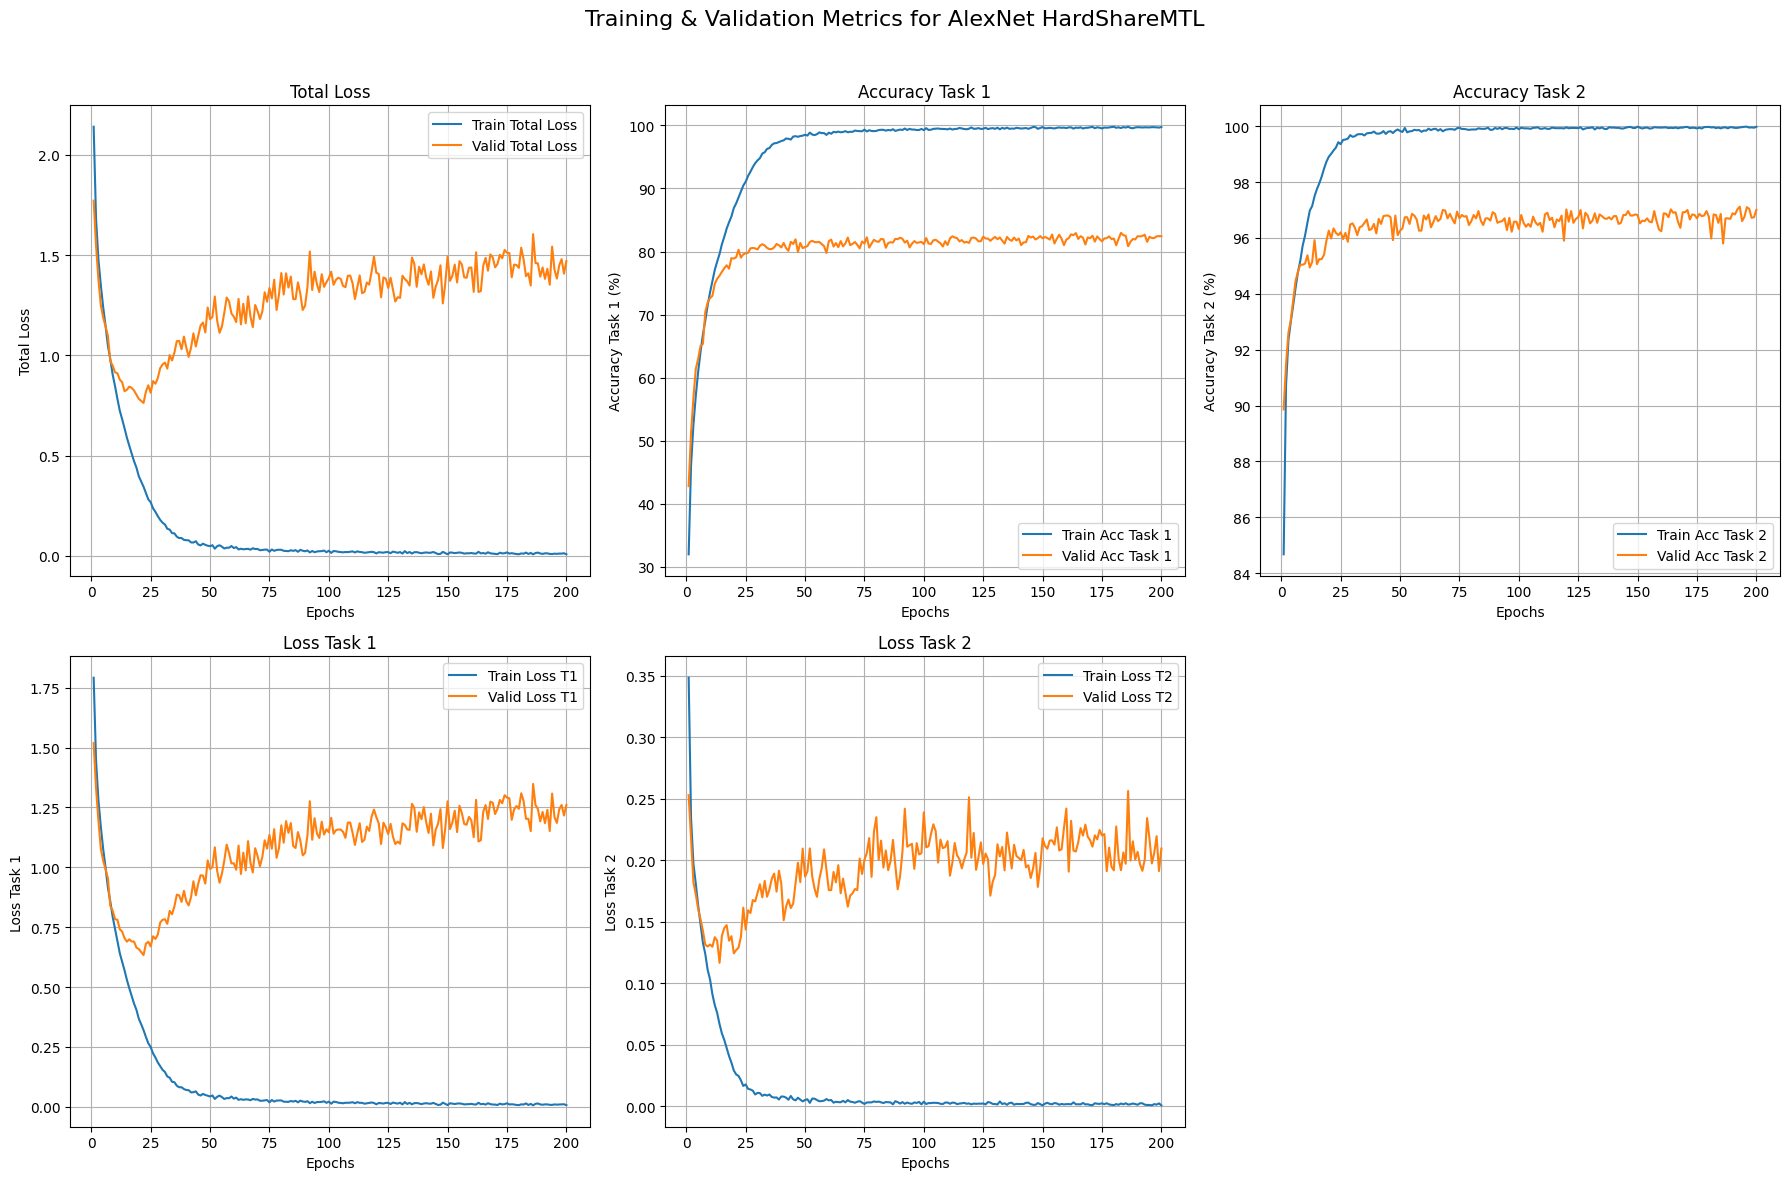

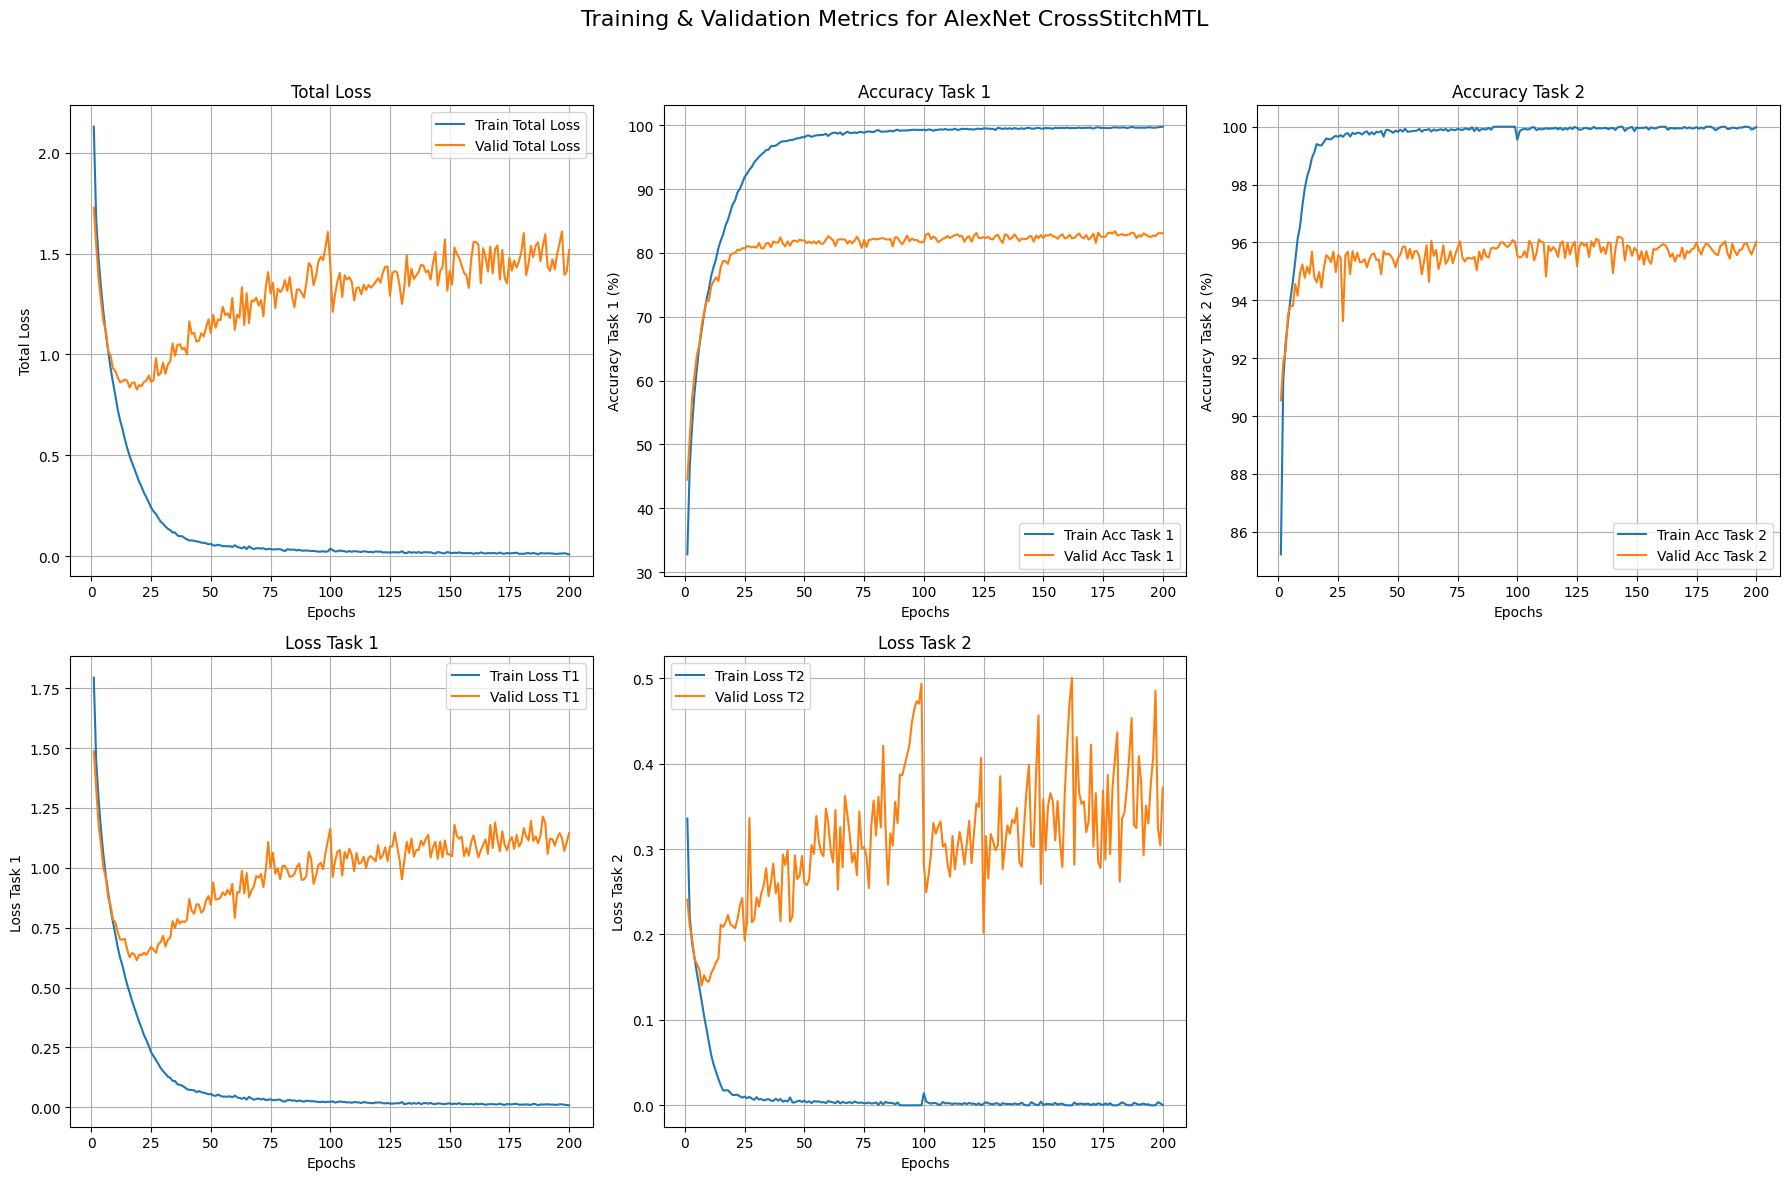

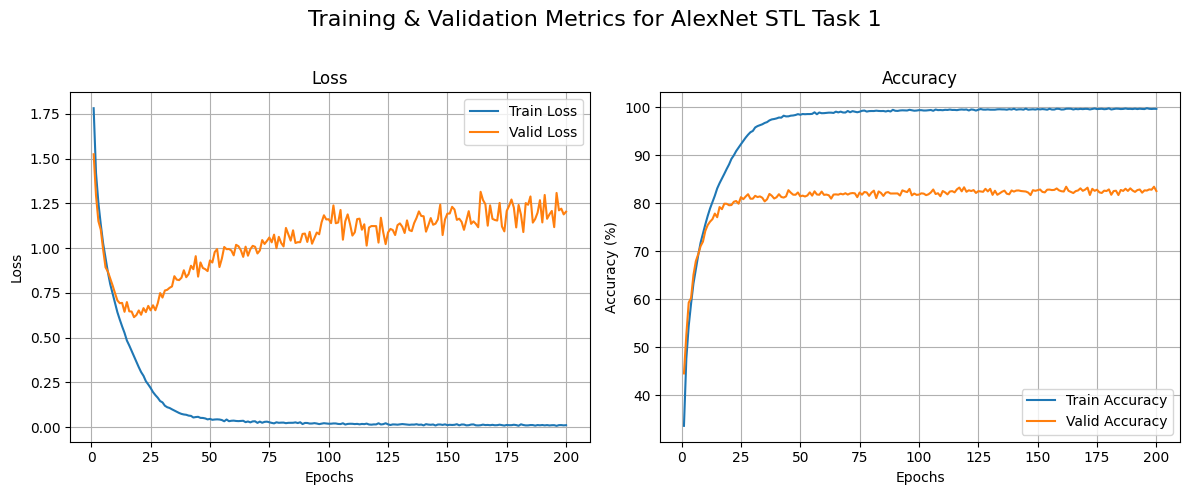

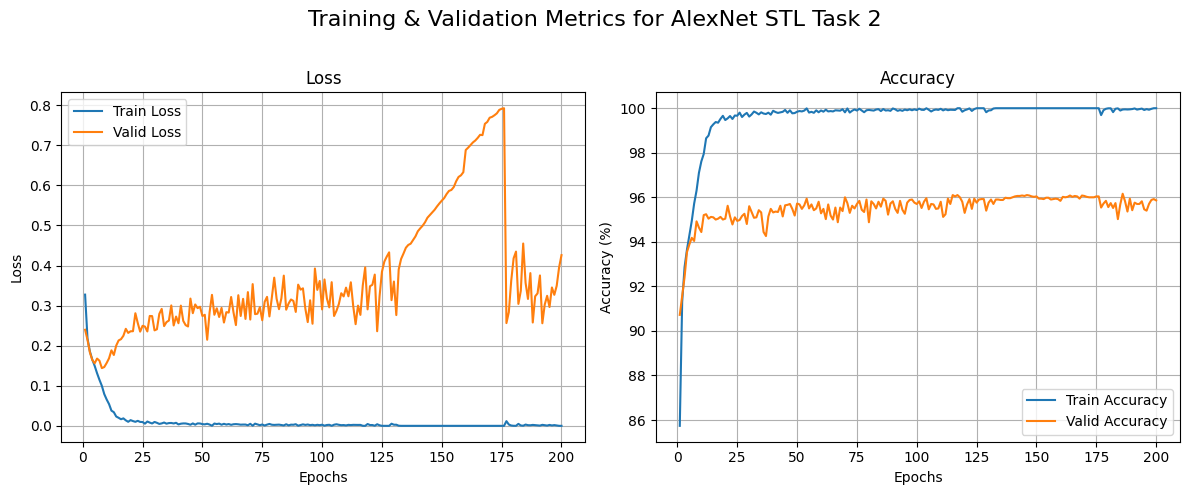

In [33]:
# Plot results
# Ensure results lists are populated before calling plot function
if 'hs_mtl_training_results_list' in globals() and hs_mtl_training_results_list:
   plot_training_results(hs_mtl_training_results_list, "AlexNet HardShareMTL")
else:
    print("HardShareMTL results not available for plotting.")

if 'cs_mtl_training_results_list' in globals() and cs_mtl_training_results_list:
   plot_training_results(cs_mtl_training_results_list, "AlexNet CrossStitchMTL")
else:
    print("CrossStitchMTL results not available for plotting.")

if 'stl_task1_training_results_list' in globals() and stl_task1_training_results_list:
   plot_training_results(stl_task1_training_results_list, "AlexNet STL Task 1")
else:
    print("STL Task 1 results not available for plotting.")

if 'stl_task2_training_results_list' in globals() and stl_task2_training_results_list:
   plot_training_results(stl_task2_training_results_list, "AlexNet STL Task 2")
else:
    print("STL Task 2 results not available for plotting.")

In [34]:
# Final Performance Summary
print("\n--- Performance Summary (Final Test Set Accuracies) ---")
# Check if final accuracy variables exist before printing
if 'final_test_acc1_hs_mtl' in globals():
    print(f"AlexNet HardShareMTL - Task 1 Acc: {final_test_acc1_hs_mtl:.2f}%, Task 2 Acc: {final_test_acc2_hs_mtl:.2f}%")
else:
    print("HardShareMTL final test accuracies not available.")

if 'final_test_acc1_cs_mtl' in globals():
    print(f"AlexNet CrossStitchMTL - Task 1 Acc: {final_test_acc1_cs_mtl:.2f}%, Task 2 Acc: {final_test_acc2_cs_mtl:.2f}%")
else:
    print("CrossStitchMTL final test accuracies not available.")

if 'final_test_acc_st1' in globals():
    print(f"AlexNet STL Task 1 - Task 1 Acc: {final_test_acc_st1:.2f}%")
else:
    print("STL Task 1 final test accuracy not available.")

if 'final_test_acc_st2' in globals():
    print(f"AlexNet STL Task 2 - Task 2 Acc: {final_test_acc_st2:.2f}%")
else:
    print("STL Task 2 final test accuracy not available.")


--- Performance Summary (Final Test Set Accuracies) ---
AlexNet HardShareMTL - Task 1 Acc: 79.66%, Task 2 Acc: 96.45%
AlexNet CrossStitchMTL - Task 1 Acc: 79.42%, Task 2 Acc: 94.83%
AlexNet STL Task 1 - Task 1 Acc: 80.31%
AlexNet STL Task 2 - Task 2 Acc: 94.57%
